# My Movie Database (MMDb)

## Structure

- Sources
    - Trakt : Track what you watch and when
    - OMDb : Open Movie Database
    - IMDb : Internet Movie Database 
    
- Merge OMDb data with IMDb data based on Trakt's watched movies history

## Inputs

- Merged dataset : pickle
- Trakt : only by connection with API
- OMDb  : txt or connection with API
- IMDb  : txt or connection with API

## Outputs

- OMDb request result : txt
- IMDb request result : txt
- Merged dataset : pickle

---

# Hard settings

In [1]:
## OPTIONAL
# Get data
get_data = True

# Force api requests and get all data
force_request = False
if force_request:
    get_data = True

# Check data before analysis
data_check = False

# Export data
export = False
# Export data to pickle file
export_pickle = False

In [2]:
## DON'T CHANGE
# Load Files
load_pickle = False
load_omdb = False
load_imdb = False

# Imports

In [3]:
# https://stackoverflow.com/questions/66920753/running-a-justpy-web-app-on-jupyter-returns-runtimeerror
import nest_asyncio
nest_asyncio.apply()

import os
import time

# Import functions
#https://stackoverflow.com/questions/20186344/ipynb-import-another-ipynb-file
%run MMDb_functions.ipynb

In [4]:
path = os.getcwd()
src_path = path + '\\Desktop\\Data Analysis\\'

# Load Files

## Pickle file

In [5]:
# The pickle module implements binary protocols for serializing and de-serializing a Python object structure. 
# “Pickling” is the process whereby a Python object hierarchy is converted into a byte stream, and “unpickling” is the inverse operation, 
# whereby a byte stream (from a binary file or bytes-like object) is converted back into an object hierarchy.
pkl_file = 'movies.pkl'
pkl_path = src_path + pkl_file

try:
    foo = pickle.load(open(pkl_path, "rb"))
except (OSError, IOError) as e:
    foo = 3
    #pickle.dump(foo, open(pkl_path, "wb"))
    
if isinstance(foo, pd.core.frame.DataFrame):
    load_pickle = True
    
    foo.sort_values(by='Timestamp', inplace=True)
    foo = foo.reset_index(drop=True)

    foo.info()
else:
    print('No pickle.')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884 entries, 0 to 883
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Title             884 non-null    object        
 1   Year              884 non-null    int32         
 2   imdbID            884 non-null    object        
 3   Rated             884 non-null    object        
 4   Runtime           884 non-null    int32         
 5   Genre             884 non-null    object        
 6   Director          884 non-null    object        
 7   Writer            884 non-null    object        
 8   Cinematographers  884 non-null    object        
 9   Actors            884 non-null    object        
 10  Plot              884 non-null    object        
 11  Language          884 non-null    object        
 12  Country           884 non-null    object        
 13  Metascore         884 non-null    int32         
 14  imdbRating        884 non-

## Trakt

In [6]:
## Movies watched multiple times (between 2020 and 2022)
# Jojo Rabbit
# Dune (2021)
# The Trip
# Heavy Trip

# Method 'last_watched_movies" only gets last result

In [7]:
if get_data:
    # Initialize Trakt class
    trakt = TRAKT()
    
    from_date = '2018-01-01' # foo.Date.dt.date.max()
    # Create trakt dataframe
    df_trakt = trakt.create_df(start_date = from_date)    
    df_trakt.info()
    
    # Last movies added
    show_all(df_trakt.tail())

Please go here and authorize, https://api-v2launch.trakt.tv/oauth/authorize?response_type=code&client_id=44d31710427cac373b1695d3dad58fed78faaaa734555281abc070894ba5216c&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&state=nsyXvyPeSsA7pgqwfQkP44l6mcjcmh&username=lmgmiranda


Paste the Code returned here:  AEB70C43


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 895 entries, 0 to 894
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   title      895 non-null    object        
 1   id         895 non-null    object        
 2   timestamp  895 non-null    datetime64[ns]
 3   year       895 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 28.1+ KB


### New movies watched?

In [8]:
# PICKLE VS TRAKT
if get_data:
    data = []

    # Check if size is different (new movies watched)
    _, newMovies = check_new_movies(foo, df_trakt)

    if isinstance(foo, pd.core.frame.DataFrame) and newMovies > 0:
        # Pickle file exists
        # Get new movies
        data = df_trakt.sort_values(by='timestamp').iloc[-newMovies:,:].reset_index(drop=True)
        show_all(data)
        
        ## Reset df_trakt
        #df_trakt = df_trakt.iloc[-newMovies:,:].reset_index(drop=True)
        print('New Movies: ', newMovies)
        
    else:
        if force_request:
            print('Forcing request...')
        else:
            print('Get data mode.')
            
        # Select data to search in OMDb
        data = df_trakt.copy() #[['title','id']]        
        
else:
    newMovies = 0
    print('Do nothing.') 

New Movies:  2


## OMDb

In [9]:
if newMovies > 0 or not get_data:
    load_omdb = True
    # Initialize OMDB class
    omdb = OMDB()
    
    try:
        omdb_file = 'omdb.txt'
        omdb_path = src_path + omdb_file
        
        df_omdb = omdb.load(omdb_path)
        ## Clean dataframe
        df_omdb = omdb.convert_columns(df_omdb)
        df_omdb.columns = [x.lower() for x in df_omdb.columns]

        df_omdb.info()
        
    except (OSError, IOError) as e:
        df_omdb = 3

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893 entries, 0 to 892
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   title       893 non-null    object        
 1   year        893 non-null    int64         
 2   rated       893 non-null    object        
 3   released    893 non-null    object        
 4   runtime     893 non-null    int32         
 5   genre       893 non-null    object        
 6   director    893 non-null    object        
 7   writer      868 non-null    object        
 8   actors      892 non-null    object        
 9   plot        893 non-null    object        
 10  language    891 non-null    object        
 11  country     893 non-null    object        
 12  awards      846 non-null    object        
 13  poster      893 non-null    object        
 14  ratings     893 non-null    object        
 15  metascore   893 non-null    int32         
 16  imdbrating  890 non-null  

### Connect with OMDb

In [10]:
# Get new movies
if load_omdb:
    
    # Here newMovies is the diffence between foo and trakt  
    if (isinstance(df_omdb, pd.core.frame.DataFrame) and newMovies > 0) or force_request:
        # Check difference
        _, newMovies = check_new_movies(df_omdb, df_trakt)
        
        # Here newMovies is the diffence between omdb and trakt  
        if newMovies != 0:
            print('Adding new movies to df... \n')
            df_omdb = look_iama_pickle(df_omdb, df_trakt, 'omdb') 
    
            # Get all columns
            all_cols = df_omdb.columns
        else:
            print('Leave OMDb alone!')
       
    else:
        if isinstance(df_omdb, int) or force_request: # no pickle saved OR force db request (all movies)
            print('Get all data. \n')
            ## Copy foo if pickle exists and there's no new movies
            df_omdb = look_iama_pickle(foo, df_trakt, 'omdb', force_request)

            # Extract these columns
            all_cols = df_omdb.iloc[:,:-10].columns # from 'title' to 'time'
        else:
            print('Leave OMDb alone!')
    
    df_omdb.reset_index(drop=True, inplace=True)

Adding new movies to df... 



#### Check for errors

In [11]:
# Bad movie info
if load_omdb:
    if 'error' in df_omdb.columns:
        print('Errors: ', len(df_omdb[df_omdb['error'].notnull()]))
        
        # analyze query errors
        errorlist= df_omdb[~df_omdb['error'].isna()].index
        show_all(df_trakt.iloc[errorlist])
    else:
        print('No errors.')

No errors.


#### Select data

In [12]:
# Filter columns for view
view_cols = ['title','year','runtime','genre','director','actors','plot','language','metascore','imdbrating','timestamp']

if load_omdb:
    # Force organize by date watched
    df_last = df_omdb.loc[:, view_cols]
    
    # Check last entries
    N = 10
    remove_view = ['actors','plot']
    show_all(df_last.drop(remove_view, axis=1).tail(N))

#### Clean dataset

In [13]:
if load_omdb:
    ## Clean dataframe
    df_omdb = omdb.convert_columns(df_omdb)
    
    ### Drop duplicates just in case - such as Jojo Rabbit and Dune
    #df_omdb.drop_duplicates(['title','year','date'], keep='first', inplace=True)

## IMDb

In [14]:
# newMovies may be set to 0 when omdb compares to trakt but we need to load imdb.txt if pickle is missing
if newMovies > 0 or not get_data:
    load_imdb = True
    # Initialize IMDB class and import imdb file
    imdb = IMDB()
    
    try:
        imdb_file = 'imdb.txt'
        imdb_path = src_path + imdb_file
        df_imdb = imdb.load(imdb_path)
               
        # Clean imdb df
        df_imdb = imdb.convert_columns(df_imdb)
        df_imdb.columns = [x.lower() for x in df_imdb.columns]
        
        df_imdb.info()
        
    except (OSError, IOError) as e:
        df_imdb = 3

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893 entries, 0 to 892
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   title                 893 non-null    object        
 1   year                  893 non-null    int32         
 2   imdbid                893 non-null    object        
 3   runtimes              893 non-null    int32         
 4   genres                893 non-null    object        
 5   director              893 non-null    object        
 6   writer                893 non-null    object        
 7   cinematographers      893 non-null    object        
 8   cast                  893 non-null    object        
 9   countries             893 non-null    object        
 10  languages             893 non-null    object        
 11  rating                893 non-null    float64       
 12  votes                 893 non-null    int32         
 13  plot outline        

### Connect with IMDb

In [15]:
# Get new movies
if load_imdb:
    
    if (isinstance(df_imdb, pd.core.frame.DataFrame) and newMovies > 0) or force_request:
        # Here newMovies is the diffence between imdb and trakt  
        _, newMovies = check_new_movies(df_imdb, df_trakt)

        print('Adding new movies to df... \n')
        df_imdb = look_iama_pickle(df_imdb, df_trakt, 'imdb', force_request)
    
    else:    
        if isinstance(df_imdb, int) or force_request: # no pickle saved OR force db request (all movies)
            print('Get all data. \n')   
            df_imdb = look_iama_pickle(foo, df_trakt, 'imdb', force_request)
        else:
            print('Leave IMDb alone!')
            
    if get_data:
        df_imdb['imdbid'] = df_trakt['id']
    else:
        pass
        
    show_all(df_imdb.tail().loc[:,:'director'])

Adding new movies to df... 



#### Clean dataset

In [16]:
if load_imdb:
    #df_imdb = imdb.clean_df(df_imdb)
    df_imdb = imdb.convert_columns(df_imdb)

---

# Merge Datasets (OMDb & IMDb)

In [17]:
# If pickle exist and don't want more data, work with pickle
if load_pickle and not get_data:
    print('Get pickle.')
    df = foo.copy()

# If more new movies (get_data is on) OR no new movies but pickle don't exist - do the merge
else:
    ## Prepare key to merge (remove tt from id and always get 7 numbers)
    # OMDb format imdb id 
    df_omdb['imdbid'] = df_omdb['imdbid'].str.replace(r'tt', '')
    df_omdb['imdbid'] = df_omdb['imdbid'].str.zfill(7)
    # IMDb format imdb id 
    df_imdb['imdbid'] = df_imdb['imdbid'].str.replace(r'tt', '')
    df_imdb['imdbid'] = df_imdb['imdbid'].str.zfill(7)
    
    # Merge dataframes on key = 'imdbid'
    df_merge = df_imdb.merge(df_omdb, on='imdbid')
    
    # Select columns after merge
    merge_cols = ['title_x','year_x','imdbid','rated','runtimes','genres','director_x','writer_x','cinematographers',
                  'cast','plot','languages','countries','metascore','rating','votes','production companies',
                  'timestamp_y','date_y','time_y']   
    
    df_merge = df_merge[merge_cols]

    # Rename columns
    cols = ['Title','Year','imdbID','Rated','Runtime','Genre','Director','Writer','Cinematographers',
            'Actors','Plot','Language','Country','Metascore','imdbRating','imdbVotes','Production',
            'Timestamp','Date','Time']   
    
    df_merge.columns = cols
    
    # Drop duplicates
    df_merge.drop_duplicates(['Title','Year','Date'], keep='first', inplace=True)
    # Sort by timestamp
    df_merge.sort_values(by='Timestamp', inplace=True)
    df_merge.reset_index(drop=True, inplace=True)
    
    # Work with this df
    df = df_merge.copy()
    
# Check data merging result
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 895 entries, 0 to 894
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Title             895 non-null    object        
 1   Year              895 non-null    int32         
 2   imdbID            895 non-null    object        
 3   Rated             895 non-null    object        
 4   Runtime           895 non-null    int32         
 5   Genre             895 non-null    object        
 6   Director          895 non-null    object        
 7   Writer            895 non-null    object        
 8   Cinematographers  895 non-null    object        
 9   Actors            895 non-null    object        
 10  Plot              895 non-null    object        
 11  Language          895 non-null    object        
 12  Country           895 non-null    object        
 13  Metascore         895 non-null    int32         
 14  imdbRating        895 non-

In [18]:
# Last data from merged df
df.tail(3)

Title  Year   imdbID      Rated  Runtime  \
892  Save Yourselves!  2020  7873348          R       93   
893             Comet  2014  2965412          R       91   
894          Plus One  2019  7645122  Not Rated       98   

                              Genre                             Director  \
892       Adventure, Comedy, Sci-Fi  Alex Huston Fischer, Eleanor Wilson   
893  Comedy, Drama, Romance, Sci-Fi                           Sam Esmail   
894          Comedy, Drama, Romance             Jeff Chan, Andrew Rhymer   

                                  Writer Cinematographers  \
892  Eleanor Wilson, Alex Huston Fischer              N/A   
893                           Sam Esmail              N/A   
894             Andrew Rhymer, Jeff Chan              N/A   

                                                Actors  \
892  Sunita Mani, John Reynolds, Ben Sinclair, John...   
893  Justin Long, Kayla Servi, Eric Winter, Emmy Ro...   
894  Jack Quaid, Maya Erskine, Beck Bennett, Jessy ...   

                                                  Plot Language  \
892  A young Brooklyn couple heads to an upstate ca...  English   
893  Set in a parallel universe, Comet bounces back...  English   
894  In order to survive a summer of wedding fever,...  English   

           Country  Metascore  imdbRating  imdbVotes  \
892  United States         67         5.7       6653   
893  United States         52         6.7      18458   
894  United States         65         6.6      10388   

                                            Production           Timestamp  \
892  Keshet Studios, Last Rodeo Studios, Washington... 2022-03-14 23:22:29   
893  Anonymous Content, Fubar Films FL, Fubar Films... 2022-03-15 23:43:42   
894  Red Hour Films, Studio71, Firewatch, The Binde... 2022-03-16 23:50:12   

          Date      Time  
892 2022-03-14  23:22:29  
893 2022-03-15  23:43:42  
894 2022-03-16  23:50:12

---

In [19]:
if data_check:
    input("Press Enter to continue...")
else:
    pass

---

# Export data

In [20]:
# Setup to export OMDb data (and therefore import - pickle file) and IMDb data
if export:
    ## Export pickle
    if export_pickle:
        df.to_pickle(pkl_path)
        
    ## Export omdb file
    omdb_file_export = 'omdb.txt'
    omdb_path_export = src_path + omdb_file_export
    df_omdb.to_csv(omdb_path_export, encoding='utf-8', index=False)  

    ## Export imdb file
    imdb_file_export = 'imdb.txt'
    imdb_path_export = src_path + imdb_file_export        
    df_imdb.to_csv(imdb_path_export, encoding='utf-8', index=False)       
else:
    pass

---

# Analysis

In [21]:
# Set plot style
plt.style.use('fivethirtyeight')

# Work with top 10
N = 10

In [22]:
# Any shorts?
short_cols = ['Title','Year','Runtime','Genre','Director']

## Show movies with less than 60 minute still in the dataset
#show_all(df[df.Runtime < 60].sort_values(by=['Runtime'])[short_cols])

# Show 'short' genre movies
show_all(df[df['Genre'].str.contains("Short")][short_cols])

# Remove 'short' genre from the df
shorts = df[df['Genre'].str.contains("Short")]

print('There are ' + str(len(shorts)) + ' shorts in the dataset.')
df = df[~df['Genre'].str.contains("Short")]

There are 9 shorts in the dataset.


In [23]:
# Show df after filtering
df.shape

(886, 20)

In [24]:
# Describe df (only object columns)
df[df.columns.difference(['Title', 'Actors', 'Plot', 'imdbID'])].describe(include=['object'])

Cinematographers        Country     Director  Genre Language  \
count               886            886          886    886      886   
unique                1            230          662    343      252   
top                 N/A  United States  David Lynch  Drama  English   
freq                886            353           10     64      413   

       Production Rated      Time Writer  
count         886   886       886    886  
unique        861    17       849    792  
top           N/A     R  23:15:00    N/A  
freq            7   406         3     25

In [25]:
## Duplicated movies in the dataset (rewatched movies within date range)
#df[df[['Title','Year','Runtime']].duplicated(keep=False)][['Title','Year','Director','imdbRating','Timestamp']]

## Show entire DataFrame

In [26]:
data_check = False
if data_check:
    cols = ['Title','Year','Runtime','Genre','Director','Actors','Plot','Date']
    display(HTML(df[cols].sort_values('Date', ascending=False).to_html()))
else:
    pass

---

## Let the games begin... 

In [27]:
# Get actual date
now = pd.Timestamp('now')

# Get list of years (originally from timestamp of date viewed - starts in 2020)
years = list(df.Date.dt.year.unique())
years.sort()

# Retain all info for timestamp analysis
df_all = df.copy()

### All watched

In [28]:
# All (movies and documentaries) watched by year
df_diff_watched_year, df_all_watched = totals_by_year(df, True, True)
df_all_watched

Title      
     nunique count
Year              
2018      59    59
2019      73    73
2020     251   251
2021     404   404
2022      99    99

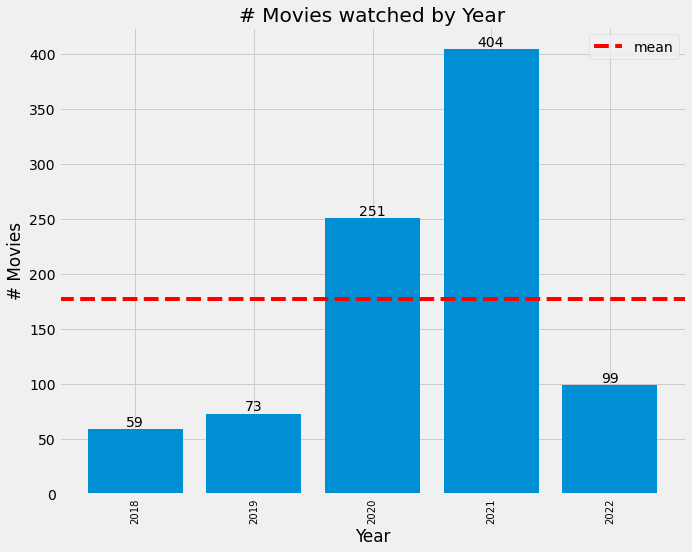

In [29]:
# Plot all watched by year
x = df_all_watched.index
y = df_all_watched[('Title','count')]

_, ax = plt.subplots(figsize=(10, 8))
add_ticks_vbarplot(x, y, ax)     

plt.title('# Movies watched by Year')
plt.xlabel('Year')
plt.ylabel('# Movies')

plt.axhline(y=y.mean(), color='red', ls='--', label='mean')
plt.legend()
plt.show()

In [234]:
# Difference from previous year
pct_col = 'pct (%)'

df_year_change = df_diff_watched_year.copy()
df_year_change.drop('Genre', axis=1, inplace=True)
df_year_change = df_year_change.diff().fillna(0).astype(int)

df_year_change[pct_col] = pd.DataFrame(df_all_watched.pct_change()[('Title','count')]*100)
df_year_change[pct_col] = df_year_change[pct_col].fillna(0).astype(int)
df_year_change.rename(columns={'Title':'diff'}, inplace=True)

df_year_change.style.background_gradient(axis=None)

In [31]:
# Movies + Documentaries watched per day in year
[
    [
        movies_per_day(df_diff_watched_year, year)
    ] for year in years
];

0.16 movies per day in 2018
0.2 movies per day in 2019
0.69 movies per day in 2020
1.11 movies per day in 2021
1.3 movies per day in 2022


#### Split by month and weekday

In [227]:
# All by month/year
ct_month_year = crosstab_by_year(df).droplevel('Month', axis=1)
ct_month_year.style.background_gradient(axis=1, subset=ct_month_year.columns[:-1]) # evaluate by year

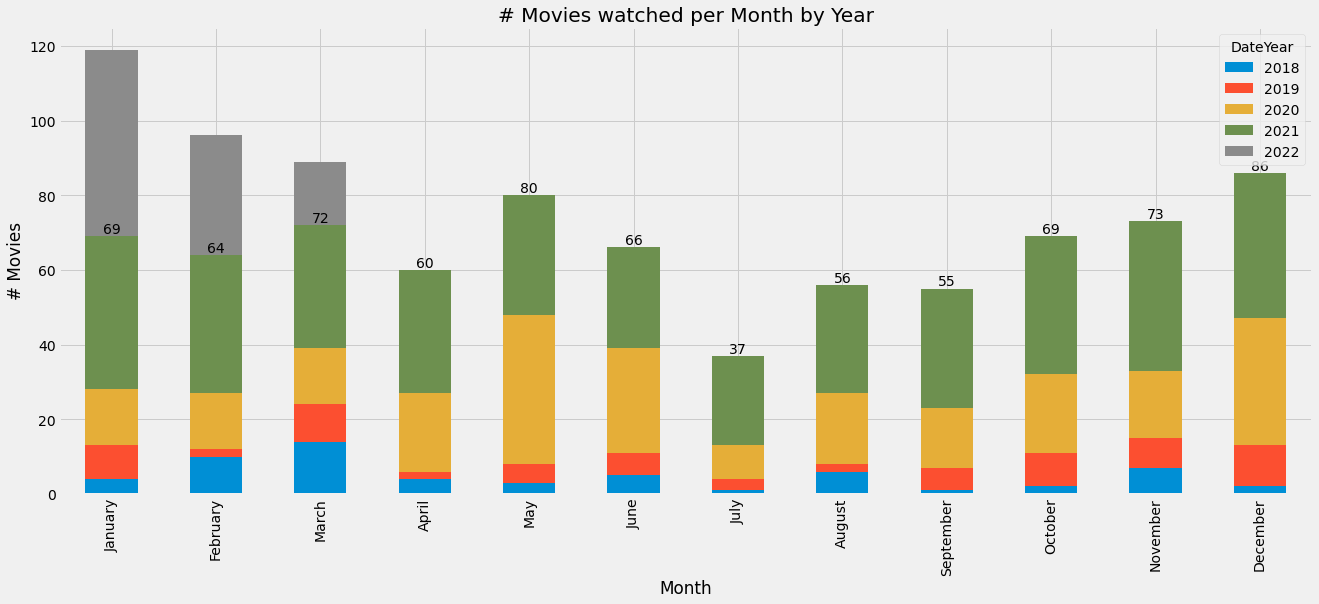

In [33]:
# Plot bar plot of movies watched month by year
plot_mby = crosstab_by_year(df).droplevel('Month', axis=1).drop('', axis=1).T
ax = plot_mby.drop('All', axis=1).plot(kind='bar', stacked=True, figsize=(20,8));

ax.bar_label(ax.containers[len(years)-2])

plt.title('# Movies watched per Month by Year')
plt.xlabel('Month')
plt.ylabel('# Movies')

plt.show()

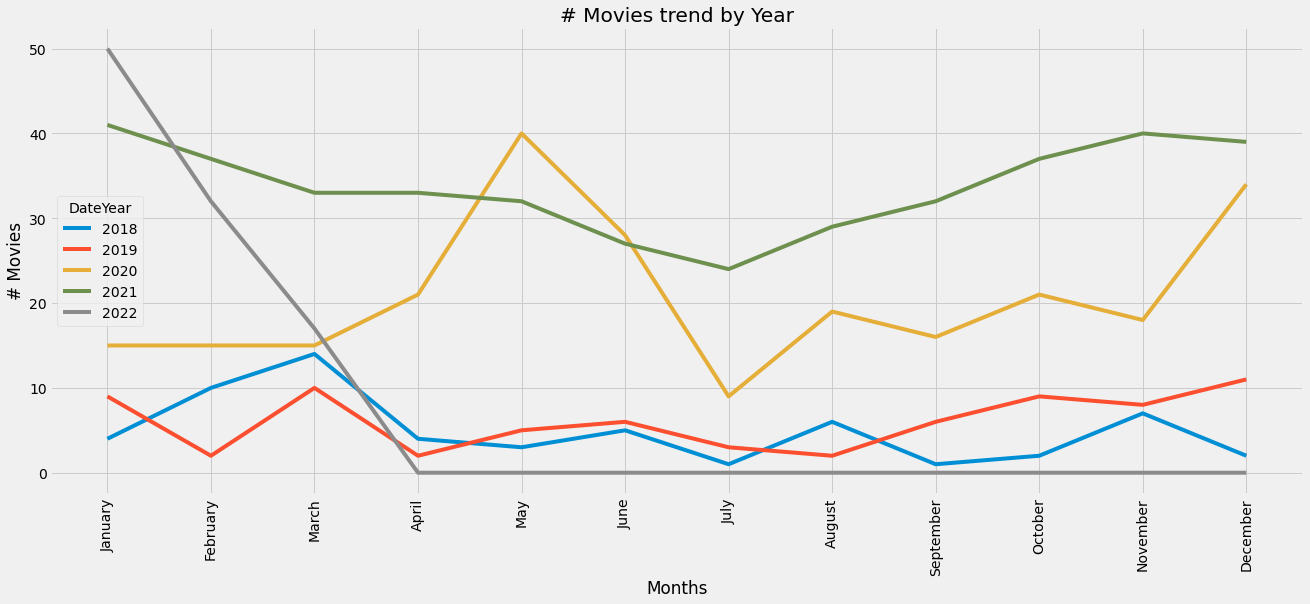

In [34]:
# Plot watched movies trend by year
plot_ty = crosstab_by_year(df).droplevel('Month', axis=1).drop('All').drop('', axis=1).T
ax = plot_ty.plot(figsize=(20,8));

ax.xaxis.set_ticks(np.arange(len(plot_ty.index)))
ax.xaxis.set_ticklabels(plot_ty.index)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90) 

plt.title('# Movies trend by Year')
plt.xlabel('Months')
plt.ylabel('# Movies')

plt.show()

In [235]:
# Difference of movies & documentaries watched from previous year
ct_month_year_diff = crosstab_by_year(df).diff().drop('All').fillna(0).astype(int)
ct_month_year_diff = ct_month_year_diff.droplevel('Month', axis=1)
ct_month_year_diff.style.background_gradient(subset=ct_month_year_diff.columns[:-1], axis=1) # evaluate by year

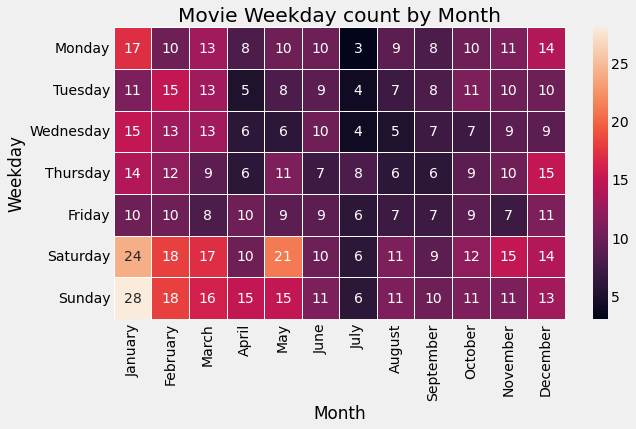

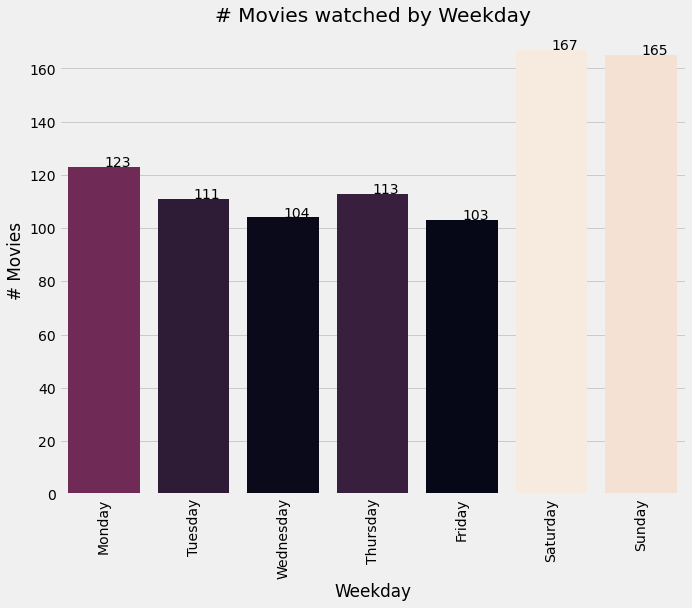

37% of the movies were watched on the weekend!


In [36]:
# Overview
plot_ct_heatmap(df, 'Weekday', None)
plot_weekday_bar(df, None)
plt.show()

ratio_weekend(df, None)

### Movies only

In [236]:
# Movies (only) by year
df_movies_year, df_show_movies = totals_by_year(df, docs=False)

# Difference from previous year of movies watched
df_show_movies['Diff'] = df_movies_year.diff().drop('Genre', axis=1).fillna(0).astype(int)

df_show_movies.style.background_gradient(subset='Diff')

### Documentaries only

In [237]:
# Documentaries (only) by year
df_docs_year, df_show_docs = totals_by_year(df, docs=True)

# Difference from previous year of documentaries watched
df_show_docs['Diff'] = df_docs_year.diff().drop('Genre', axis=1).fillna(0).astype(int)

df_show_docs.style.background_gradient(subset='Diff')

## By Year 

In [39]:
# Setup timestamp here - to be used later
cols = ['Title','Year','Rated','Genre','Timestamp','Date','Time']
df_timestamp = df_all[cols].copy()
explode_date(df_timestamp)
df_timestamp['Hour'] = df_timestamp.Timestamp.dt.hour
df_timestamp['Minute'] = df_timestamp.Timestamp.dt.minute

# https://stackoverflow.com/questions/62915974/pandas-group-by-time-interval-5min-10min-1day-1year-and-count-amount-of-ent
period = '15Min'
# divide hour into blocks of x minutes
df_timestamp['Period'] = pd.DataFrame(df_timestamp.Timestamp.dt.floor(period)).Timestamp.dt.minute

2018 



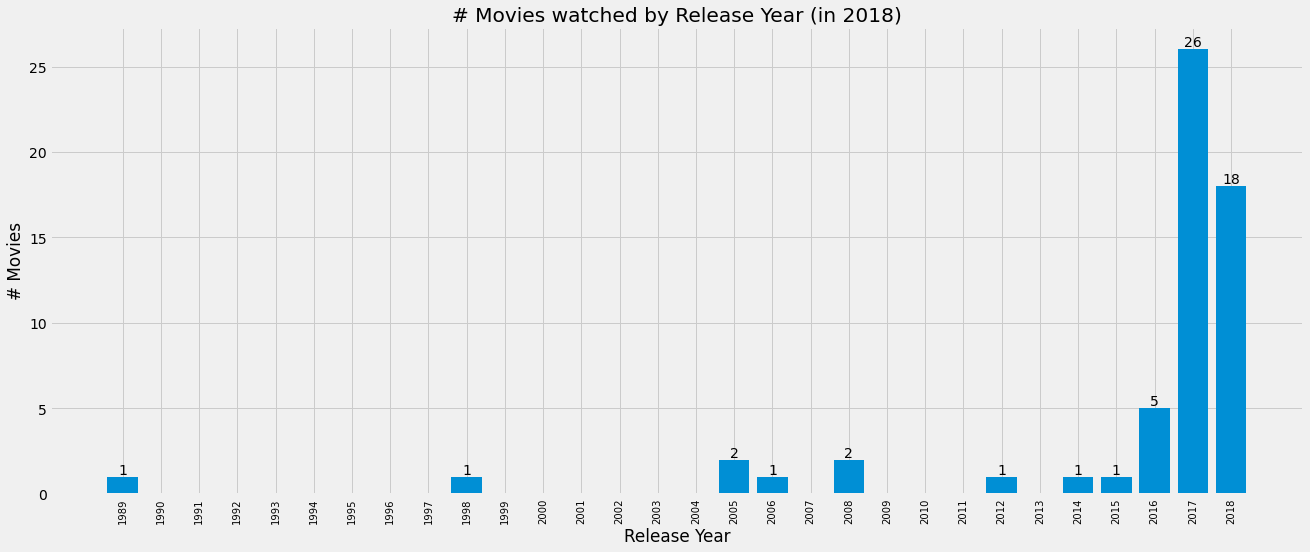

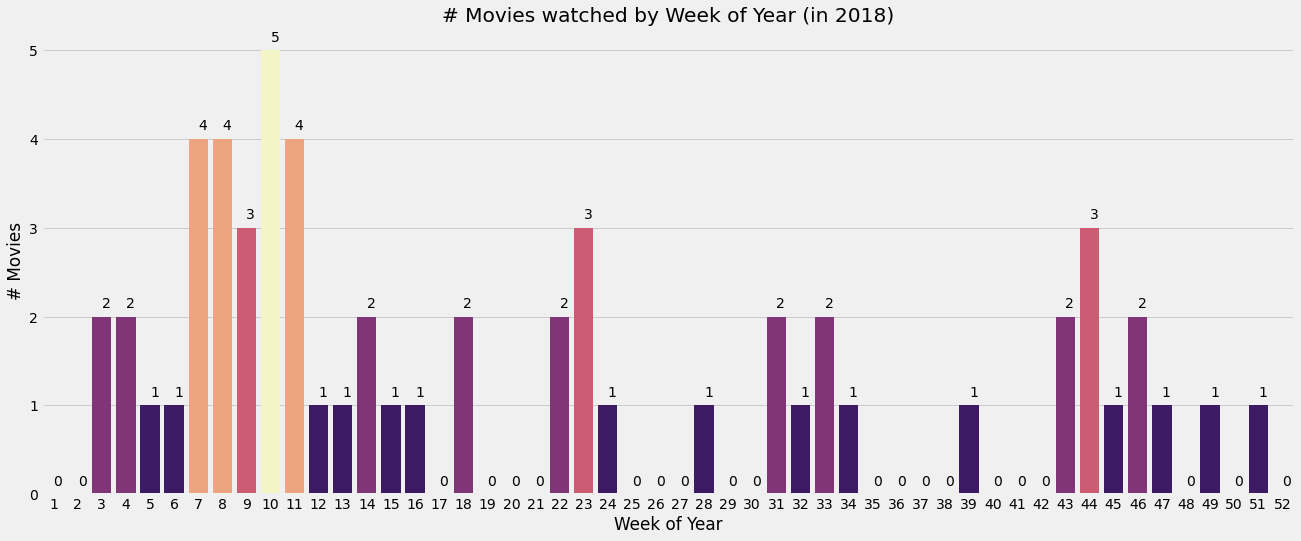

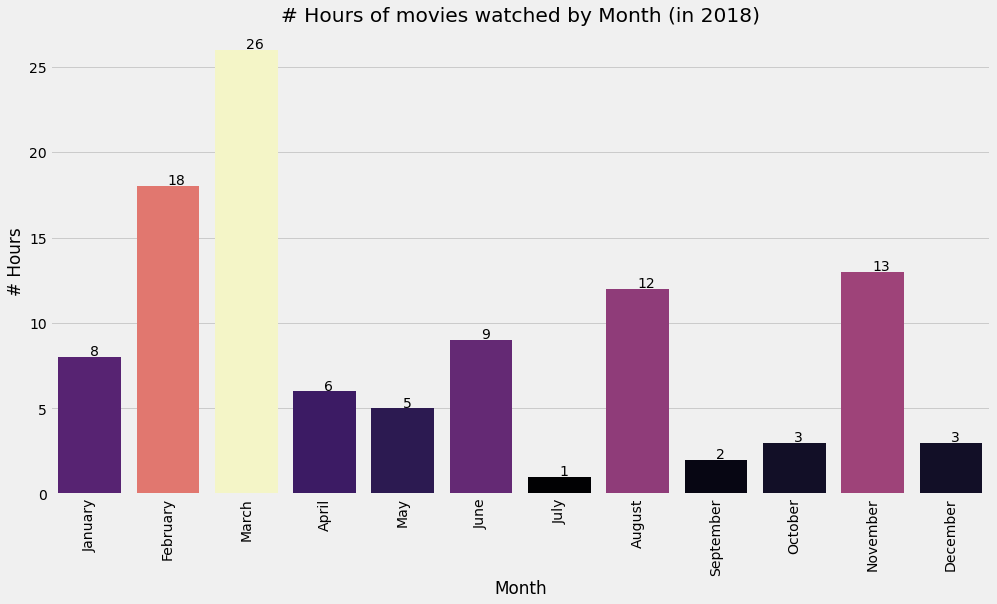

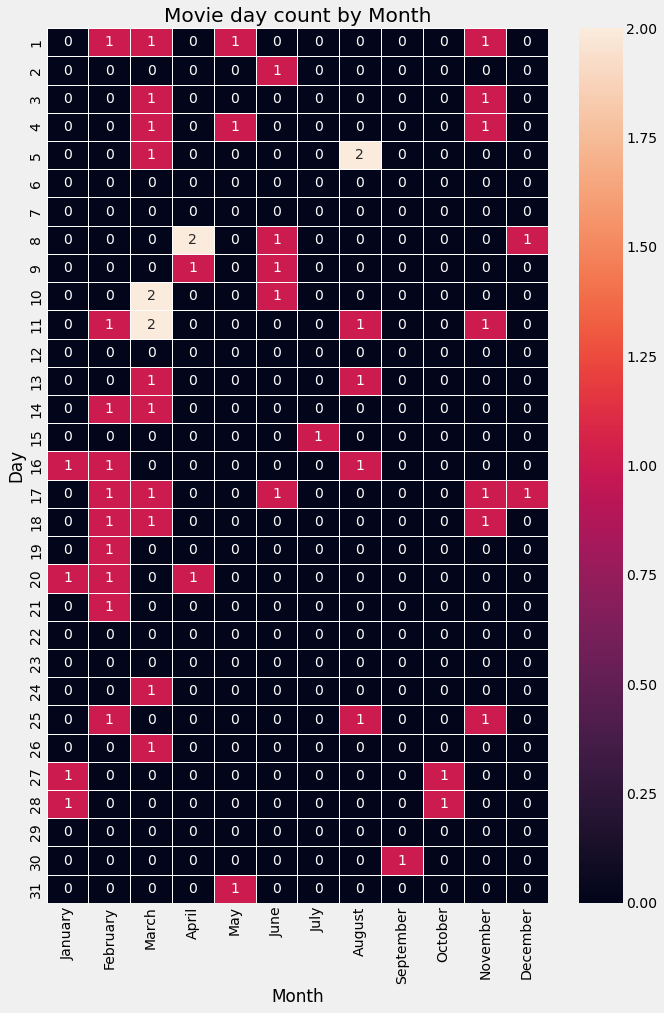

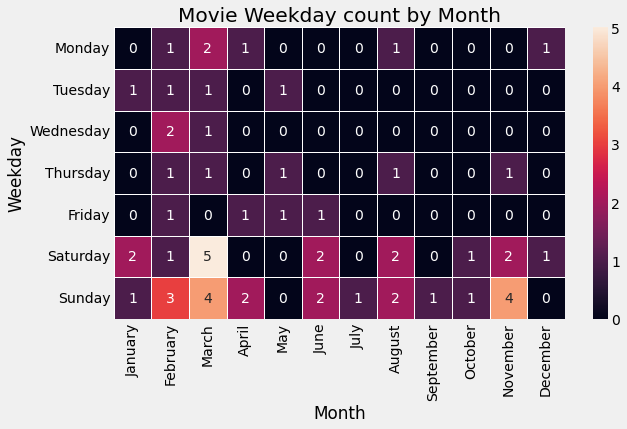

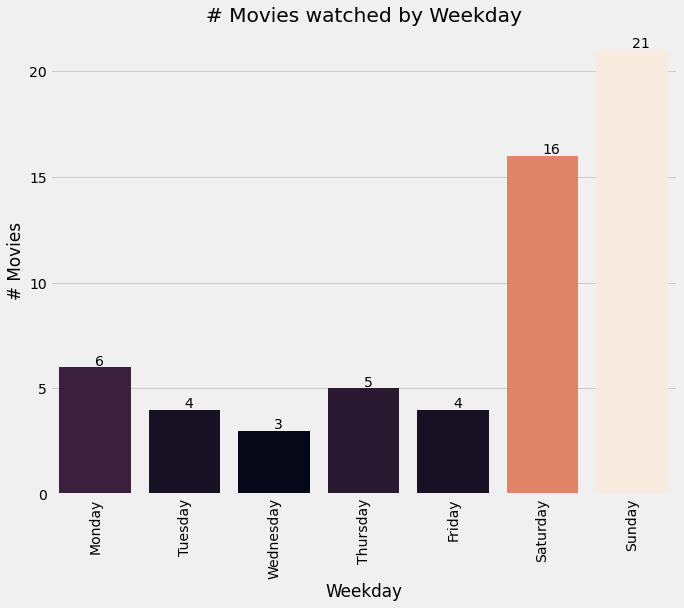

62% of the movies were watched on the weekend!



2019 



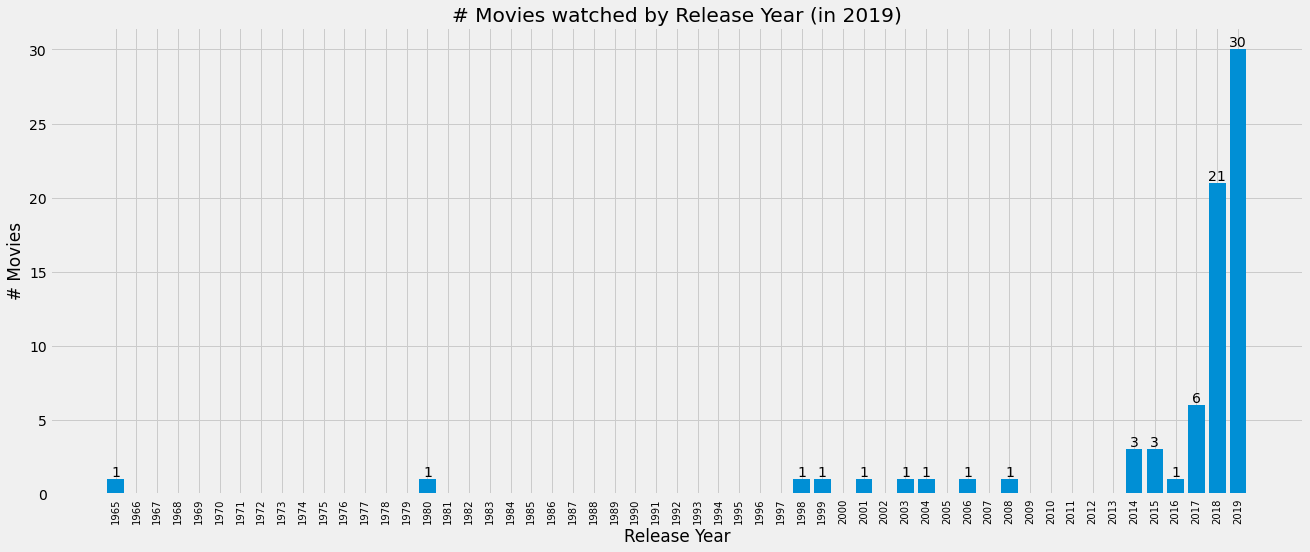

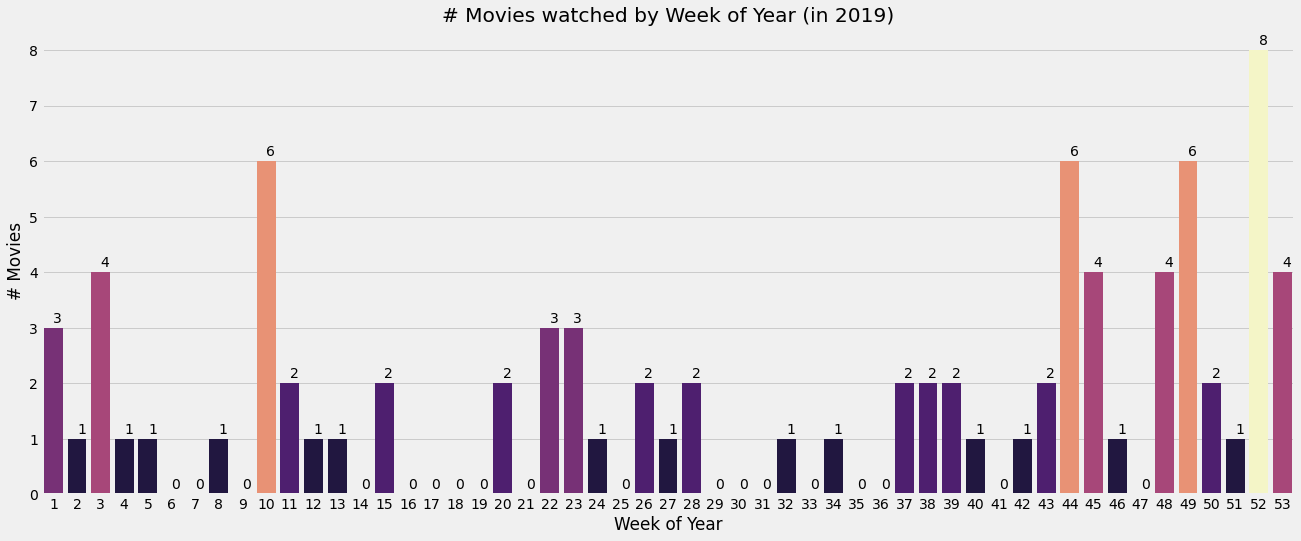

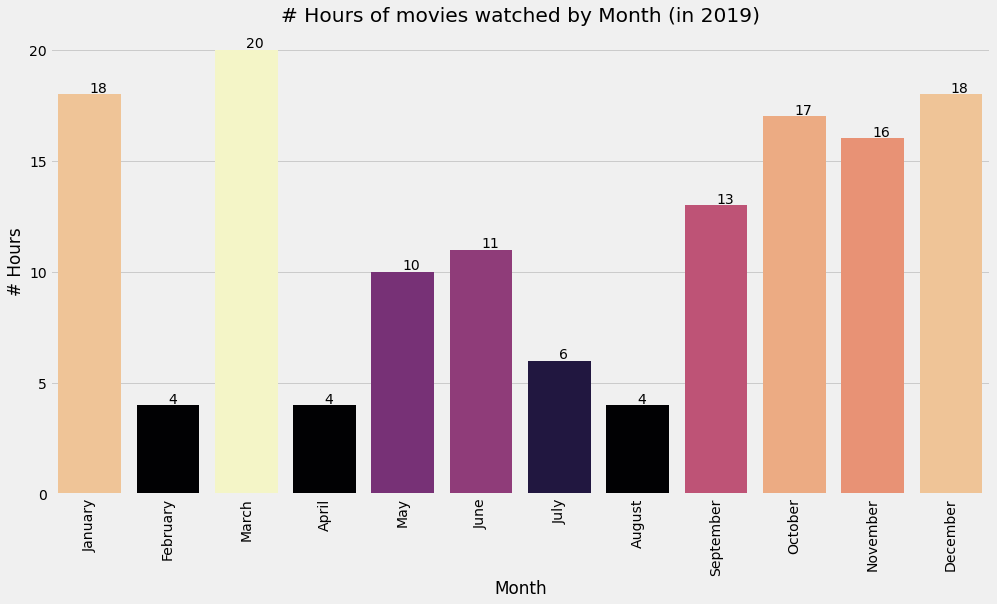

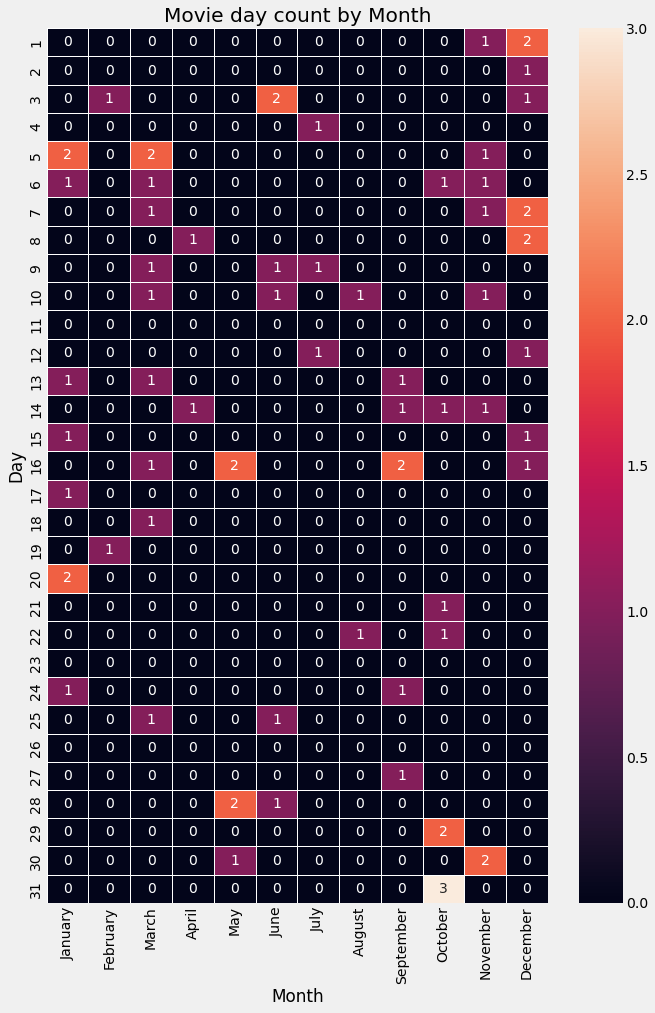

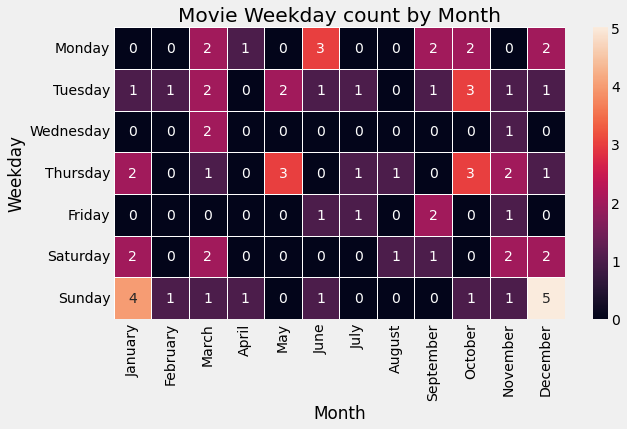

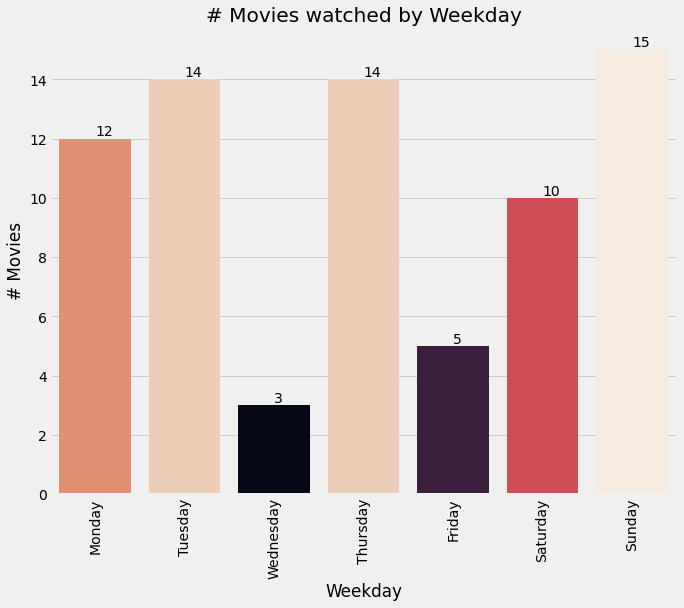

34% of the movies were watched on the weekend!



2020 



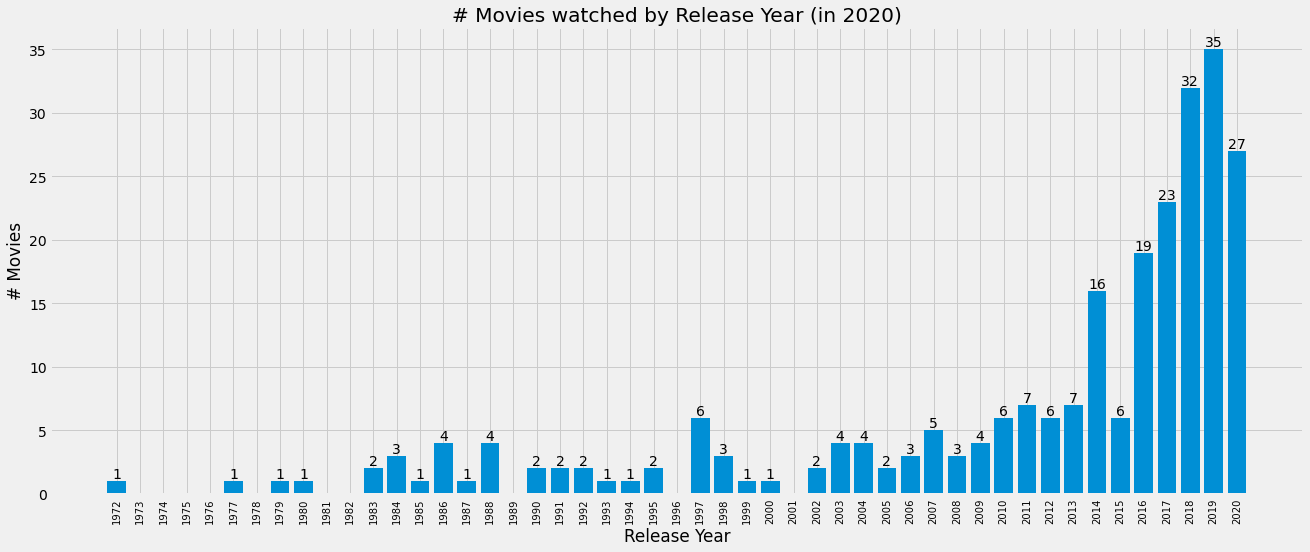

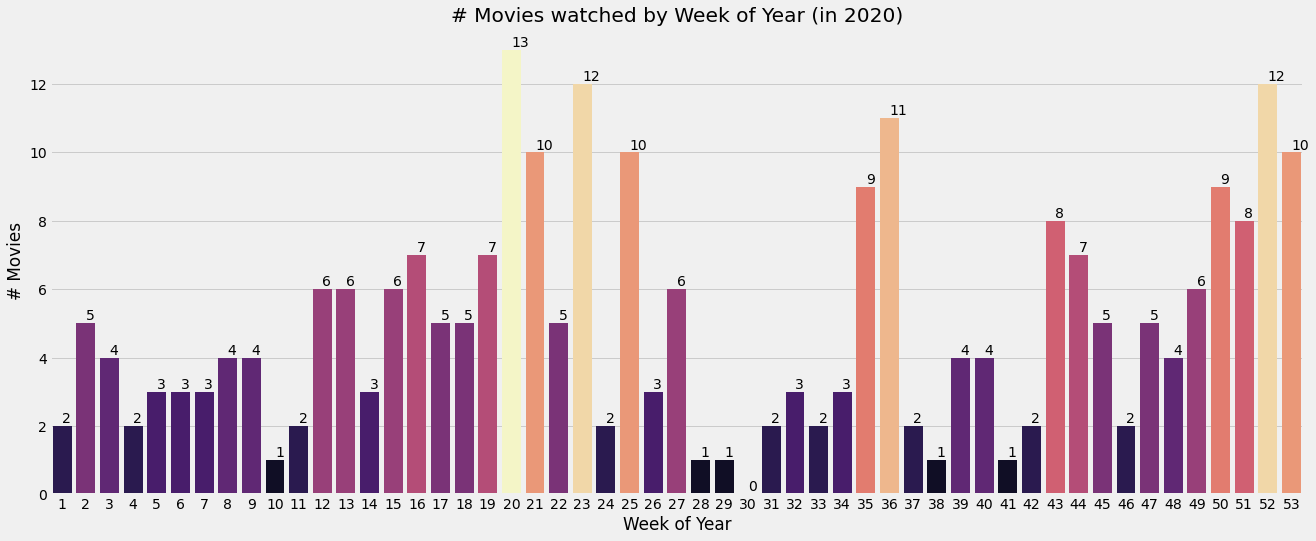

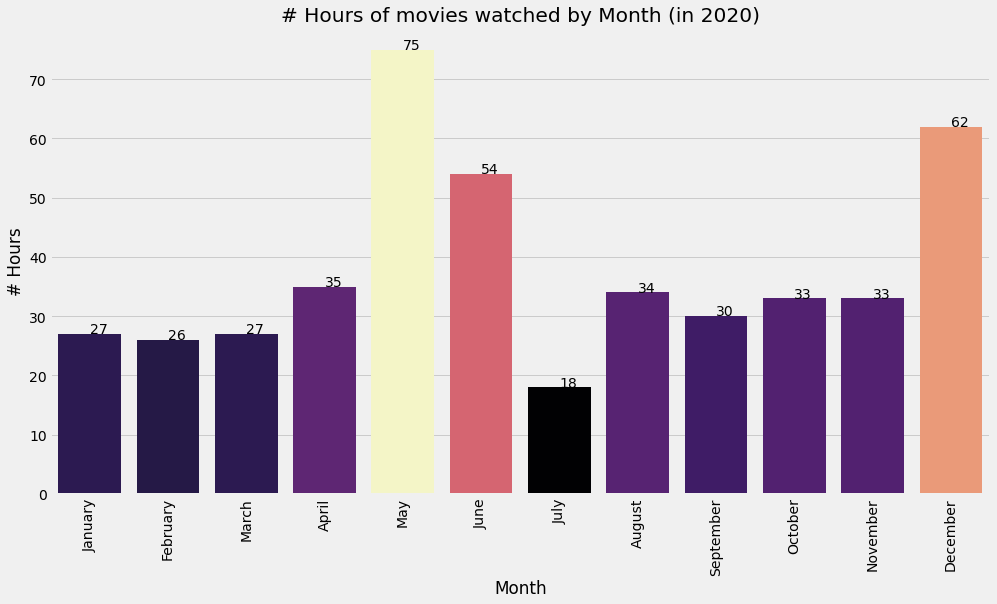

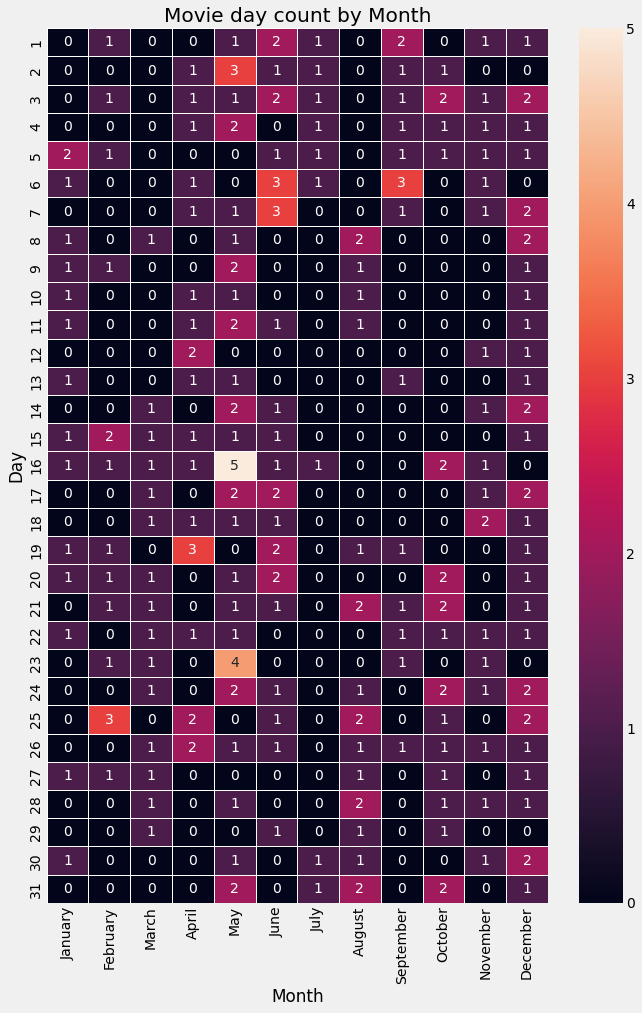

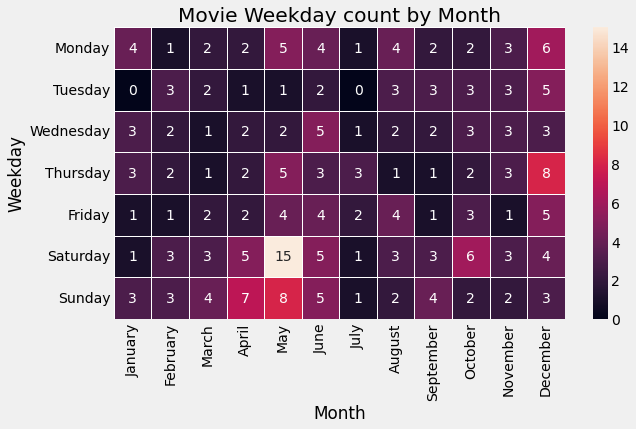

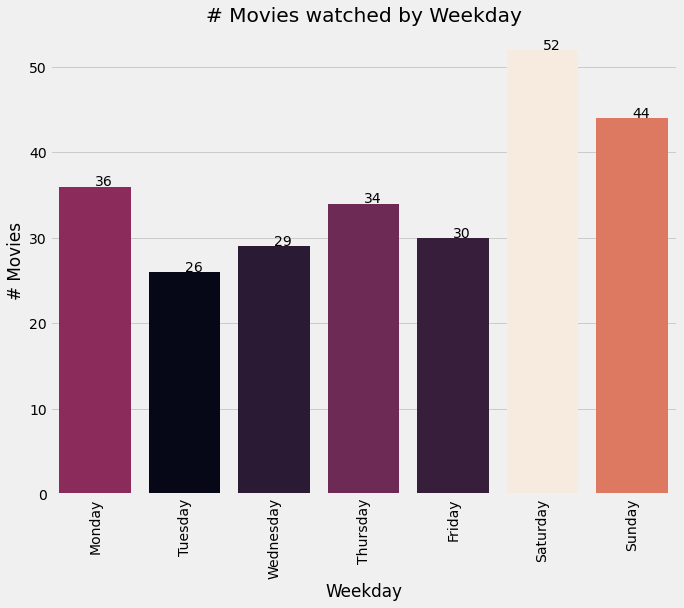

38% of the movies were watched on the weekend!



2021 



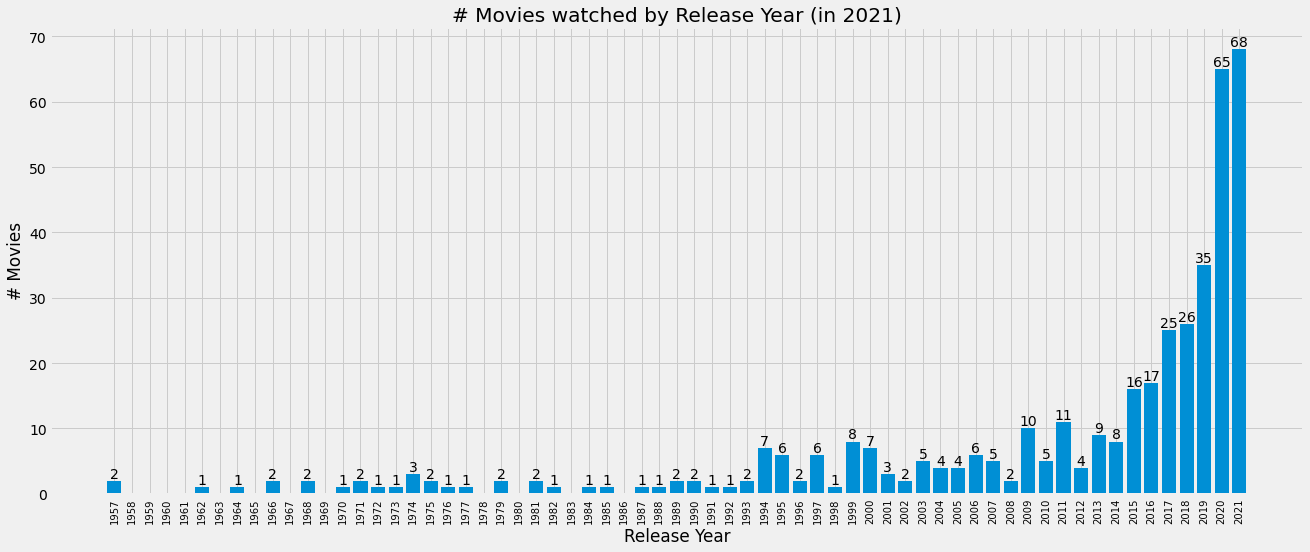

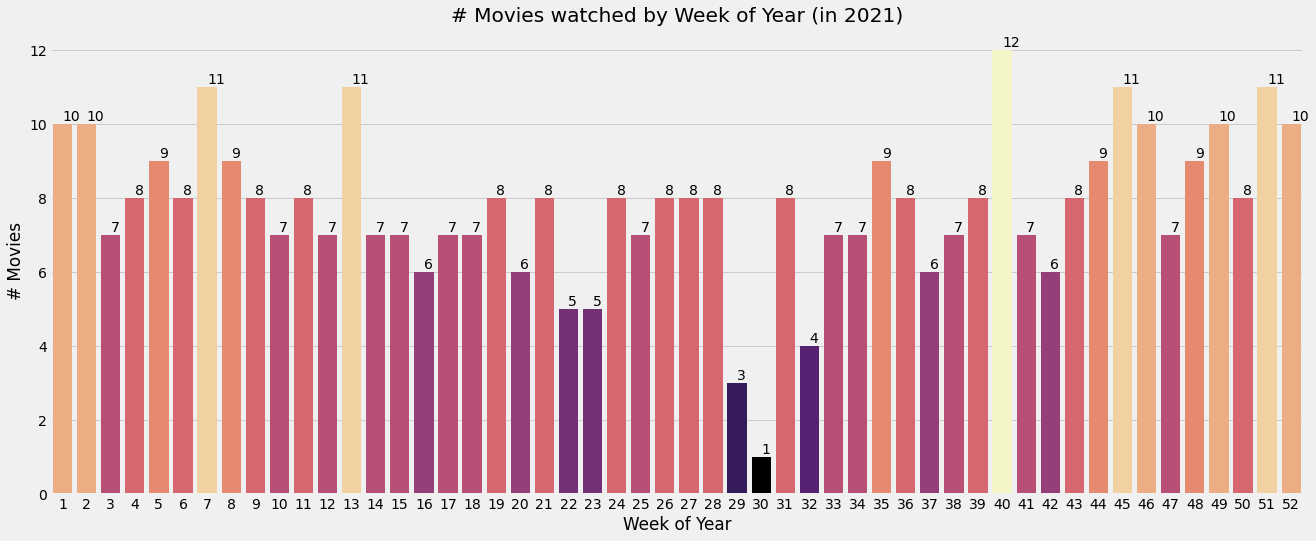

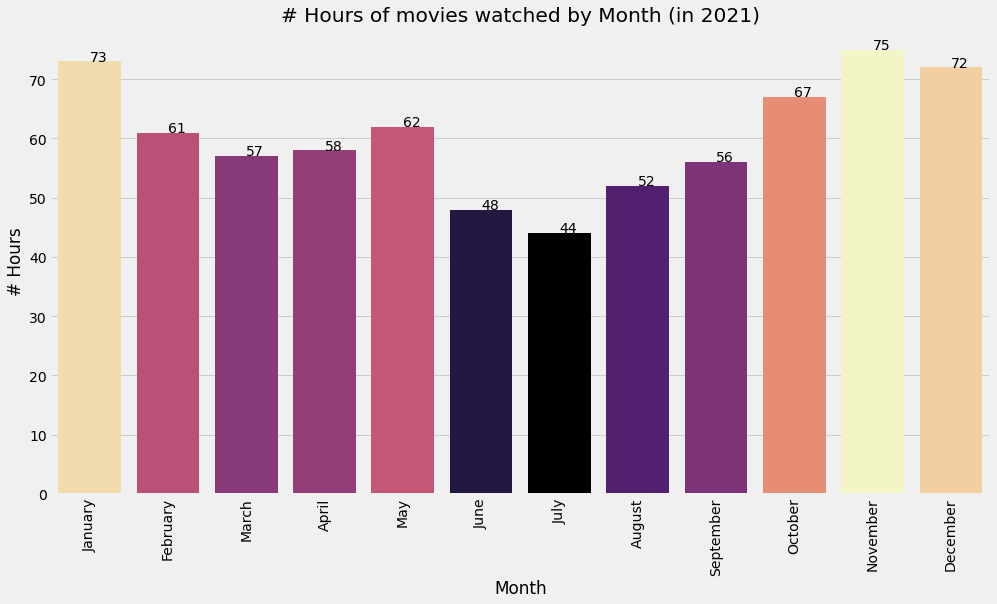

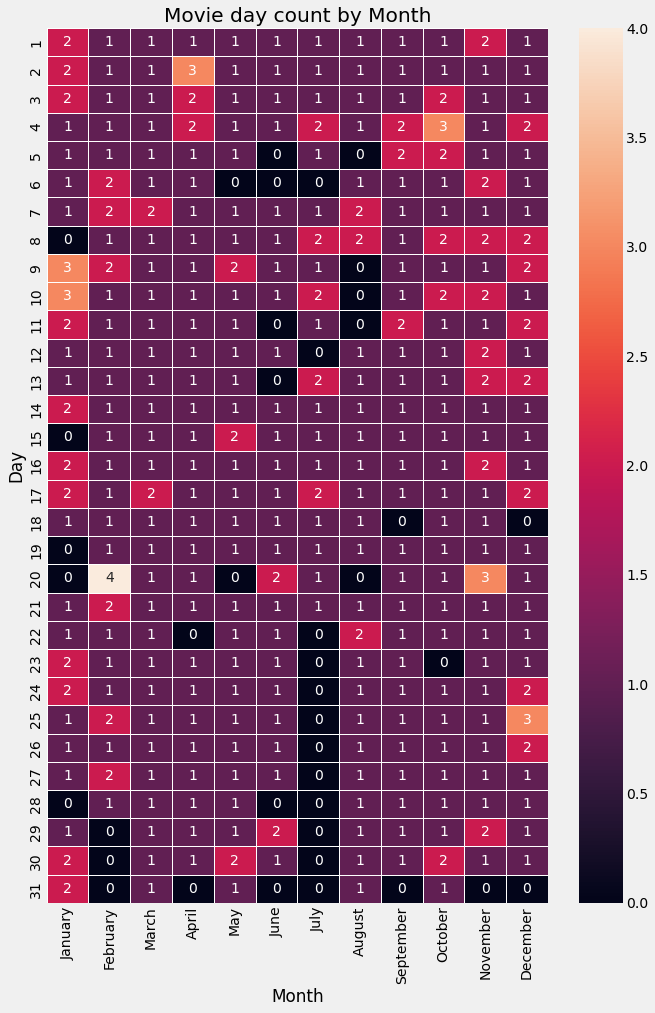

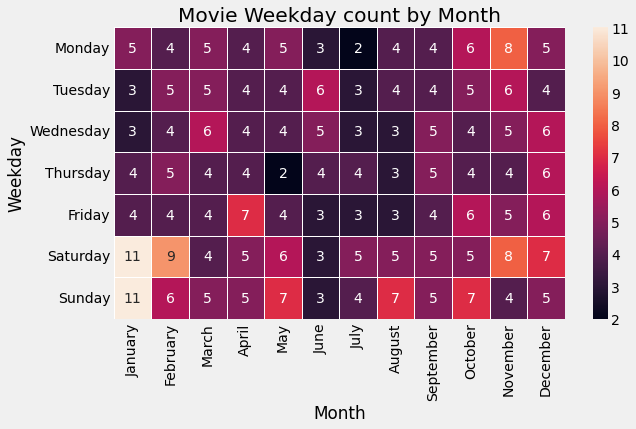

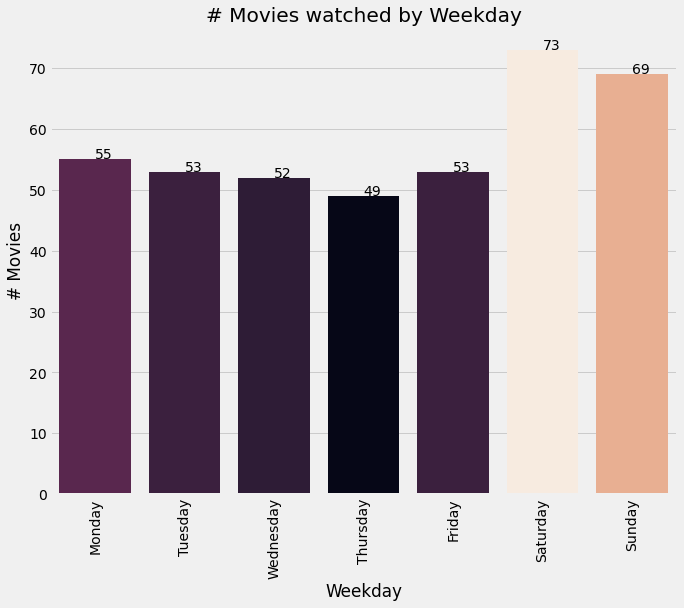

35% of the movies were watched on the weekend!



2022 



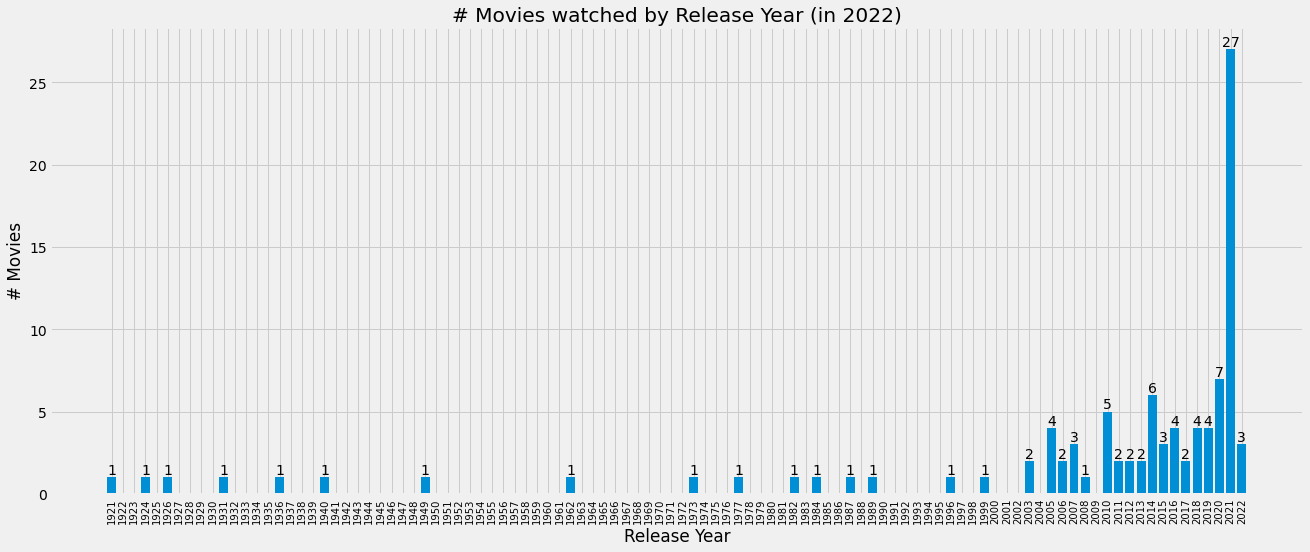

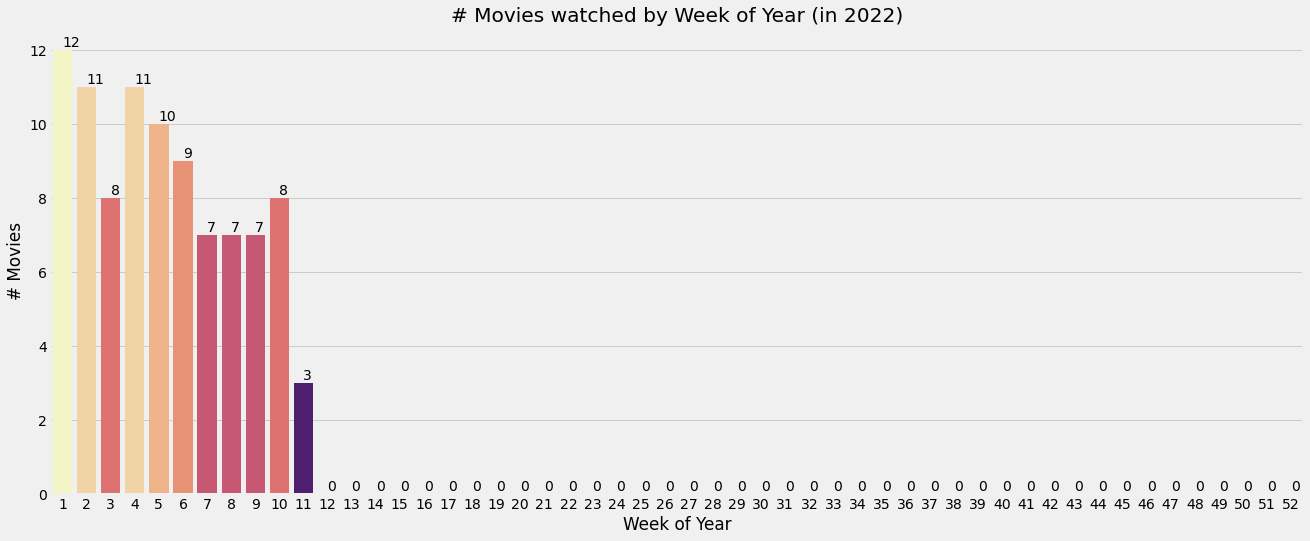

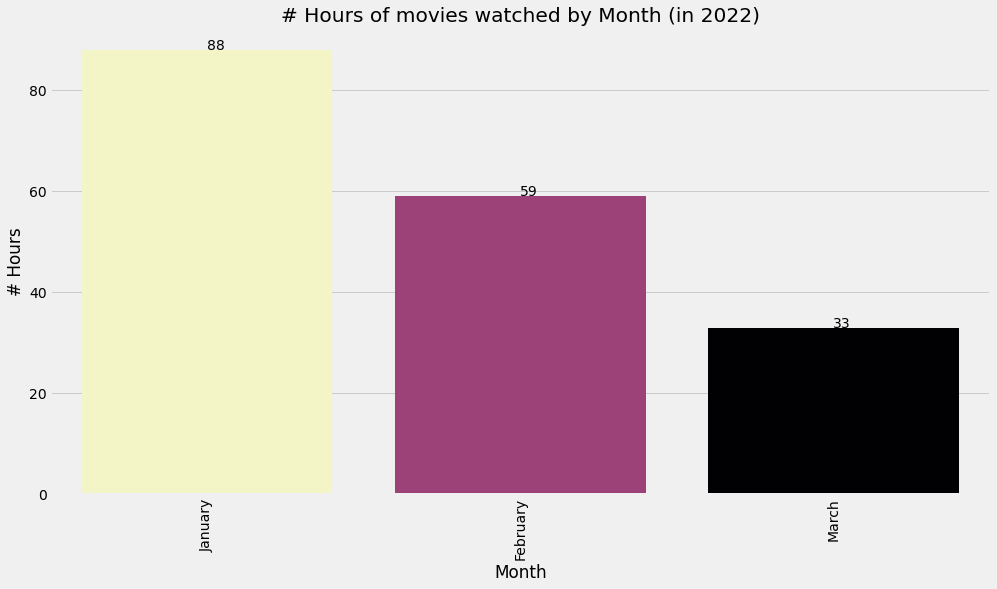

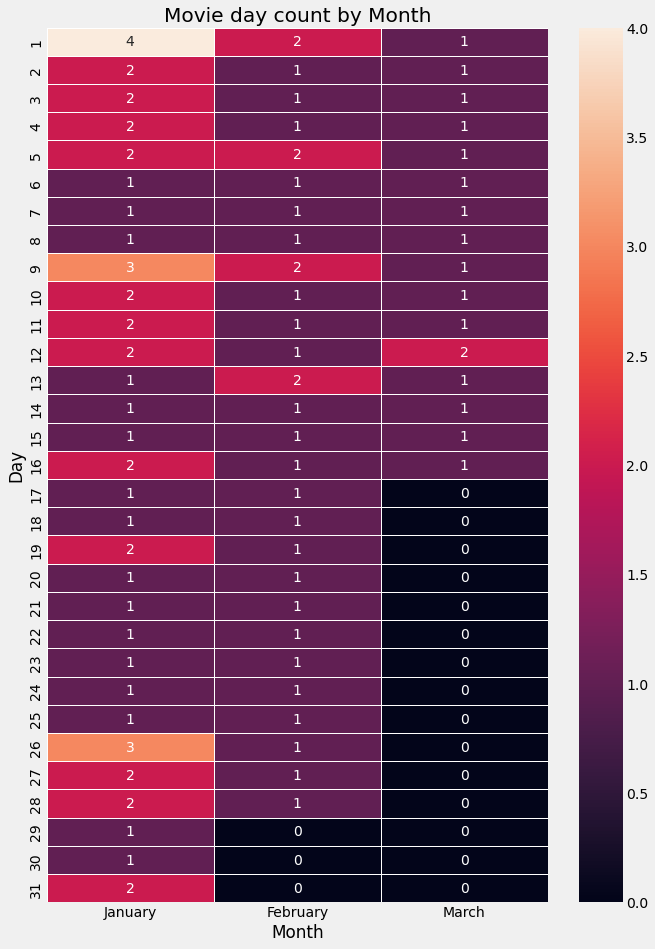

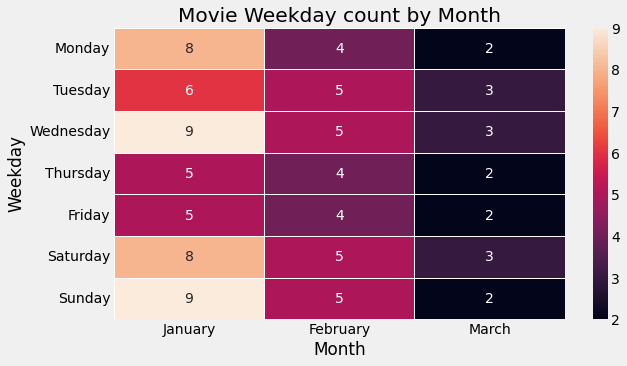

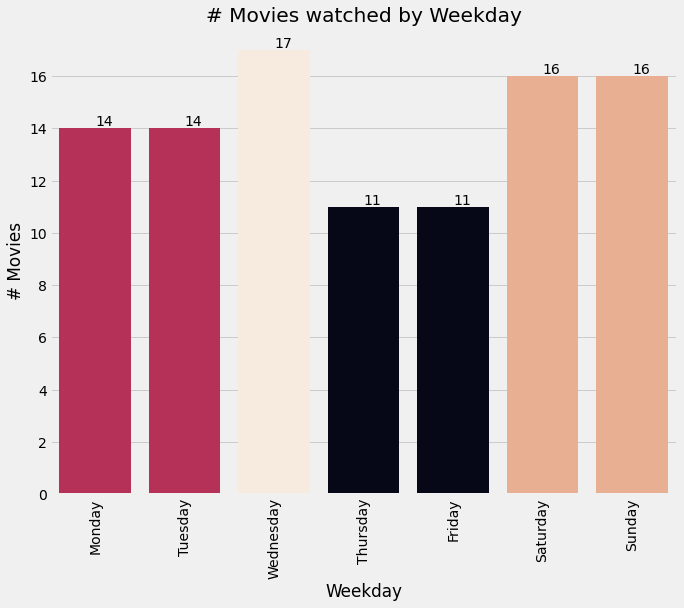

32% of the movies were watched on the weekend!





In [40]:
# Get overview by year (since 2020)
cols = ['Title','Year','Genre','Director','imdbRating','Date']
df_top_movies = df[~df.Genre.str.contains('Documentary')][~df.duplicated(['Title','Year'], keep='first')]

[
    [print(year,'\n'), 
     # remove movies watched more than once for this view
     show_all(df_top_movies[df_top_movies.Date.dt.year == year][cols].nlargest(N, 'imdbRating', keep='all')),
          
     plot_movie_trend(df, year),
     
     plot_week_bar(df, year),
     plot_month_bar(df, year),

     plot_ct_heatmap(df, 'Month', year),
     plot_ct_heatmap(df, 'Weekday', year),
     plot_weekday_bar(df, year), 

     plt.show(),
     ratio_weekend(df, year),
     print('\n\n')] 
    for year in years
];

In [41]:
# Calendar - month days
first_year = str(df.Date.dt.year.min())
calendar = pd.DataFrame({'date': pd.date_range(first_year+'-01', now, freq='M')})
calendar['daysinmonths'] = calendar['date'].apply(lambda t: pd.Period(t, freq='S').days_in_month)

print('Days without any movie watched\n')
[
    [
        skip_days(df, calendar, year),
    ] 
    for year in years
];

Days without any movie watched

2018
By month: [27, 18, 19, 27, 28, 25, 30, 26, 29, 29, 23, 29]
Total: 310/365
84 %


2019
By month: [24, 26, 22, 28, 28, 25, 28, 29, 25, 25, 23, 23]
Total: 306/365
83 %


2020
By month: [17, 17, 16, 14, 7, 11, 22, 17, 17, 16, 13, 5]
Total: 172/366
46 %


2021
By month: [5, 0, 0, 1, 2, 5, 12, 5, 1, 1, 0, 2]
Total: 34/365
9 %


2022
By month: [0, 0]
Total: 0/59
0 %




In [240]:
# Days wiht most movies watched
df_temp = df.copy()

df_date = explode_date(df_temp)
df_date_movies = df_date.groupby('Date').agg({'WeekdayName':'unique', 
                                              'Title':['count','; '.join], 
                                              'Time':list, 
                                              'Runtime':[list,'sum']})

show_all(df_date_movies[df_date_movies['Title']['count'] > 2]) # days with more than 2 movies watched

In [43]:
# Best movies watched (based on imdbRating) by month
cols = ['Year','Month','MonthName','Title','imdbRating','DateYear']
SHOW = 3 # show how many movies

df_movies_by_month = df_date[~df_date.duplicated(['Title','Year'], keep='first')][cols]
df_movies_by_month = df_movies_by_month.groupby(['DateYear','Month','MonthName'], as_index=False)

df_best_movies_by_month = df_movies_by_month.apply(lambda x: x.nlargest(SHOW, 'imdbRating', keep='last'))
df_best_movies_by_month = pd.crosstab(index=df_best_movies_by_month.DateYear, 
                                      columns=[df_best_movies_by_month.Month, df_best_movies_by_month.MonthName],
                                      values=df_best_movies_by_month.Title,
                                      aggfunc=' * '.join)

df_best_movies_by_month = df_best_movies_by_month.droplevel('Month', axis=1)
show_all(df_best_movies_by_month)

In [44]:
# Average movie rating by Month
df_best_month = df_date[~df_date.duplicated(['Title','Year'], keep='first')][cols]
df_best_month = pd.crosstab(index=df_best_month.DateYear, 
                            columns=[df_best_month.Month, df_best_month.MonthName], 
                            values=df_best_month.imdbRating, 
                            aggfunc='mean') #.round(1)

df_best_month = df_best_month.droplevel('Month', axis=1)

df_best_month.style.background_gradient(axis=1).set_precision(1) # evaluate by year

---

## Recent trend

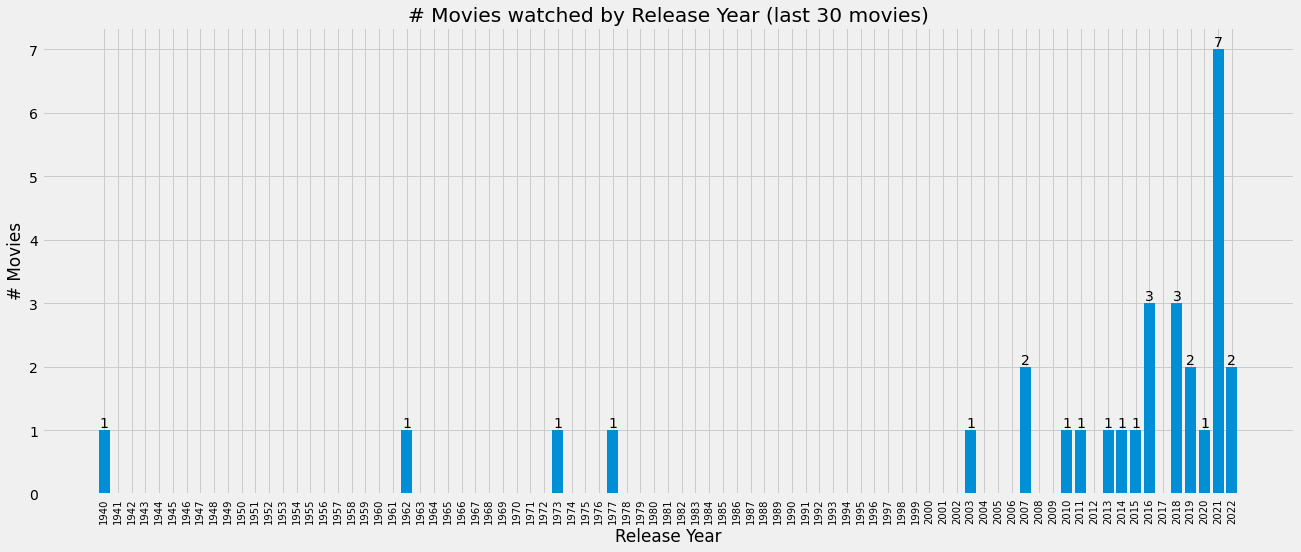

In [45]:
# Movies by Release Year (recent trend)
LAST = 30 # trakt shows last 60 movies
df_last_watched = df.tail(LAST)
plot_movies_year = df_last_watched.groupby(by='Year').agg({'Title': 'count'}).reset_index()

x = plot_movies_year.Year
y = plot_movies_year.Title

# https://towardsdatascience.com/how-to-make-bar-and-hbar-charts-with-labels-using-matplotlib-b701ce70ba9c
_, ax = plt.subplots(figsize=(20, 8))
add_ticks_vbarplot(x, y, ax)

plt.title('# Movies watched by Release Year (last ' + str(LAST) + ' movies)')
plt.xlabel('Release Year')
plt.ylabel('# Movies')
plt.show()

In [243]:
# Last movies watched
df.tail(LAST).groupby(['Year','Title']).agg({'imdbRating':'mean', 'Director':' '.join}).style.background_gradient(subset='imdbRating').set_precision(1)

In [47]:
## Any rewatched movie in the previous 60?
#df_last_watched[df_last_watched[['Title','Year','Director']].duplicated(keep=False)]

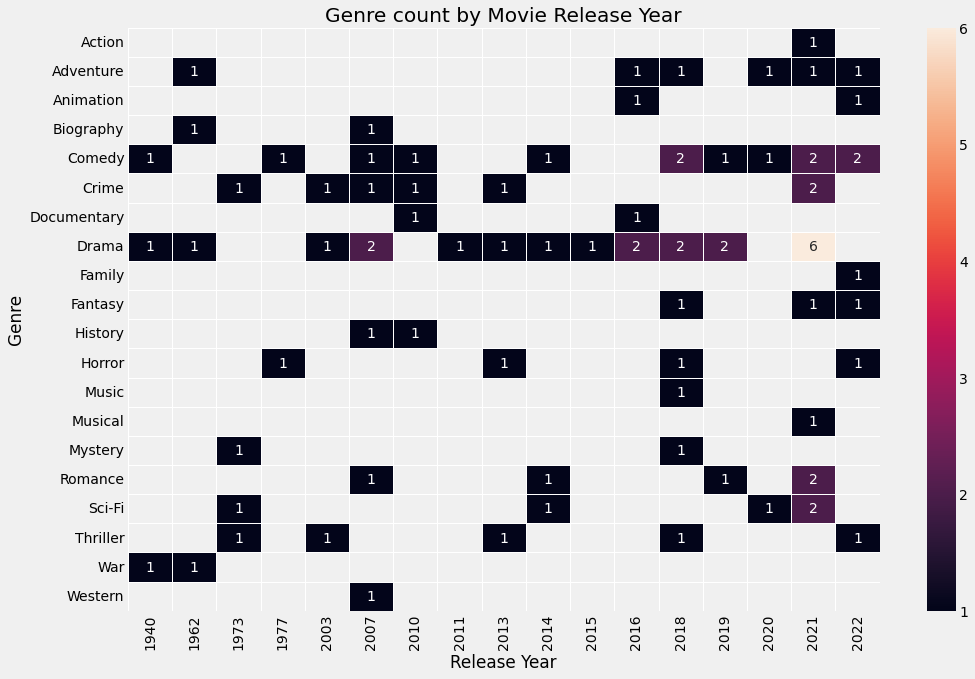

In [48]:
# Movies by Genre per Release Year (recent trend)
cols = ['Title','Year','Genre','imdbRating']

df_genre_year = df[cols].copy()
df_genre_year.Genre = df_genre_year.Genre.str.split(',').apply(lambda x: [e.strip() for e in x])

df_plot_genres = df_genre_year.tail(LAST)
plot_last_genres = explode(df_plot_genres, ['Genre'])
plot_last_genres = plot_last_genres.groupby(['Year','Genre']).agg({'Title':'count'}).sort_values(['Year','Title'], ascending=False)
plot_ct_last_genres = plot_last_genres.unstack().T.reset_index().set_index('Genre').drop(['level_0'], axis=1)

# Plot
_, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(plot_ct_last_genres, annot=True, linewidths=.5, ax=ax)
ax.set_xticklabels(plot_ct_last_genres.columns, rotation=90) 

plt.title('Genre count by Movie Release Year')
plt.xlabel('Release Year');

In [49]:
# Movies by Genre (recent trend)
df_plot_genres = df_genre_year.tail(LAST)

plot_last_genres = explode(df_plot_genres, ['Genre'])
plot_last_genres = plot_last_genres.groupby(['Genre']).agg({'Title':'count'}).sort_values(['Title'], ascending=False)
plot_last_genres

Title
Genre             
Drama           21
Comedy          13
Crime            7
Adventure        6
Romance          5
Thriller         5
Sci-Fi           5
Horror           4
Fantasy          3
History          2
Animation        2
Biography        2
Documentary      2
War              2
Mystery          2
Action           1
Musical          1
Music            1
Family           1
Western          1

In [50]:
# Movies by Director (recent trend )
gb_last = df.tail(LAST).groupby('Director').agg({'Title':[list,'count'], 'imdbRating':'mean'})
gb_last = gb_last.sort_values([('Title','count'), ('imdbRating','mean')], ascending=False).head(N)
gb_last[('imdbRating','mean')] = gb_last[('imdbRating','mean')].round(1)

show_all(gb_last)

In [51]:
## Last watched movies timestamp
df_last_ts = df_timestamp.tail(LAST).copy()
ct_last_ts_hour = pd.crosstab([df_last_ts.Weekday, df_last_ts.WeekdayName], df_last_ts.Hour)
ct_last_ts_hour = ct_last_ts_hour.droplevel(0)

ct_last_ts_hour.style.background_gradient(axis=None) # all values

---

## Timestamp

In [245]:
ct_ts_week_hour = pd.crosstab([df_timestamp.Weekday, df_timestamp.WeekdayName], df_timestamp.Hour)
## if period less than 60 min [df_timestamp.Hour, df_timestamp.Period]
ct_ts_week_hour = ct_ts_week_hour.droplevel(0)

ct_ts_week_hour.style.background_gradient(axis=1) # evaluate by weekday

In [53]:
ct_ts_month_hour = pd.crosstab([df_timestamp.Month, df_timestamp.MonthName], df_timestamp.Hour)
## if period less than 60 min [df_timestamp.Hour, df_timestamp.Period]
ct_ts_month_hour = ct_ts_month_hour.droplevel(0)

ct_ts_month_hour.style.background_gradient(axis=1) # evaluate by month

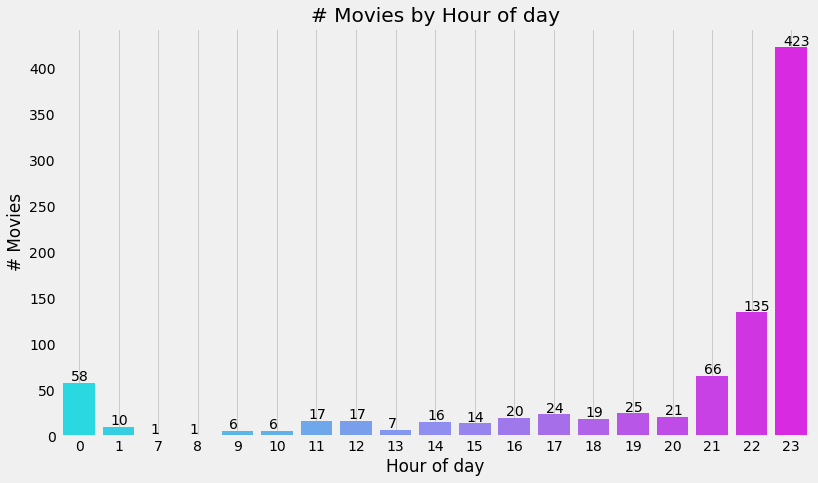

In [54]:
# Movies watched by hour of day (0-24)
plot_hour_day = df_timestamp.groupby('Hour').agg({'Title':'count'}).reset_index()

plt.figure(figsize=(12,7))
sns.barplot('Hour', 'Title', data=plot_hour_day, palette='cool', orient='v');
plt.grid()

plt.xlabel('Hour of day')
plt.ylabel('# Movies')
plt.title('# Movies by Hour of day')

for i, rate in enumerate(plot_hour_day["Title"]):
    plt.text(i-0.2, rate+2, rate)

2018 



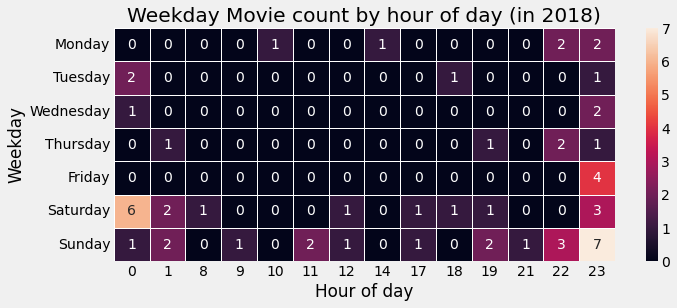



2019 



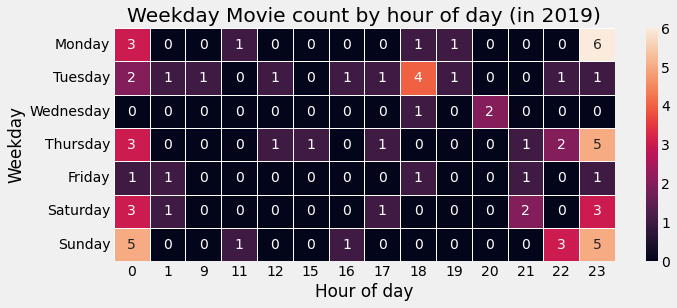



2020 



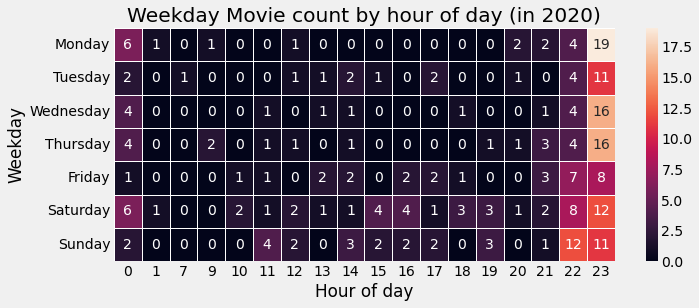



2021 



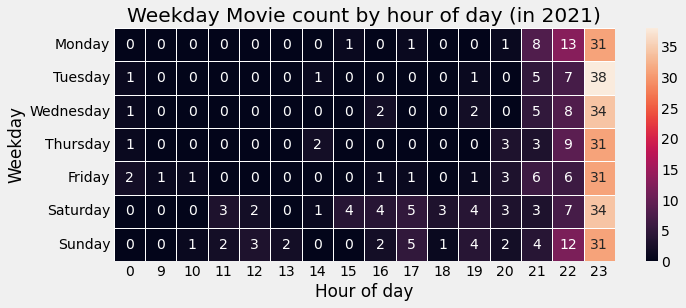



2022 



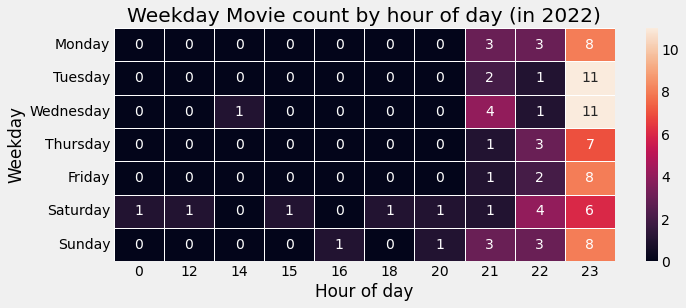

In [55]:
# Get overview by Year (since 2020)
for year in years:
    plot_hour_weekday_year = df_timestamp[df_timestamp.Timestamp.dt.year == year]
    
    print(year,'\n') 
    plot_hour_weekday_year = pd.crosstab([plot_hour_weekday_year.Weekday, plot_hour_weekday_year.WeekdayName], plot_hour_weekday_year.Hour)
    plot_hour_weekday_year = plot_hour_weekday_year.droplevel(0)
    
    # Plot
    _, ax = plt.subplots(figsize=(10, 4))
    sns.heatmap(plot_hour_weekday_year, annot=True, fmt="d", linewidths=.5, ax=ax)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0);
    plt.title('Weekday Movie count by hour of day (in ' + str(year) + ')')
    plt.xlabel('Hour of day')
    plt.ylabel('Weekday')
    plt.show()

    print('\n')

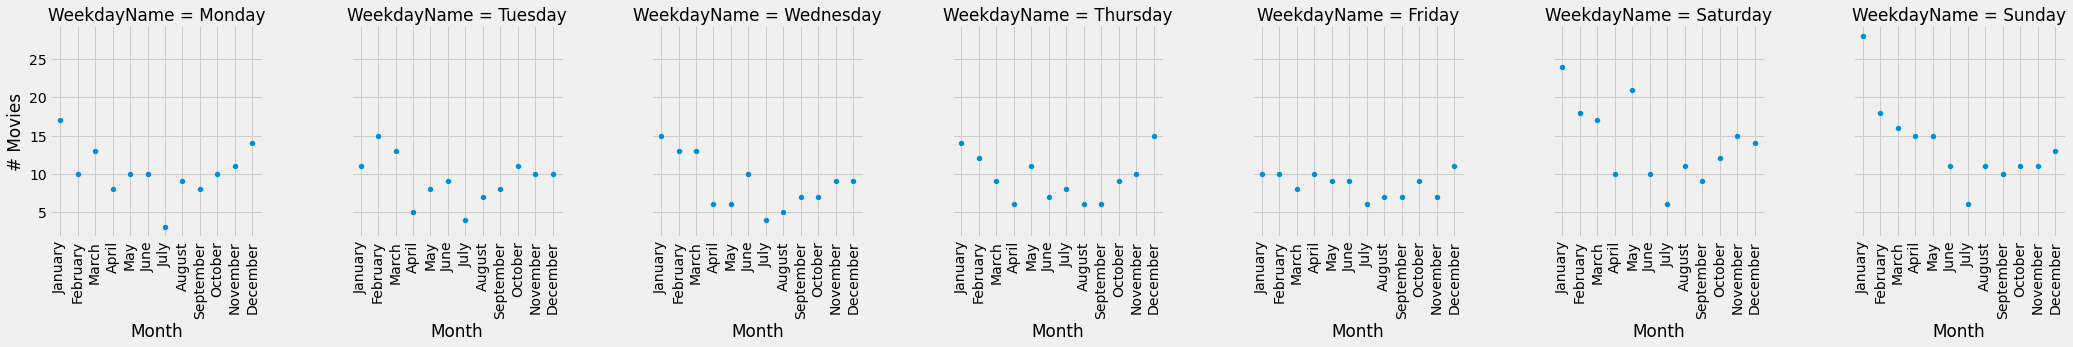

In [56]:
# Movies watched by Weekday / Month
cols = ['Month','MonthName','Weekday','WeekdayName']
gb_timestamp = df_timestamp.groupby(cols).agg({'Title':'count'}).reset_index()

g = sns.FacetGrid(gb_timestamp, col="WeekdayName")
g.map(sns.scatterplot, "MonthName", "Title")
g.set_axis_labels("Month", "# Movies")
g.fig.set_figheight(5)
g.fig.set_figwidth(30);

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

In [250]:
# Weekdays
df_time_genre = df_timestamp.copy()
# strip multiple genre
df_time_genre.Genre = df_time_genre.Genre.str.split(',').apply(lambda x: [e.strip() for e in x])
df_time_genre = explode(df_time_genre, ['Genre'])

week_unique_days = df_time_genre.groupby(['Weekday','WeekdayName']).agg({'Date':'nunique', 'Title':'nunique'})
week_unique_days = week_unique_days.droplevel(0)

# Sum days and movies
total_days = week_unique_days.Date.sum()
total_movies = week_unique_days.Title.sum()

print('Total days:', total_days)
print('Total movies watched:', total_movies)

week_unique_days.style.background_gradient(subset='Date')

Total days: 714
Total movies watched: 886


In [58]:
# Evaluation by genre
xcol = df_time_genre['Genre']

# Genre by Weekday
ycol = [df_time_genre['Weekday'], df_time_genre['WeekdayName']]
pd.crosstab(xcol, ycol).droplevel(0, axis=1).style.background_gradient(axis=1) # evaluate by genre

In [59]:
# Genre by Month
ycol = [df_time_genre['Month'], df_time_genre['MonthName']]
pd.crosstab(xcol, ycol).droplevel(0, axis=1).style.background_gradient(axis=1) # evaluate by genre

## Release Year

In [60]:
# Set release year dataframe
cols = ['Title','Year','Runtime','Genre','Director','Metascore','imdbRating','imdbVotes','Date']

df_release_year = df[cols].copy()

In [61]:
# Last watched movies
N = 10

df_release_year[['Title','Year']].tail(N)

Title  Year
885                             Elephant  2003
886                                House  1977
887  The Last Black Man in San Francisco  2019
888            The Many Saints of Newark  2021
889              Spider-Man: No Way Home  2021
890                          Turning Red  2022
891                   Lawrence of Arabia  1962
892                     Save Yourselves!  2020
893                                Comet  2014
894                             Plus One  2019

In [253]:
# Movies by Release Year
df_group_year = df_release_year.groupby(by='Year').agg({'Title': 'count',
                                                        'Runtime': np.mean,
                                                        'imdbRating': 'mean'}
                                                      ).sort_values(by=['Title'], ascending=False).round(1)

df_group_year['Runtime'] = df_group_year.Runtime.round(0).astype(int)

show_all(df_group_year.style.background_gradient(subset='imdbRating').set_precision(1))

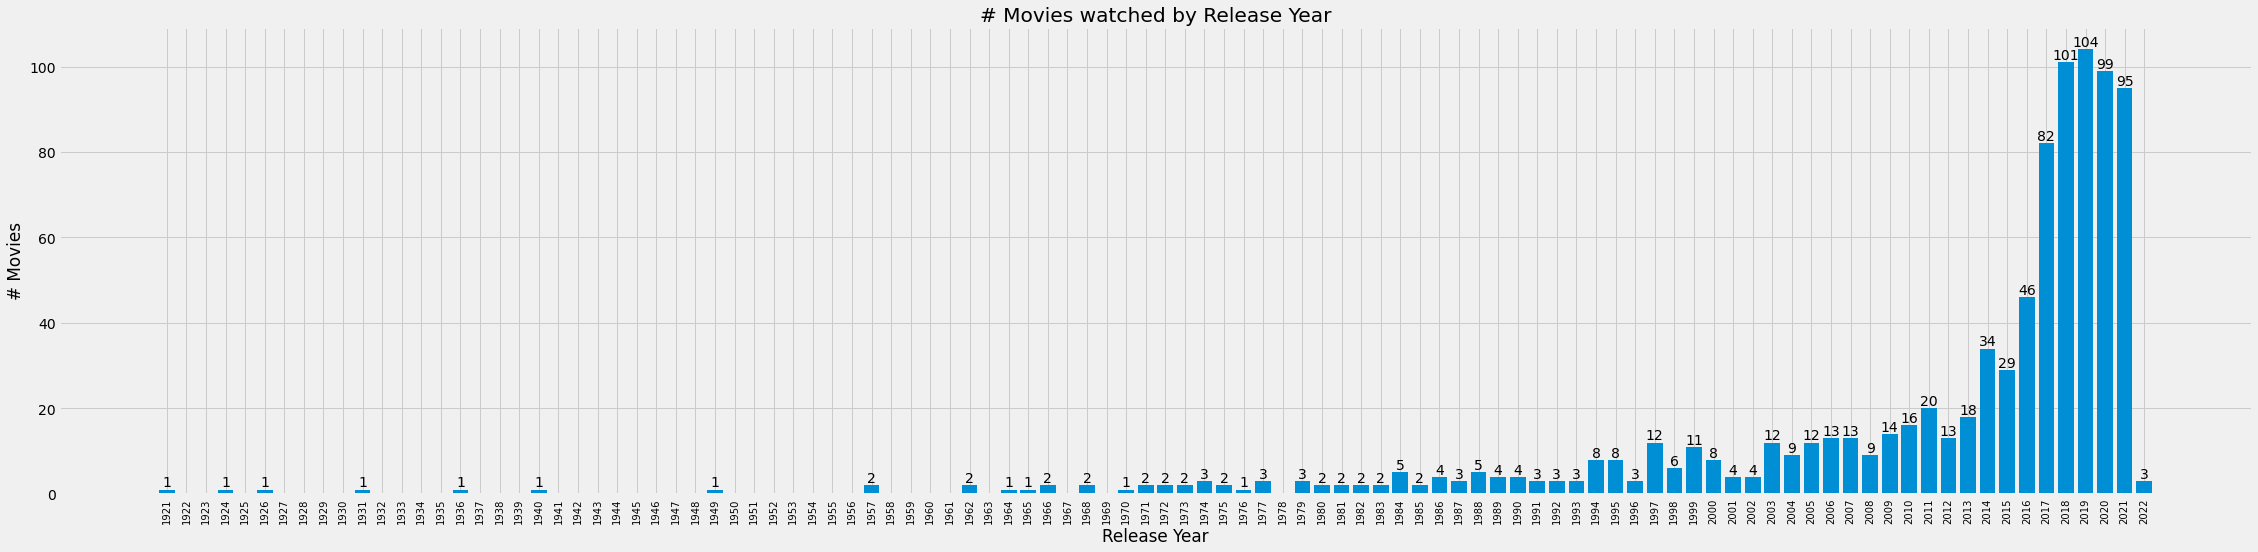

In [63]:
# Movies by Release Year
plot_movies_year = df_group_year.reset_index().sort_values('Year')

x = plot_movies_year.Year
y = plot_movies_year.Title

# https://towardsdatascience.com/how-to-make-bar-and-hbar-charts-with-labels-using-matplotlib-b701ce70ba9c
_, ax = plt.subplots(figsize=(35, 8))
add_ticks_vbarplot(x, y, ax)

plt.title('# Movies watched by Release Year')
plt.xlabel('Release Year')
plt.ylabel('# Movies')
plt.show()

In [64]:
# Search by specific year
YEAR = 2002
df_release_year.groupby(by='Year').get_group(YEAR)

Title  Year  Runtime  \
201                Irreversible  2002       97   
295         Catch Me If You Can  2002      141   
483  Sympathy for Mr. Vengeance  2002      129   
546            Punch-Drunk Love  2002       95   

                                Genre              Director  Metascore  \
201   Crime, Drama, Mystery, Thriller            Gaspar Noé         51   
295           Biography, Crime, Drama      Steven Spielberg         75   
483            Crime, Drama, Thriller        Park Chan-wook         56   
546  Comedy, Drama, Romance, Thriller  Paul Thomas Anderson         78   

     imdbRating  imdbVotes       Date  
201         7.3     130102 2020-05-02  
295         8.1     924673 2020-08-31  
483         7.6      67394 2021-03-19  
546         7.3     160094 2021-05-17

In [65]:
# Top movies watched from last year (release year == last year)
latest_year = now.year - 1 

if len(df_release_year[df_release_year.Year == latest_year]) != 0:
    print(str(latest_year))
    df_latest_year = df_release_year.groupby(by='Year').get_group(latest_year)[df_release_year.Year == latest_year].drop_duplicates('Title')
    df_latest_year = df_latest_year.sort_values(['imdbRating','imdbVotes'], ascending=[False, False])
    
    show_all(df_latest_year)
else:
    None

2021


In [66]:
# Best movies by Release Year
BEST = 3
condition = 'Documentary' # remove this genre
cols = ['Title','Year','Runtime','imdbRating','imdbVotes']

# Top movies
df_top_movies_year = df_release_year[~df_release_year.Genre.str.contains(condition)][cols].groupby(['Year','Title']).mean().sort_values(['Year','imdbRating'], ascending=False)
df_top_movies_year = df_top_movies_year.groupby(level=0, as_index=False).apply(lambda x: x.nlargest(BEST, 'imdbRating', keep='all')).reset_index(level=0, drop=True)

df_top_movies_year[['Runtime','imdbVotes']] = df_top_movies_year[['Runtime','imdbVotes']].astype(int)

show_all(df_top_movies_year)

In [67]:
# Top documentaries by Release Year
df_top_docs_year = df_release_year[df_release_year.Genre.str.contains(condition)][cols].groupby(['Year','Title']).mean().sort_values(['Year','imdbRating'], ascending=False)
df_top_docs_year = df_top_docs_year.groupby(level=0, as_index=False).apply(lambda x: x.nlargest(BEST, 'imdbRating', keep='all')).reset_index(level=0, drop=True)

df_top_docs_year[['Runtime','imdbVotes']] = df_top_docs_year[['Runtime','imdbVotes']].astype(int)

show_all(df_top_docs_year)

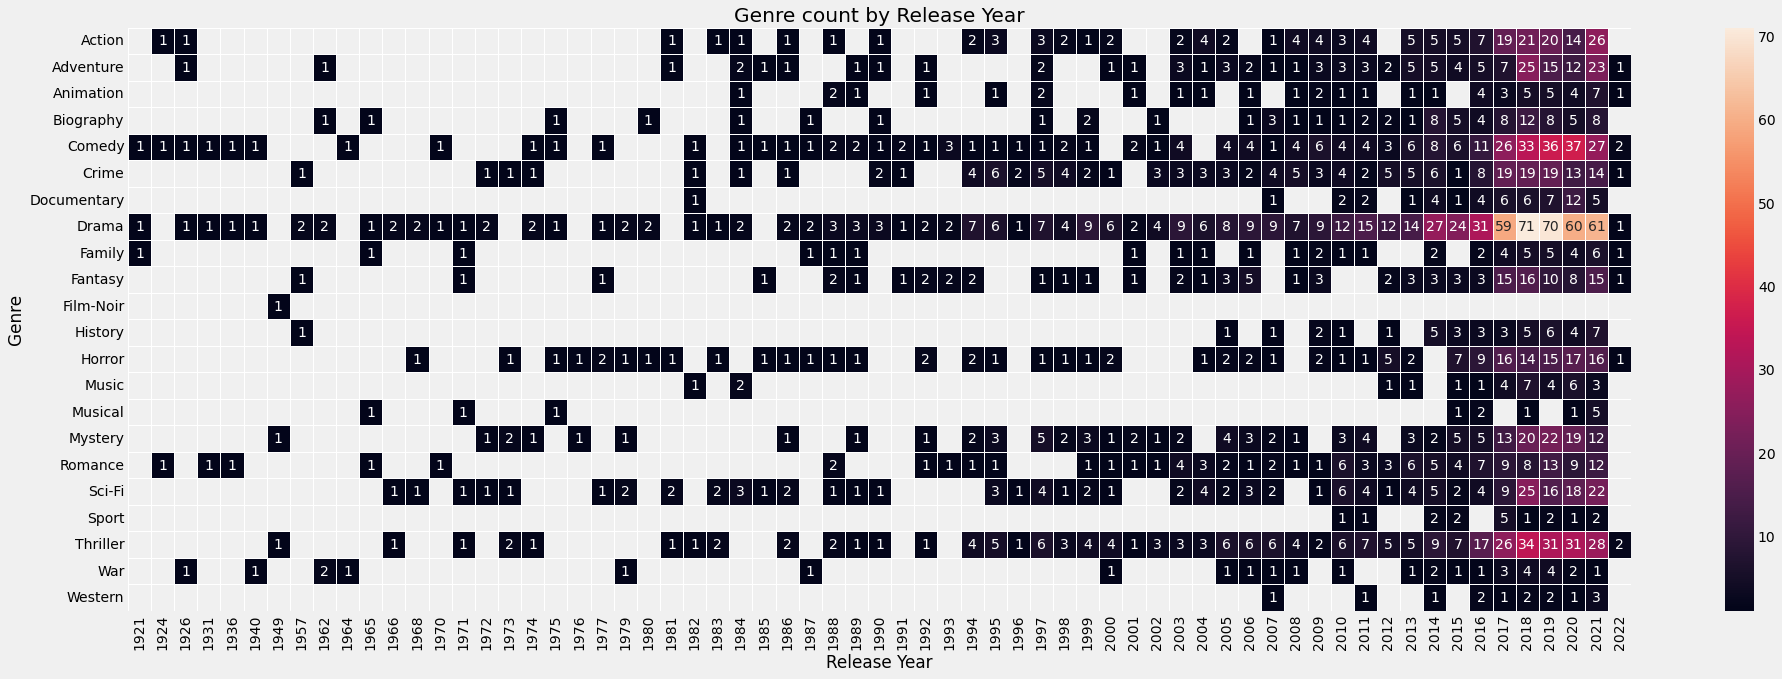

In [68]:
# Genre count by Release Year
plot_genre_year = explode(df_genre_year, ['Genre'])
plot_genre_year = plot_genre_year.groupby(['Year','Genre']).agg({'Title':'count'}).sort_values(['Year','Title'], ascending=False)
plot_ct_genre_year = plot_genre_year.unstack().T.reset_index().set_index('Genre').drop(['level_0'], axis=1)

# Plot
_, ax = plt.subplots(figsize=(30, 10))
ax = sns.heatmap(plot_ct_genre_year, annot=True, linewidths=.5, ax=ax)
plt.title('Genre count by Release Year')
plt.xlabel('Release Year')

ax.set_xticklabels(ax.get_xticklabels(),rotation = 90);

In [69]:
# Prepare plotting
year_list = plot_movies_year.Year
x = 'Year'

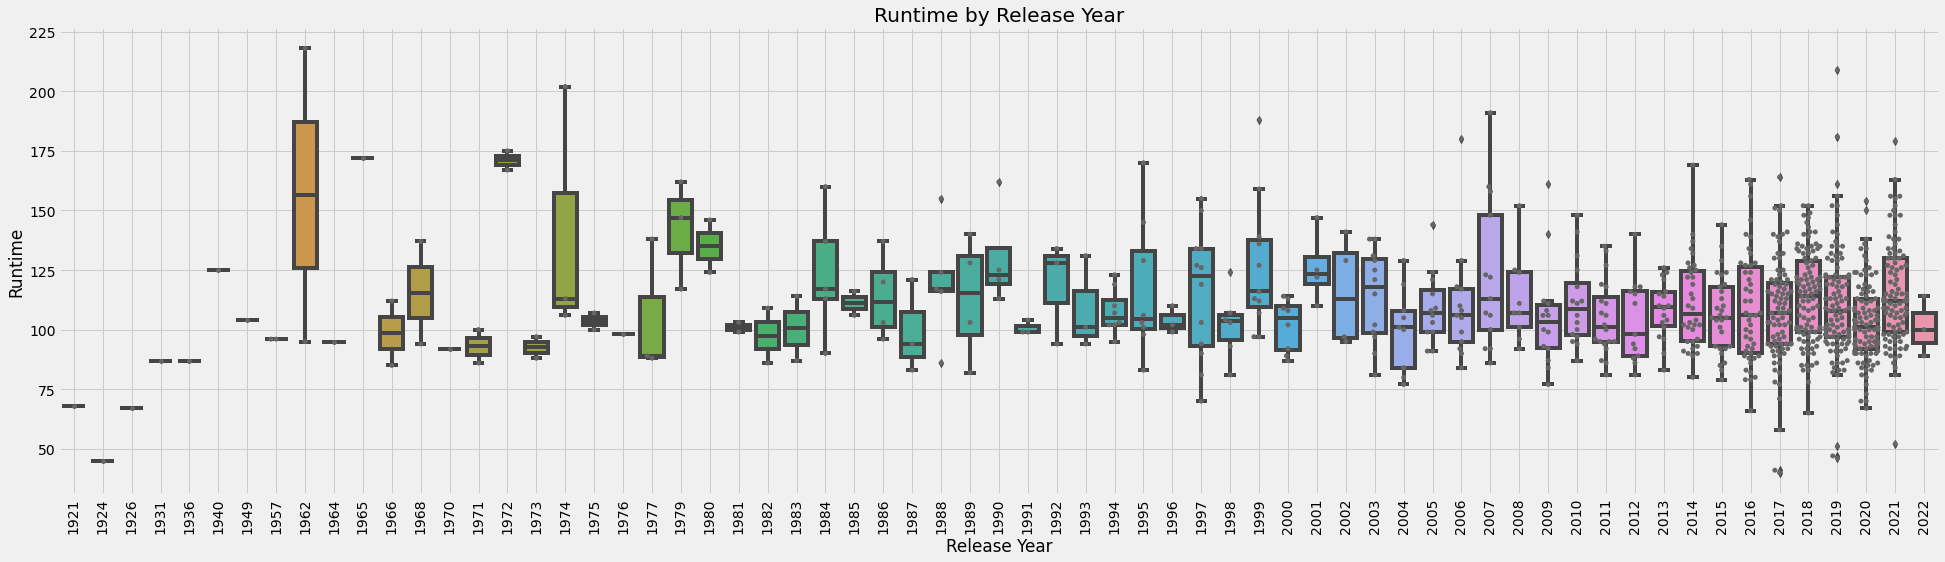

In [70]:
# Runtime by Release Year
y = 'Runtime'
plot_box_swarm(x, y, df, year_list)

In [71]:
# Time spent watching movies
runtime = df_release_year.Runtime.sum()
print(runtime.astype(int), 'minutes')
print((runtime / 60).astype(int), 'hours')
print((runtime / (60*24)).astype(int), 'days')

97721 minutes
1628 hours
67 days


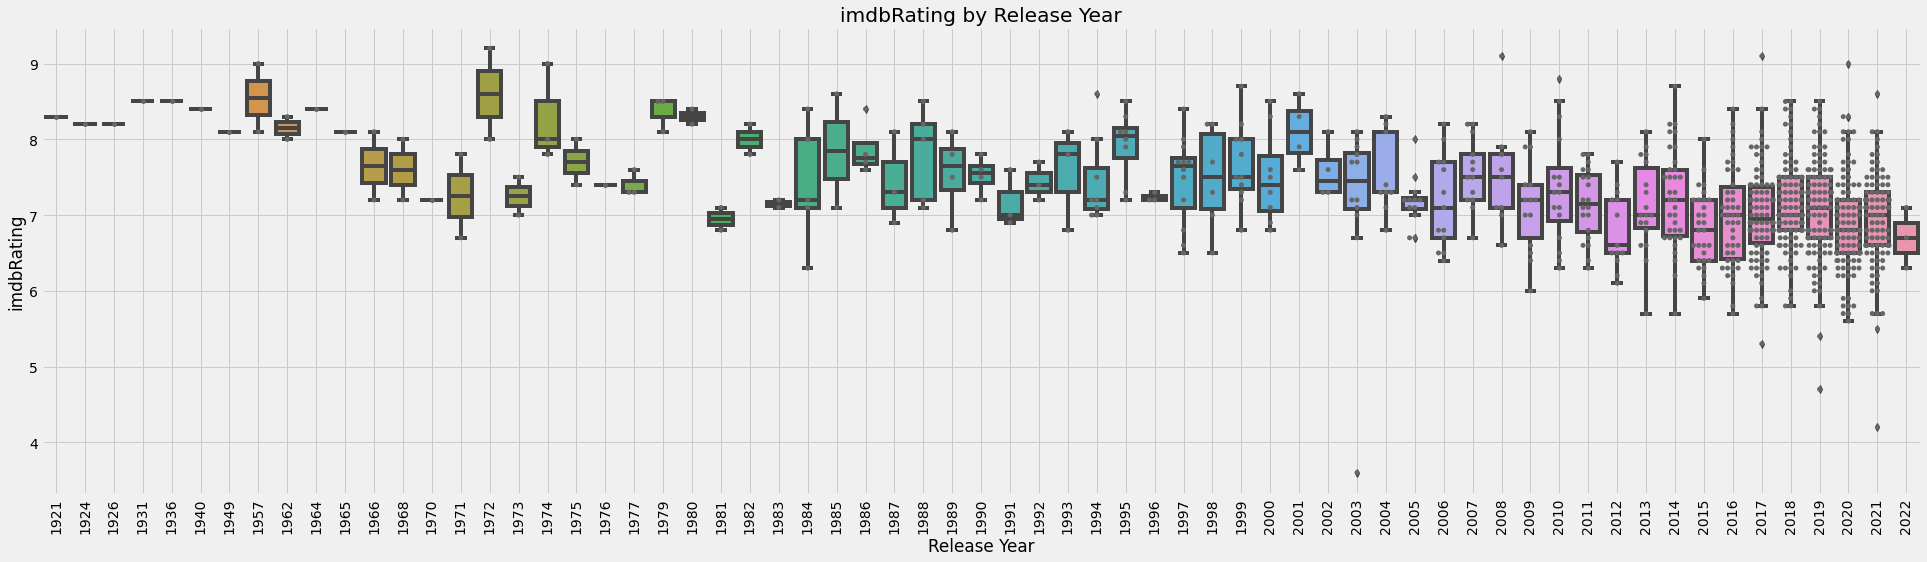

In [72]:
# imdbRating by Release Year
y = 'imdbRating'
plot_box_swarm(x, y, df, year_list)

In [73]:
# imdbRating statistics
df_release_year['imdbRating'].describe().round(2)

count    886.00
mean       7.15
std        0.67
min        3.60
25%        6.70
50%        7.10
75%        7.60
max        9.20
Name: imdbRating, dtype: float64

In [74]:
# Movies ranked in the 25th percentile minus 2 standard deviations
qtl_2std = df_release_year['imdbRating'].quantile(0.25) - 2*df_release_year['imdbRating'].std()
df_release_year[df_release_year['imdbRating'] < qtl_2std]

Title  Year  Runtime  \
169                        Geostorm  2017      109   
193                        The Room  2003       99   
204  The First Temptation of Christ  2019       46   
841      Prisoners of the Ghostland  2021      103   

                                 Genre             Director  Metascore  \
169           Action, Sci-Fi, Thriller          Dean Devlin         21   
193                              Drama         Tommy Wiseau          9   
204                             Comedy  Rodrigo Van Der Put          0   
841  Action, Fantasy, Sci-Fi, Thriller            Sion Sono         53   

     imdbRating  imdbVotes       Date  
169         5.3     104454 2020-03-21  
193         3.6      87519 2020-04-22  
204         4.7       3374 2020-05-04  
841         4.2       9484 2022-01-28

### Decade

In [75]:
# Set decade dataframe
cols = ['Title', 'Year', 'Runtime', 'imdbRating', 'Genre', 'Language']

df_decade = df[cols].copy()

In [76]:
# Movies by Decade
df_decade['Decade'] = df_decade['Year'].astype(int)//10*10 # convert to decade

movies_decade = df_decade.groupby('Decade').agg({'Title': 'count', 
                                                 'Runtime': 'mean', 
                                                 'imdbRating': 'mean'}).round(1)

movies_decade['Runtime'] = movies_decade.Runtime.round(0).astype(int)
movies_decade

Title  Runtime  imdbRating
Decade                            
1920        3       60         8.2
1930        2       87         8.5
1940        2      114         8.2
1950        2       96         8.6
1960        8      126         7.9
1970       19      120         7.8
1980       31      113         7.6
1990       61      115         7.5
2000       98      111         7.4
2010      463      110         7.1
2020      197      109         6.9

In [77]:
# Highest rating movies by Decade
BEST = 3
condition = 'Documentary' # filter this out

df_top_rating_decade = df_decade[~df_decade.Genre.str.contains(condition)] # filter out documentary 
df_top_rating_decade = df_top_rating_decade.drop_duplicates(subset=['Title','Year'], keep='first')
df_top_rating_decade = df_top_rating_decade.set_index(['Decade','Title']).sort_values(['Decade','imdbRating'], ascending=False)

df_top_rating_decade = df_top_rating_decade.groupby(level=0, as_index=False).apply(lambda x: x.nlargest(BEST, 'imdbRating', keep='all')).reset_index(level=0, drop=True)
df_top_rating_decade

Year  Runtime  \
Decade Title                                                               
1920   The Kid                                             1921       68   
       Sherlock Jr.                                        1924       45   
       The General                                         1926       67   
1930   City Lights                                         1931       87   
       Modern Times                                        1936       87   
1940   The Great Dictator                                  1940      125   
       The Third Man                                       1949      104   
1950   12 Angry Men                                        1957       96   
       The Seventh Seal                                    1957       96   
1960   Dr. Strangelove or: How I Learned to Stop Worry...  1964       95   
       Lawrence of Arabia                                  1962      218   
       The Sound of Music                                  1965      172   
       Persona                                             1966       85   
1970   The Godfather                                       1972      175   
       The Godfather: Part II                              1974      202   
       Alien                                               1979      117   
       Apocalypse Now                                      1979      147   
1980   Back to the Future                                  1985      116   
       Cinema Paradiso                                     1988      155   
       The Shining                                         1980      146   
       Aliens                                              1986      137   
       Amadeus                                             1984      160   
1990   The Matrix                                          1999      136   
       Léon: The Professional                              1994      110   
       The Usual Suspects                                  1995      106   
2000   The Dark Knight                                     2008      152   
       Spirited Away                                       2001      125   
       Memento                                             2000      113   
2010   Inception                                           2010      148   
       Interstellar                                        2014      169   
       Avengers: Infinity War                              2018      149   
       Parasite                                            2019      132   
2020   Spider-Man: No Way Home                             2021      148   
       The Father                                          2020       97   
       Soul                                                2020      100   
       CODA                                                2021      111   
       Dune                                                2021      155   

                                                           imdbRating  \
Decade Title                                                            
1920   The Kid                                                    8.3   
       Sherlock Jr.                                               8.2   
       The General                                                8.2   
1930   City Lights                                                8.5   
       Modern Times                                               8.5   
1940   The Great Dictator                                         8.4   
       The Third Man                                              8.1   
1950   12 Angry Men                                               9.0   
       The Seventh Seal                                           8.1   
1960   Dr. Strangelove or: How I Learned to Stop Worry...         8.4   
       Lawrence of Arabia                                         8.3   
       The Sound of Music                                         8.1   
       Persona                                                    8.1   

In [78]:
# Return cross-section
DEC = 1970
df_top_rating_decade.xs(DEC)

Year  Runtime  imdbRating                Genre  \
Title                                                                    
The Godfather           1972      175         9.2         Crime, Drama   
The Godfather: Part II  1974      202         9.0         Crime, Drama   
Alien                   1979      117         8.5       Horror, Sci-Fi   
Apocalypse Now          1979      147         8.5  Drama, Mystery, War   

                                                          Language  
Title                                                               
The Godfather                              English, Italian, Latin  
The Godfather: Part II  English, Italian, Spanish, Latin, Sicilian  
Alien                                                      English  
Apocalypse Now                         English, French, Vietnamese

In [79]:
# Prepare plotting
x = 'Decade'
decade_list = df_decade.sort_values('Decade').Decade.unique()

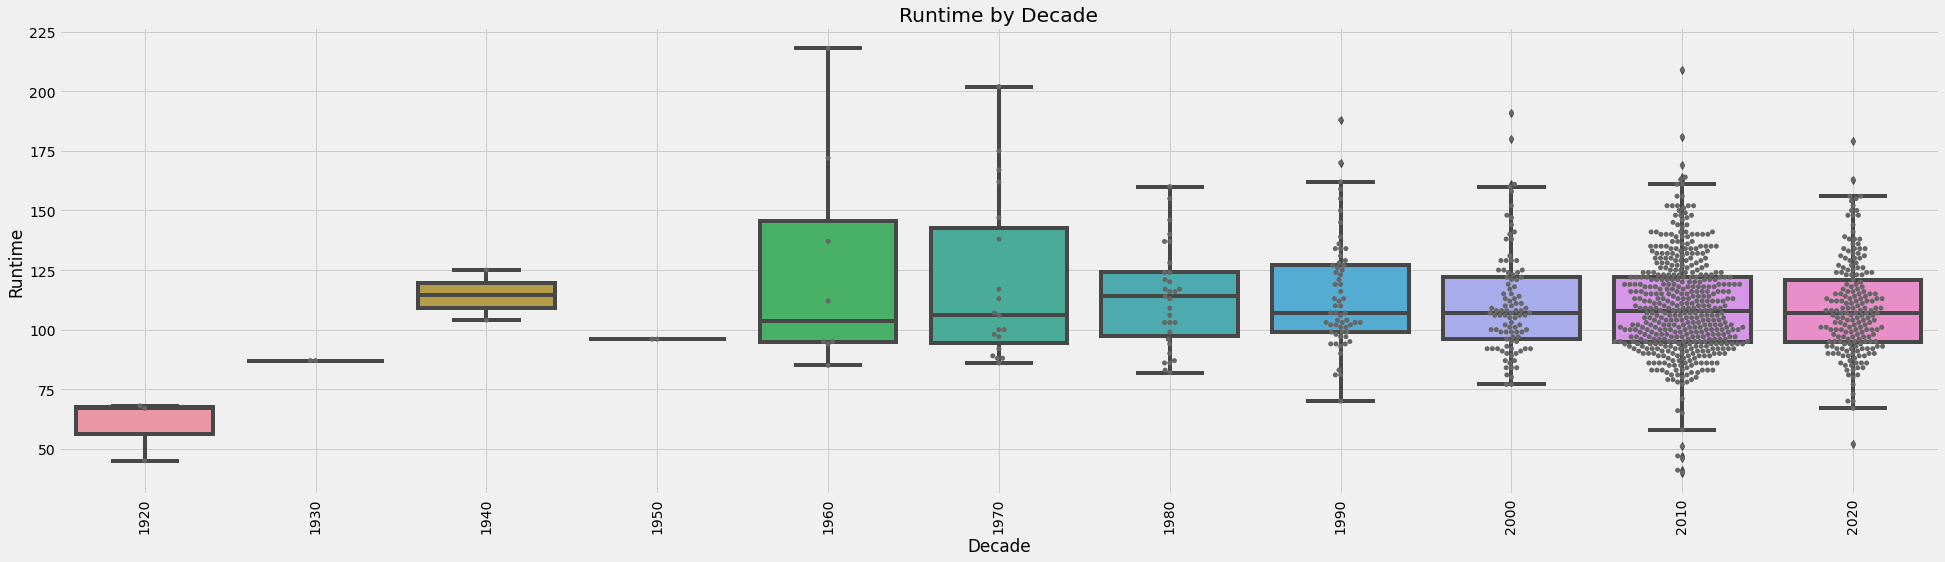

In [80]:
# Runtime by Decade
y = 'Runtime'
plot_box_swarm(x, y, df_decade, decade_list)

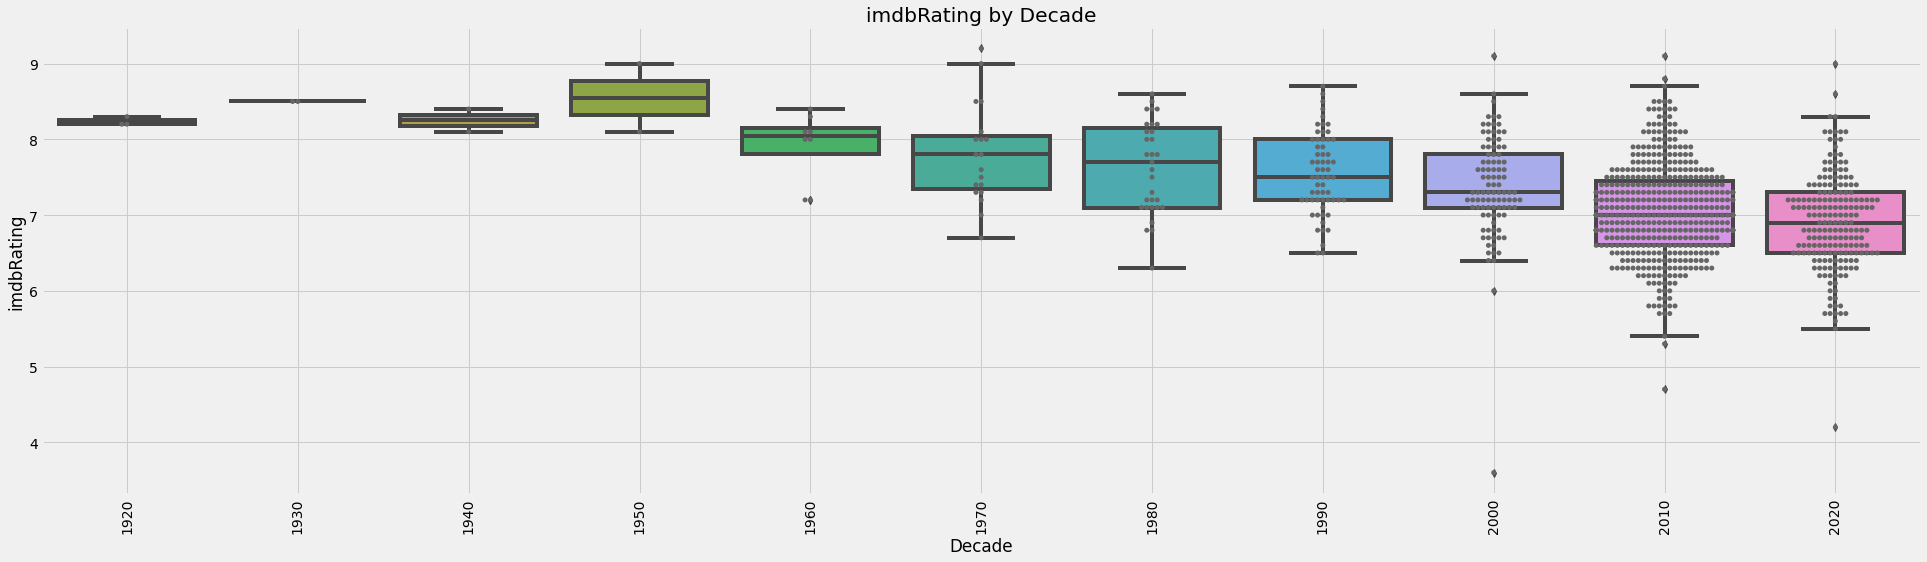

In [81]:
# imdbRating by Decade
y = 'imdbRating'
plot_box_swarm(x, y, df_decade, decade_list)

## Rated

In [82]:
# Set rated dataframe
cols = ['Title','Rated','Runtime','Genre','imdbRating']

df_rated = df[cols].copy()

In [83]:
# Movie analysis by Rated
df_rated_avg = get_mean_value(df_rated, 'Rated', 'Runtime')
df_rated_avg['imdbRating'] = get_mean_value(df_rated, 'Rated', 'imdbRating')['imdbRating']

In [84]:
# Prepare plotting
rated_list = df_rated_avg.index.sort_values()
x = 'Rated'

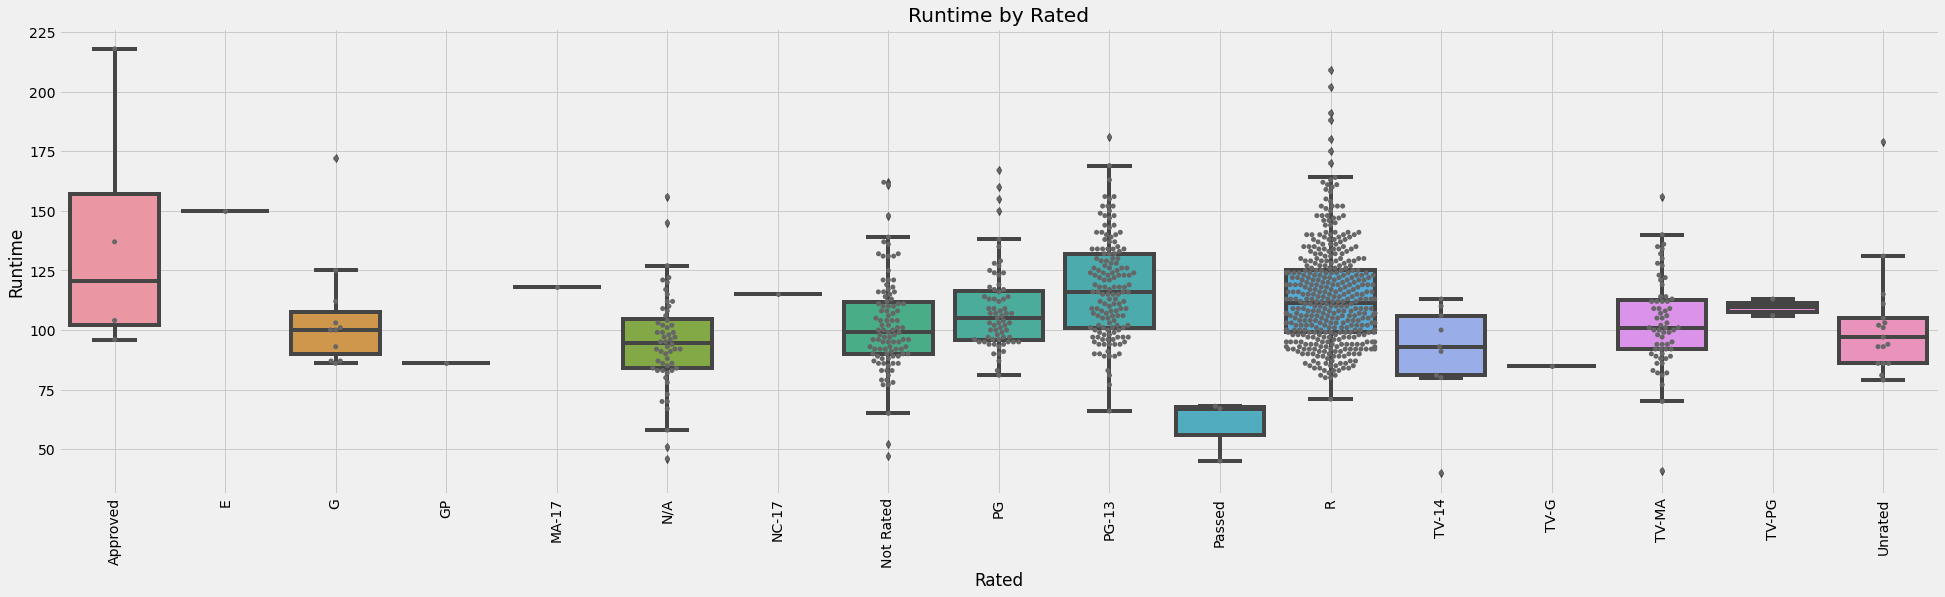

In [85]:
# The box extends from the Q1 to Q3 quartile values of the data, with a line at the median (Q2)
y = 'Runtime'
plot_box_swarm(x, y, df_rated, rated_list)

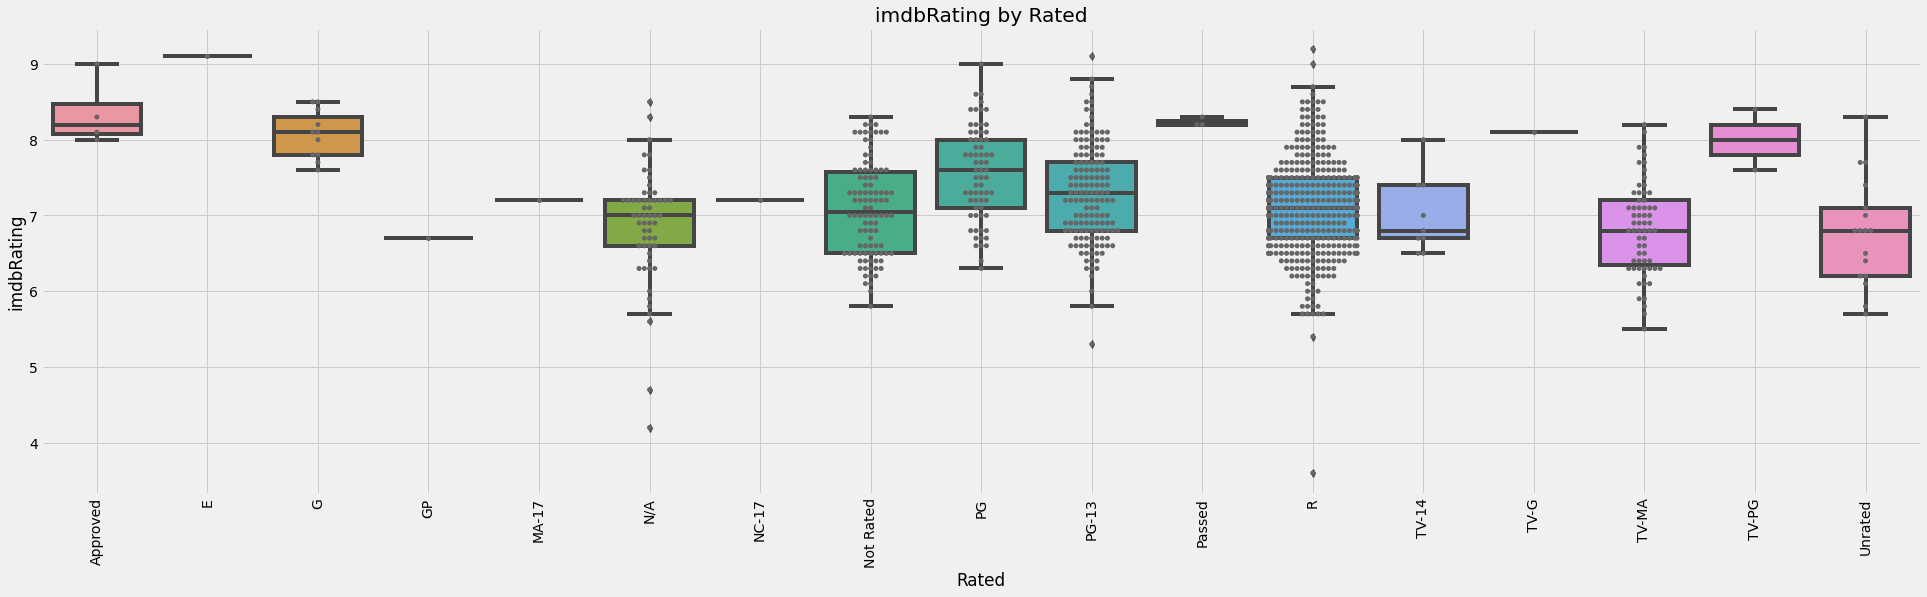

In [86]:
# The box extends from the Q1 to Q3 quartile values of the data, with a line at the median (Q2)
y = 'imdbRating'
plot_box_swarm(x, y, df_rated, rated_list)

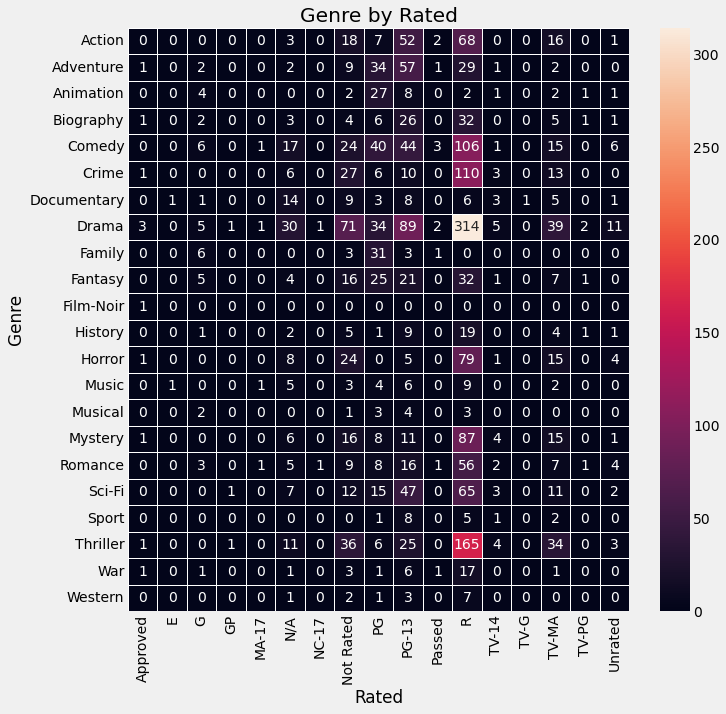

In [87]:
# Genre by Rated
df_explode_genre = df_rated.copy()

df_explode_genre.Genre = df_explode_genre.Genre.str.split(',').apply(lambda x: [e.strip() for e in x])
df_explode_genre = explode(df_explode_genre, ['Genre'])

ct_rated_genre = pd.crosstab(df_explode_genre.Genre, df_explode_genre.Rated) #, margins=True)

# Plot
_, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(ct_rated_genre, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.title('Genre by Rated');

## Runtime

In [88]:
# Set runtime dataframe
cols = ['Title','Year','Genre','Runtime','Metascore','imdbRating']

df_runtime = df[cols].copy()

In [89]:
print('Mean runtime: ' + str(int(round(df_runtime.Runtime.mean(), 0))))
print('Median runtime: ' + str(int(round(df_runtime.Runtime.median(), 0)))) 

Mean runtime: 110
Median runtime: 107


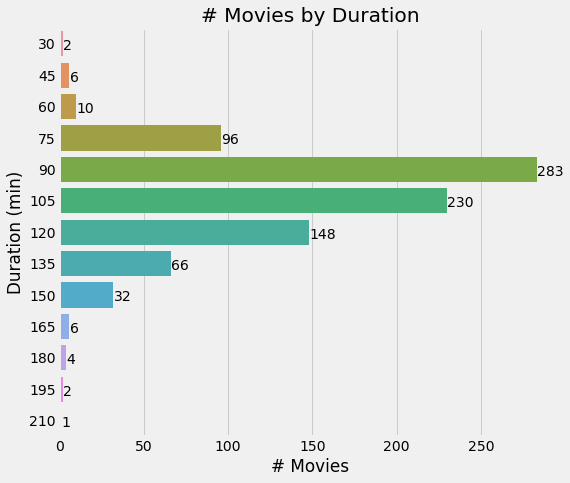

In [90]:
period = 15 # group data in groups of 15 minutes
df_runtime['Duration'] = df_runtime.Runtime.floordiv(period) * period 
df_runtime_group = df_runtime.groupby('Duration').agg({'Title':'count'})

# Plot
plot_duration_movies = df_runtime_group.reset_index()

plt.figure(figsize=(8,7))
sns.barplot(x='Title', y='Duration', data=plot_duration_movies, orient='h');

plt.title('# Movies by Duration')
plt.xlabel('# Movies')
plt.ylabel('Duration (min)')

for i, rate in enumerate(plot_duration_movies["Title"]):
    plt.text(rate+0.1, i+0.2, rate)

In [91]:
# Longest movies
print('Movies over 120 minutes (2 hours):   ', len(df_runtime[df_runtime.Runtime > 120]))
print('Movies over 150 minutes (2.5 hours): ', len(df_runtime[df_runtime.Runtime > 150]))
print('Movies over 180 minutes (3 hours):   ', len(df_runtime[df_runtime.Runtime > 180]))

N = 10
show_all(df_runtime.nlargest(N, 'Runtime', keep='all').drop_duplicates().set_index('Title'))

Movies over 120 minutes (2 hours):    253
Movies over 150 minutes (2.5 hours):  41
Movies over 180 minutes (3 hours):    6


## Genre

In [92]:
# Set genre dataframe
cols = ['Title','Year','Genre','Runtime','imdbRating','Date']

df_genre = df[cols].copy()

In [93]:
# Number of unique genres
print('Unique genres: ' + str(counter_display(df_genre, 'Genre', 'Title').index.nunique()))

# Unique genres
list(counter_display(df_genre, 'Genre', 'Title').index.unique().sort_values())

Unique genres: 22


['Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Sport',
 'Thriller',
 'War',
 'Western']

In [94]:
# Check genre of recently watched movies 
N = 10
df_genre.tail(N)

Title  Year  \
885                             Elephant  2003   
886                                House  1977   
887  The Last Black Man in San Francisco  2019   
888            The Many Saints of Newark  2021   
889              Spider-Man: No Way Home  2021   
890                          Turning Red  2022   
891                   Lawrence of Arabia  1962   
892                     Save Yourselves!  2020   
893                                Comet  2014   
894                             Plus One  2019   

                                             Genre  Runtime  imdbRating  \
885                         Crime, Drama, Thriller       81         7.1   
886                                 Comedy, Horror       88         7.3   
887                                          Drama      121         7.3   
888                                   Crime, Drama      120         6.3   
889             Action, Adventure, Fantasy, Sci-Fi      148         8.6   
890  Animation, Adventure, Comedy, Family, Fantasy      100         7.1   
891               Adventure, Biography, Drama, War      218         8.3   
892                      Adventure, Comedy, Sci-Fi       93         5.7   
893                 Comedy, Drama, Romance, Sci-Fi       91         6.7   
894                         Comedy, Drama, Romance       98         6.6   

          Date  
885 2022-03-08  
886 2022-03-09  
887 2022-03-10  
888 2022-03-11  
889 2022-03-12  
890 2022-03-12  
891 2022-03-13  
892 2022-03-14  
893 2022-03-15  
894 2022-03-16

In [95]:
# Top movie genres
df_explode_genre = df_genre.copy()

# do this for visualization below
df_explode_genre.Genre = df_explode_genre.Genre.str.split(',').apply(lambda x: [e.strip() for e in x])
df_explode_genre = explode(df_explode_genre, ['Genre'])

In [96]:
# Statistic analysis of Runtime by Genre
df_genre_runtime_stats = df_explode_genre.drop('imdbRating', axis=1).groupby('Genre')['Runtime'].describe()

stat_cols = df_genre_runtime_stats.columns.values #['count','mean','std','min','max']

df_genre_runtime_stats[stat_cols] = df_genre_runtime_stats[stat_cols].fillna(0).astype(int)
df_genre_runtime_stats.sort_values('count', inplace=True, ascending=False)

df_genre_runtime_stats

count  mean  std  min  25%  50%  75%  max
Genre                                                 
Drama          608   112   21   51   97  110  125  218
Thriller       286   110   19   51   97  108  122  191
Comedy         263   103   16   41   93  101  114  161
Crime          176   113   22   40   98  110  125  209
Action         167   118   21   45  103  118  133  191
Sci-Fi         163   114   20   70   99  112  129  181
Mystery        149   111   19   70   97  107  123  180
Adventure      138   117   22   67  101  115  132  218
Horror         137   105   18   78   93  101  114  191
Romance        114   110   19   45   98  108  124  172
Fantasy        112   112   19   70   99  109  124  180
Biography       81   122   22   81  112  120  132  218
Documentary     52    89   18   40   83   90  100  150
Animation       48   100   13   66   91  100  107  134
Family          44   101   16   66   94  100  107  172
History         43   115   20   77   99  113  130  161
War             32   118   26   67  103  117  125  218
Music           31   109   18   86   97  106  119  160
Sport           17   113   31   40  105  121  134  152
Western         14   119   19   92  103  122  131  160
Musical         13   120   24   92  100  115  133  172
Film-Noir        1   104    0  104  104  104  104  104

In [97]:
# Statistic analysis of imdbRating by Genre
df_genre_rating_stats = df_explode_genre.drop('Runtime', axis=1).groupby('Genre')['imdbRating'].describe()

stat_cols = df_genre_rating_stats.columns.values

df_genre_rating_stats[stat_cols] = df_genre_rating_stats[stat_cols].fillna(0).round(1)
df_genre_rating_stats['count'] = df_genre_rating_stats['count'].astype(int)
df_genre_rating_stats.sort_values('count', inplace=True, ascending=False)

df_genre_rating_stats

count  mean  std  min  25%  50%  75%  max
Genre                                                 
Drama          608   7.2  0.6  3.6  6.8  7.2  7.6  9.2
Thriller       286   7.0  0.6  4.2  6.5  7.0  7.3  9.1
Comedy         263   7.1  0.7  4.7  6.6  7.1  7.5  8.6
Crime          176   7.2  0.6  5.7  6.8  7.1  7.5  9.2
Action         167   7.1  0.7  4.2  6.6  7.0  7.4  9.1
Sci-Fi         163   7.0  0.7  4.2  6.5  7.0  7.4  8.8
Mystery        149   7.0  0.7  5.7  6.5  7.0  7.5  8.6
Adventure      138   7.2  0.7  5.7  6.7  7.2  7.7  8.8
Horror         137   6.7  0.6  5.4  6.3  6.6  7.1  8.5
Romance        114   7.2  0.6  5.8  6.8  7.2  7.6  8.5
Fantasy        112   7.1  0.7  4.2  6.7  7.1  7.5  8.6
Biography       81   7.4  0.5  6.2  7.1  7.4  7.8  9.0
Documentary     52   7.6  0.6  5.7  7.3  7.6  8.1  9.1
Animation       48   7.7  0.5  6.3  7.3  7.7  8.0  8.6
Family          44   7.6  0.6  6.3  7.2  7.6  8.1  8.6
History         43   7.4  0.5  6.3  7.1  7.3  7.6  8.2
War             32   7.6  0.6  6.3  7.2  7.4  8.2  8.5
Music           31   7.4  0.7  5.9  7.0  7.2  8.0  9.1
Sport           17   7.5  0.5  6.7  7.2  7.5  7.8  8.5
Western         14   7.1  0.3  6.6  6.9  7.0  7.3  7.6
Musical         13   7.3  0.6  6.3  6.7  7.4  7.6  8.1
Film-Noir        1   8.1  0.0  8.1  8.1  8.1  8.1  8.1

In [98]:
# Genre (runtime and rating mean values)
df_genre_top_stats = pd.DataFrame(index = df_genre_runtime_stats.index)

df_genre_top_stats['count'] = df_genre_runtime_stats['count']
df_genre_top_stats['runtime'] = df_genre_runtime_stats['mean']
df_genre_top_stats['ratings'] = df_genre_rating_stats['mean']

df_genre_top_stats

count  runtime  ratings
Genre                               
Drama          608      112      7.2
Thriller       286      110      7.0
Comedy         263      103      7.1
Crime          176      113      7.2
Action         167      118      7.1
Sci-Fi         163      114      7.0
Mystery        149      111      7.0
Adventure      138      117      7.2
Horror         137      105      6.7
Romance        114      110      7.2
Fantasy        112      112      7.1
Biography       81      122      7.4
Documentary     52       89      7.6
Animation       48      100      7.7
Family          44      101      7.6
History         43      115      7.4
War             32      118      7.6
Music           31      109      7.4
Sport           17      113      7.5
Western         14      119      7.1
Musical         13      120      7.3
Film-Noir        1      104      8.1

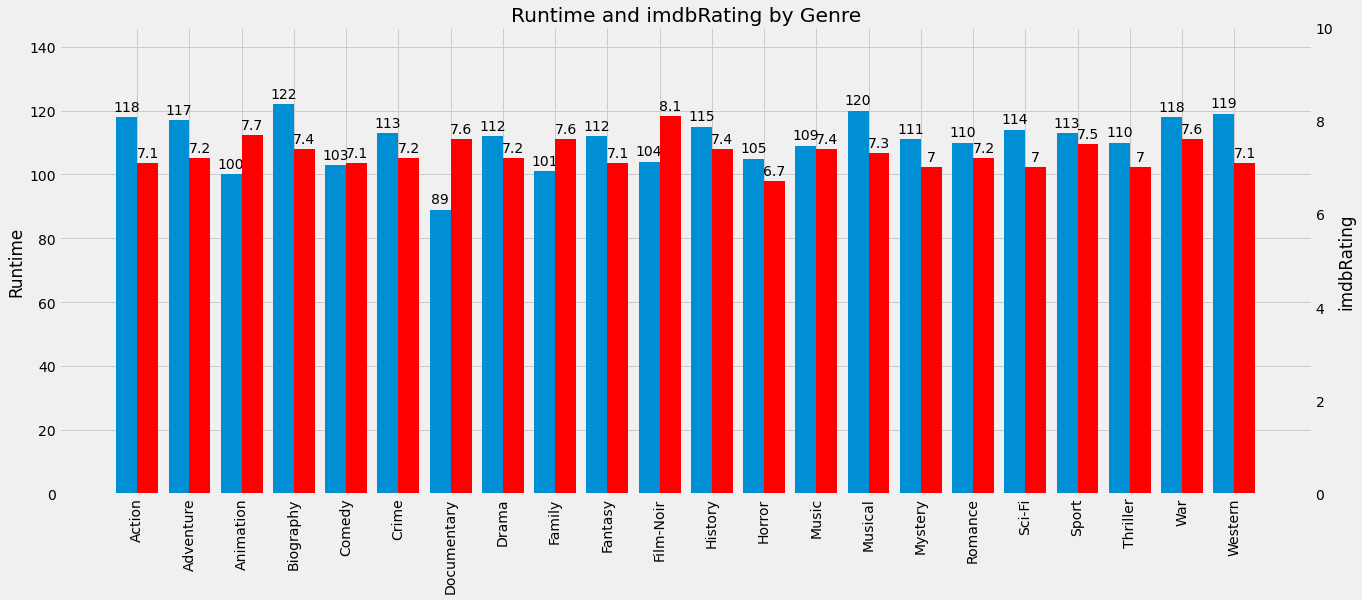

In [99]:
# Plot genre data
df_genre_data = df_genre_top_stats.reset_index().sort_values(by='Genre')

labels = df_genre_data.Genre # all genres
x = np.arange(len(labels)) # range of genres
width = 0.4 # the width of the bars

# Create plot
_, ax1 = plt.subplots(figsize=(20, 8))
ax2 = ax1.twinx()

# Bar plots
bar1 = ax1.bar(x - width/2, df_genre_data.runtime, width, label='Runtime')
bar2 = ax2.bar(x + width/2, df_genre_data.ratings, width, label='imdbRating', color='r')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_title('Runtime and imdbRating by Genre')
ax1.set_ylabel('Runtime')
ax2.set_ylabel('imdbRating')
ax1.bar_label(bar1, padding=3)
ax2.bar_label(bar2, padding=3)
ax2.yaxis.grid(False)

# Set ticks and limits
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 90) 
ax1.set_ylim(0, int(np.ceil(df_genre_data.runtime.max() + 3*df_genre_data.runtime.std()))) # set y max limit as max value + 3 std
ax2.set_ylim(0, 10) # imdbRating from 0 to 10

plt.show()

In [100]:
## Prepare ploting
#x = 'Genre'
## get genre order a-z
#genre_list = counter_display(df, 'Genre', 'Title', None).index.unique().sort_values()

In [101]:
## The box extends from the Q1 to Q3 quartile values of the data, with a line at the median (Q2)
#y = 'imdbRating'
#plot_box_swarm(x, y, df_explode_genre, genre_list)

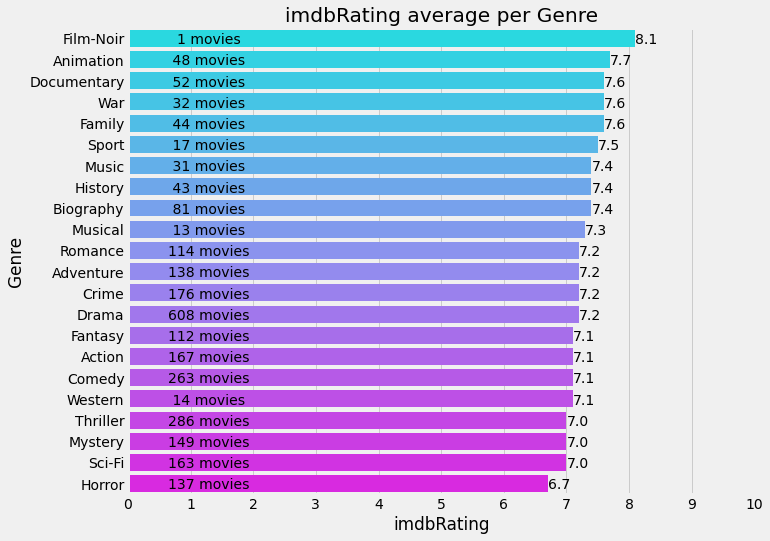

In [102]:
# Genre with highest imdbRating
df_genre_rating_stats.sort_values(by='mean', ascending=False, inplace=True)

# https://medium.com/analytics-vidhya/exploratory-data-analysis-imdb-dataset-cff0c3991ad5
plt.figure(figsize=(10,8))
sns.barplot(y=df_genre_rating_stats.index, x=df_genre_rating_stats["mean"], palette='cool', orient="h")

# Plot settings
plt.title('imdbRating average per Genre')
plt.xlabel('imdbRating')
plt.xlim((0,10)) # imdbRating from 0 to 10
plt.xticks(np.arange(0, 11, step=1))

for i, counts in enumerate(df_genre_rating_stats["count"]):
    plt.text(0.5, i+0.25, f"{counts:>5} movies")
    plt.text(df_genre_rating_stats["mean"][i], i+0.25, df_genre_rating_stats["mean"][i])
    
plt.show()

In [103]:
# Number of unique combination of genres
df_genre[['Genre','Title']].groupby(by='Genre').count().reset_index()['Genre'].nunique()

343

In [104]:
# Top movie genres combination
df_genre_date = df_genre.copy()
df_genre_date['Year'] = df_genre.Date.dt.year

df_genre_date.drop(columns='Date', inplace=True)
pd.crosstab(df_genre_date['Genre'], df_genre_date['Year'], margins=True).nlargest(N+1, 'All', keep='all') # +1 because 'All' takes 1 spot 

Year                             2018  2019  2020  2021  2022  All
Genre                                                             
All                                59    73   251   404    99  886
Drama                               1     3    22    27    11   64
Comedy, Drama                       7     4    12    18     2   43
Crime, Drama, Thriller              2     3    11    10     4   30
Documentary                         2     1     9     9     2   23
Comedy, Drama, Romance              0     1     0    12     8   21
Drama, Romance                      0     2     5    11     3   21
Crime, Drama                        1     1     4     9     3   18
Crime, Drama, Mystery, Thriller     0     3     6     7     1   17
Action, Adventure, Sci-Fi           4     3     1     5     0   13
Biography, Drama                    0     1     6     6     0   13

In [105]:
# Genre combination with most movies, showing worst and best rated movies
df_genre_agg = df_genre.groupby(by='Genre').agg({'imdbRating':['min','max','mean'], 
                                                 'Title':['count']})
df_genre_agg.reset_index(inplace=True)

df_genre_agg[('Title','worst')] = df_genre.loc[df_genre.groupby('Genre')['imdbRating'].idxmin().fillna(0).astype(int)].reset_index(drop=True)['Title']
df_genre_agg[('Title','best')] = df_genre.loc[df_genre.groupby('Genre')['imdbRating'].idxmax().fillna(0).astype(int)].reset_index(drop=True)['Title']

df_genre_agg = df_genre_agg.set_index([('Genre','')]).sort_values(by=[('Title','count')], ascending=False).round(1)
df_genre_agg.index.rename('Genre', inplace=True)

df_genre_agg.nlargest(N, [('Title', 'count')], keep='all')

imdbRating           Title  \
                                       min  max mean count   
Genre                                                        
Drama                                  3.6  8.4  7.1    64   
Comedy, Drama                          6.2  8.2  7.1    43   
Crime, Drama, Thriller                 6.3  8.4  7.2    30   
Documentary                            5.9  8.5  7.5    23   
Comedy, Drama, Romance                 6.4  8.5  7.2    21   
Drama, Romance                         6.1  8.5  7.4    21   
Crime, Drama                           6.3  9.2  7.5    18   
Crime, Drama, Mystery, Thriller        6.3  8.5  7.2    17   
Biography, Drama                       6.6  8.2  7.5    13   
Action, Adventure, Sci-Fi              6.3  8.5  7.3    13   

                                                            \
                                                     worst   
Genre                                                        
Drama                                             The Room   
Comedy, Drama                                    Chevalier   
Crime, Drama, Thriller                                Kimi   
Documentary                           Expedition Happiness   
Comedy, Drama, Romance                        On the Rocks   
Drama, Romance                                        Love   
Crime, Drama                     The Many Saints of Newark   
Crime, Drama, Mystery, Thriller               Shimmer Lake   
Biography, Drama                                       Joy   
Action, Adventure, Sci-Fi                             Dune   

                                                         
                                                   best  
Genre                                                    
Drama                                         Capernaum  
Comedy, Drama                           The Truman Show  
Crime, Drama, Thriller                            Joker  
Documentary                             Untamed Romania  
Comedy, Drama, Romance                      City Lights  
Drama, Romance                          Cinema Paradiso  
Crime, Drama                              The Godfather  
Crime, Drama, Mystery, Thriller      The Usual Suspects  
Biography, Drama                       The Elephant Man  
Action, Adventure, Sci-Fi        Avengers: Infinity War

In [106]:
# Genre combination with higher imdbRating
df_genre_agg[df_genre_agg[('Title','count')] > 2].nlargest(N, [('imdbRating','mean')], keep='all')

imdbRating           Title  \
                                                     min  max mean count   
Genre                                                                      
Documentary, Music                                   8.0  9.1  8.4     3   
Action, Adventure, Sci-Fi, Thriller                  7.3  8.8  8.2     3   
Adventure, Drama, Sci-Fi                             6.9  8.7  7.9     3   
Documentary, History                                 7.5  8.1  7.8     3   
Comedy, Drama, War                                   6.9  8.4  7.7     3   
Action, Crime, Drama, Thriller                       6.5  9.1  7.6     9   
Comedy, Drama, Thriller                              6.8  8.5  7.6     4   
Mystery, Thriller                                    6.7  8.5  7.6     3   
Documentary                                          5.9  8.5  7.5    23   
Crime, Drama                                         6.3  9.2  7.5    18   
Biography, Drama                                     6.6  8.2  7.5    13   
Biography, Crime, Drama                              6.6  8.1  7.5     6   
Animation, Adventure, Comedy, Family, Fantasy        7.1  7.7  7.5     4   
Biography, Drama, Sport                              7.4  7.6  7.5     3   

                                                                          \
                                                                   worst   
Genre                                                                      
Documentary, Music                              Tripping with Nils Frahm   
Action, Adventure, Sci-Fi, Thriller                  Alita: Battle Angel   
Adventure, Drama, Sci-Fi                                           Finch   
Documentary, History                                    One Child Nation   
Comedy, Drama, War                                      Last Flag Flying   
Action, Crime, Drama, Thriller                               Enforcement   
Comedy, Drama, Thriller                                   Under the Tree   
Mystery, Thriller                                                    Run   
Documentary                                         Expedition Happiness   
Crime, Drama                                   The Many Saints of Newark   
Biography, Drama                                                     Joy   
Biography, Crime, Drama                             The Snowtown Murders   
Animation, Adventure, Comedy, Family, Fantasy                Turning Red   
Biography, Drama, Sport                                   McFarland, USA   

                                                                           
                                                                     best  
Genre                                                                      
Documentary, Music                             Hans Zimmer Live in Prague  
Action, Adventure, Sci-Fi, Thriller                             Inception  
Adventure, Drama, Sci-Fi                                     Interstellar  
Documentary, History                                            Apollo 11  
Comedy, Drama, War                                     The Great Dictator  
Action, Crime, Drama, Thriller                            The Dark Knight  
Comedy, Drama, Thriller                                          Parasite  
Mystery, Thriller                                                 Memento  
Documentary                                               Untamed Romania  
Crime, Drama                                                The Godfather  
Biography, Drama                                         The Elephant Man  
Biography, Crime, Drama                               Catch Me If You Can  
Animation, Adventure, Comedy, Family, Fantasy                 Toy Story 4  
Biography, Drama, Sport                                         Moneyball

In [107]:
# Genre combination with lower imdbRating
df_genre_agg[df_genre_agg[('Title','count')] > 2].nsmallest(N, [('imdbRating','mean')], keep='all')

imdbRating           Title  \
                                                min  max mean count   
Genre                                                                 
Comedy, Horror, Sci-Fi                          5.6  6.5  6.1     3   
Horror, Mystery, Sci-Fi, Thriller               5.8  6.8  6.3     5   
Comedy, Horror                                  5.7  7.3  6.3     4   
Action, Comedy, Horror, Thriller                5.5  6.9  6.3     3   
Drama, Horror, Thriller                         6.2  7.2  6.5     7   
Drama, Sci-Fi, Thriller                         6.0  6.8  6.5     6   
Comedy, Horror, Thriller                        6.1  6.7  6.5     5   
Drama, Horror, Mystery, Sci-Fi, Thriller        6.2  7.1  6.5     4   
Action, Comedy, Crime, Thriller                 6.3  6.9  6.5     3   
Horror, Mystery, Thriller                       5.9  7.5  6.6     5   
Crime, Drama, Horror, Thriller                  6.4  6.9  6.6     3   
Drama, Horror, Mystery                          6.2  6.9  6.6     3   

                                                                        \
                                                                 worst   
Genre                                                                    
Comedy, Horror, Sci-Fi                                     Fried Barry   
Horror, Mystery, Sci-Fi, Thriller                             The Void   
Comedy, Horror                                    The Greasy Strangler   
Action, Comedy, Horror, Thriller                    Willy's Wonderland   
Drama, Horror, Thriller                              Boys in the Trees   
Drama, Sci-Fi, Thriller                                     Fast Color   
Comedy, Horror, Thriller                                 The Beta Test   
Drama, Horror, Mystery, Sci-Fi, Thriller             It Comes at Night   
Action, Comedy, Crime, Thriller                            Guns Akimbo   
Horror, Mystery, Thriller                     The Blackcoat's Daughter   
Crime, Drama, Horror, Thriller                                 Creep 2   
Drama, Horror, Mystery                    Fear Street: Part One - 1994   

                                                                                      
                                                                                best  
Genre                                                                                 
Comedy, Horror, Sci-Fi                                                       Slither  
Horror, Mystery, Sci-Fi, Thriller                                           eXistenZ  
Comedy, Horror                                                                 House  
Action, Comedy, Horror, Thriller                                            The Trip  
Drama, Horror, Thriller                                                 Dead Ringers  
Drama, Sci-Fi, Thriller                                                       Primer  
Comedy, Horror, Thriller                  Behind the Mask: The Rise of Leslie Vernon  
Drama, Horror, Mystery, Sci-Fi, Thriller                           The Invisible Man  
Action, Comedy, Crime, Thriller                                           Game Night  
Horror, Mystery, Thriller                                             The Wicker Man  
Crime, Drama, Horror, Thriller                                Nothing Bad Can Happen  
Drama, Horror, Mystery                                                     The Witch

In [108]:
# Most watched genres, with rating and worst/best movie from each genre
df_top_genres_year = df_genre[~df_genre.Genre.str.contains('Documentary')][~df_genre.duplicated(['Title','Year'], keep='first')]

SHOW = 5

[
    [
        print(year),
        # all movies
        most_watched_genre_combo(df_top_genres_year, SHOW, year),
        most_watched_genre(df_top_genres_year, SHOW, year),
        print('\n'),
    ]
    for year in years
];

2018




2019




2020




2021




2022


In [109]:
# Best movies by genre in each decade
SHOW = 3

df_decade_genre = df_decade.copy()
df_decade_genre.Genre = df_decade_genre.Genre.str.split(',').apply(lambda x: [e.strip() for e in x])
df_decade_genre = explode(df_decade_genre, ['Genre'])

df_best_decade_genre = df_decade_genre.groupby(['Decade','Genre'], as_index=False).apply(lambda x: x.nlargest(SHOW, 'imdbRating', keep='last'))
df_best_decade_genre = pd.crosstab(index=df_best_decade_genre.Genre, 
                                   columns=df_best_decade_genre.Decade, 
                                   values=df_best_decade_genre.Title, 
                                   aggfunc=' * '.join)

show_all(df_best_decade_genre)

In [110]:
## List of unique genres
#unique_genres = list(counter_display(df, 'Genre', 'Title').index) 
#unique_genres.sort()
#
## Best movies by genre
#[
#    [print(genre), 
#     show_all(df_decade[df_decade.Genre.str.contains(genre)].set_index(['Decade','Title']).sort_values(['Decade','imdbRating'], ascending=False).groupby(level=0, as_index=False).apply(lambda x: x.head(1)).reset_index(level=0, drop=True)),
#     print('\n'),
#     print('***************************************************************\n')
#    ]
#    for genre in unique_genres
#];

## Director

In [111]:
# Number of unique Directors (single or multiple)
len(counter_display(df, 'Director', 'Title', None).index)

729

In [112]:
# Set director dataframe
cols = ['Title','Year','Runtime','Director','Genre','imdbRating','imdbVotes','Date']

df_director = df[cols].copy()
# No duplicated movies
df_director = df_director[~df_director.duplicated(['Title','Year'], keep='first')]
df_director = df_director[~df_director.duplicated(['Title','Director'], keep='first')]
# Drop documentaries
df_director = df_director[~df_director.Genre.str.contains('Documentary')].reset_index(drop=True) 

In [113]:
# Directors with most movies wached
df_dirrat = get_mean_value(df_director, 'Director', 'imdbRating')
df_dirrat['Runtime'] = get_mean_value(df_director, 'Director', 'Runtime')['Runtime']

# Most watched Directors - no Docs
print('Directors with only 1 movie watched: ' + str(len(df_dirrat[df_dirrat.Total == 1])))
print('Directors with more than 1 movie watched: ' + str(len(df_dirrat[df_dirrat.Total > 1])))
print('Directors with more than 2 movies watched: ' + str(len(df_dirrat[df_dirrat.Total > 2])))

Directors with only 1 movie watched: 523
Directors with more than 1 movie watched: 144
Directors with more than 2 movies watched: 44


In [114]:
# Most watched Directors by Year
[
    [
        print(year),
        show_all(get_mean_value(df_director[df_director.Date.dt.year == year], 'Director', 'imdbRating').query('Total > 1').sort_values(['Total','imdbRating'], ascending=False)),
        print('\n'),
    ]
    for year in years
];

2018




2019




2020




2021




2022


In [115]:
# Directors with most movies watched
show_all(df_dirrat[df_dirrat.Total > 2].sort_values(by=['Total','imdbRating'], ascending=False))

In [116]:
# Highest rating directors (with more than 1 movie watched)
N = 10
show_all(df_dirrat[df_dirrat.Total > 1].nlargest(N, 'imdbRating', keep='all'))

In [117]:
# Top rated directors with only 1 movie watched
df_dirrat[~df_dirrat['Movies'].apply(pd.Series).duplicated()][df_dirrat.Total == 1].nlargest(N, 'imdbRating', keep='all') # columns with list values # remove duplicated list values

Movies  Total  imdbRating  \
Director                                                                     
Sidney Lumet                               12 Angry Men      1         9.0   
Nadine Labaki                                 Capernaum      1         8.4   
Lee Unkrich                                        Coco      1         8.4   
Makoto Shinkai                               Your Name.      1         8.4   
Milos Forman                                    Amadeus      1         8.4   
Todd Phillips                                     Joker      1         8.4   
Peter Ramsey          Spider-Man: Into the Spider-Verse      1         8.4   
Michel Gondry     Eternal Sunshine of the Spotless Mind      1         8.3   
Sam Mendes                                         1917      1         8.3   
Rahi Anil Barve                                 Tumbbad      1         8.3   
Darren Aronofsky                    Requiem for a Dream      1         8.3   
David Lean                           Lawrence of Arabia      1         8.3   
Florian Zeller                               The Father      1         8.3   

                  Runtime  
Director                   
Sidney Lumet           96  
Nadine Labaki         126  
Lee Unkrich           105  
Makoto Shinkai        106  
Milos Forman          160  
Todd Phillips         122  
Peter Ramsey          117  
Michel Gondry         108  
Sam Mendes            119  
Rahi Anil Barve       104  
Darren Aronofsky      102  
David Lean            218  
Florian Zeller         97

In [118]:
# Lowest rating directors
show_all(df_dirrat[df_dirrat.Total > 1].nsmallest(N, 'imdbRating', keep='all'))

In [119]:
# Genre by Director
df_genre_director = df_director.copy()

df_genre_director.Genre = df_genre_director.Genre.str.split(',').apply(lambda x: [e.strip() for e in x])
df_genre_director.Director = df_genre_director.Director.str.split(',').apply(lambda x: [e.strip() for e in x])

df_genre_director = explode(df_genre_director, ['Genre'])
df_genre_director = explode(df_genre_director, ['Director'])

director_movies = df_dirrat[df_dirrat.Total > 2].index
ct_genre_director = pd.crosstab(df_genre_director.Director, df_genre_director.Genre).loc[director_movies]

In [120]:
# Top Director by Genre
df_genre_top_director = pd.crosstab(df_genre_director.Director, df_genre_director.Genre)
list_genres = df_genre_top_director.columns

for i in range(len(list_genres)):
    # genre
    gnr = []
    gnr = list_genres[i]
    
    df_genre_temp = pd.DataFrame(df_genre_top_director.nlargest(3, gnr)[gnr])
    df_genre_temp['Movies'] = np.nan
    df_genre_temp['Movies'] = df_genre_temp['Movies'].astype('object') # need to make sure the column you are inserting into has dtype=object
    
    # director
    drctr = []
    drctr = list(df_genre_temp.index)
    for j in range(len(drctr)):
        # movies
        mvs = []
        mvs = '; '.join(df[df.Director.str.contains(drctr[j])][df.Genre.str.contains(gnr)]['Title'])
        
        df_genre_temp.at[drctr[j], 'Movies'] = mvs # .at instead of .loc

    show_all(df_genre_temp)
    
    print('\n'),
    print('***************************************************************\n')



***************************************************************





***************************************************************





***************************************************************





***************************************************************





***************************************************************





***************************************************************





***************************************************************





***************************************************************





***************************************************************





***************************************************************





***************************************************************





***************************************************************





***************************************************************





***************************************************************





***************************************************************





***************************************************************





***************************************************************





***************************************************************





***************************************************************





***************************************************************





***************************************************************



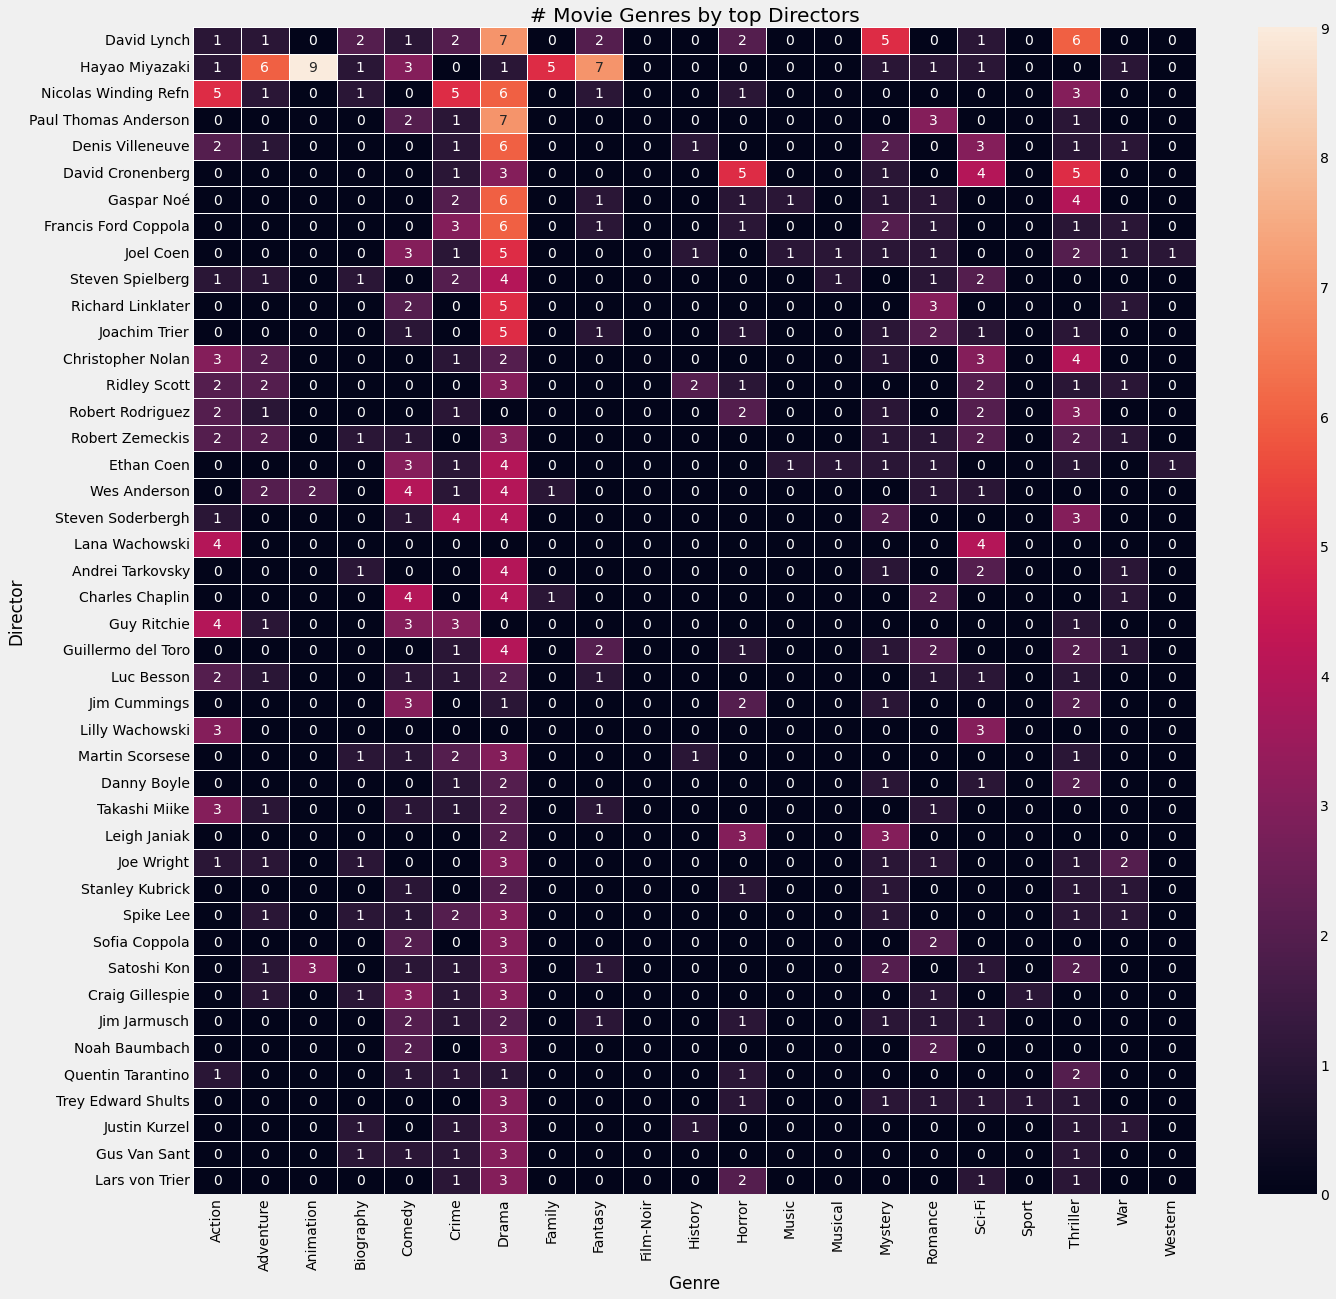

In [121]:
# Plot movie genres by top Directors
_, ax = plt.subplots(figsize=(20, 20))

ax = sns.heatmap(ct_genre_director, annot=True, fmt="d", linewidths=.5, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90) 
plt.title('# Movie Genres by top Directors');

In [122]:
# search data by director
director = 'Joachim Trier'
df[df.Director.str.contains(director)].iloc[:,:-6]

Title  Year    imdbID      Rated  Runtime  \
426                         Thelma  2017   6304046  Not Rated      116   
667                        Reprise  2006   0827517          R      105   
826  The Worst Person in the World  2021  10370710          R      128   
865              Oslo, August 31st  2011   1736633  Not Rated       95   
866              Louder Than Bombs  2015   2217859          R      109   

                                                 Genre       Director  \
426  Drama, Fantasy, Horror, Mystery, Romance, Sci-...  Joachim Trier   
667                                              Drama  Joachim Trier   
826                             Comedy, Drama, Romance  Joachim Trier   
865                                              Drama  Joachim Trier   
866                                              Drama  Joachim Trier   

                                                Writer Cinematographers  \
426                          Joachim Trier, Eskil Vogt              N/A   
667                          Joachim Trier, Eskil Vogt              N/A   
826                          Joachim Trier, Eskil Vogt              N/A   
865  Pierre Drieu La Rochelle, Joachim Trier, Eskil...              N/A   
866                          Joachim Trier, Eskil Vogt              N/A   

                                                Actors  \
426  Eili Harboe, Kaya Wilkins, Henrik Rafaelsen, E...   
667  Anders Danielsen Lie, Espen Klouman Høiner, Vi...   
826  Renate Reinsve, Anders Danielsen Lie, Herbert ...   
865  Anders Danielsen Lie, Malin Crépin, Aksel Than...   
866  Gabriel Byrne, Isabelle Huppert, Jesse Eisenbe...   

                                                  Plot            Language  \
426  A confused religious girl tries to deny her fe...  Norwegian, Swedish   
667  Two competitive friends, fueled by literary as...           Norwegian   
826  The chronicles of four years in the life of Ju...           Norwegian   
865  One day in the life of Anders, a young recover...  Norwegian, English   
866  The fractious family of a father and his two s...     English, French   

                                    Country  Metascore  imdbRating  imdbVotes  \
426         Norway, France, Denmark, Sweden         74         7.0      30707   
667                                  Norway         79         7.3      10877   
826         Norway, France, Sweden, Denmark         90         7.9      23242   
865                 Norway, Denmark, Sweden         84         7.6      22417   
866  Norway, France, Denmark, United States         70         6.6      12920   

                                            Production           Timestamp  \
426  Motlys, Memento Films International, Film i Vä... 2021-02-01 21:08:00   
667  4 1/2 Film, Filmlance International AB, Spille... 2021-09-24 23:05:59   
826  Oslo Pictures, MK2 Productions, Film i Väst, S... 2022-01-18 23:15:20   
865  Motlys, Don't Look Now, Norsk Filminstitutt, N... 2022-02-16 23:37:30   
866  Motlys, Memento Films Production, Nimbus Film ... 2022-02-17 23:16:04   

          Date      Time  
426 2021-02-01  21:08:00  
667 2021-09-24  23:05:59  
826 2022-01-18  23:15:20  
865 2022-02-16  23:37:30  
866 2022-02-17  23:16:04

In [123]:
# Director average votes by movie
df_director_votes = df_director.copy()

df_director_votes.Director = df_director_votes.Director.str.split(',').apply(lambda x: [e.strip() for e in x])
df_director_votes = explode(df_director_votes, ['Director'])

df_director_avg_votes = get_mean_value(df_director_votes, 'Director', 'imdbVotes')
df_director_avg_votes['imdbRating'] = get_mean_value(df_director_votes, 'Director', 'imdbRating')['imdbRating']
df_director_avg_votes['imdbVotes'] = df_director_avg_votes.Total * df_director_avg_votes.imdbVotes

# Most votes
show_all(df_director_avg_votes[df_director_avg_votes.Total > 1].nlargest(N, 'imdbVotes', keep='all'))

In [124]:
## Fewer votes
#show_all(df_director_avg_votes[df_director_avg_votes.Total > 1].nsmallest(N, 'imdbVotes', keep='all'))

In [125]:
## Less known directors to follow
# more than 1 movie watched
# less votes than 50% quantile
# imdbRating average over 6
show_all(df_director_avg_votes[df_director_avg_votes.Total > 1][df_director_avg_votes.imdbVotes < df_director_avg_votes.imdbVotes.quantile(0.5)][df_director_avg_votes.imdbRating > 6.0])

## Writer

In [126]:
len(counter_display(df,'Writer','Title', None).index)

1566

In [127]:
# Set writer dataframe
df_writer = df.copy()

df_writer.Writer = df_writer.Writer.str.split(',').apply(lambda x: [e.strip() for e in x])
df_writer.Writer = df_writer.Writer.apply(lambda x: list(set(x)))
df_writer = explode(df_writer, ['Writer'])
df_writer = df_writer[~df_writer.Writer.str.startswith('N/A')] # remove 'N/A'
# Drop documentaries
df_writer = df_writer[~df_writer.Genre.isin(['Documentary'])]

In [128]:
# Highest rating writers
df_writer_rating = df_writer.copy()
df_writer_rating = get_mean_value(df_writer_rating, 'Writer', 'imdbRating')

# Writer with most movies watched
show_all(df_writer_rating.nlargest(N, 'Total', keep='all'))

In [129]:
# Writer with highest average rating, by movies watched (greater than 2)
show_all(df_writer_rating[df_writer_rating.Total > 2].nlargest(N, 'imdbRating', keep='all'))

In [130]:
df_director_writer = df[~df.Genre.str.contains('Documentary')].copy()

# Number of movies where the director was also the writer 
len(df_director_writer[df_director_writer.Director == df_director_writer.Writer])

220

In [131]:
# Top Director/Writer
df_director_writer = df_writer.copy()

df_director_writer.Director = df_director_writer.Director.str.split(',').apply(lambda x: [e.strip() for e in x])
df_director_writer = explode(df_director_writer, ['Director'])

gb_director_writer = df_director_writer[df_director_writer.Director == df_director_writer.Writer].groupby('Director').agg({'Title':['count', '; '.join]})
show_all(gb_director_writer.nlargest(N,('Title','count'), keep='all'))

In [132]:
# Best pairing Writer / Director based on imdbRating
# Top N
N = 20

df_writer_pair = df_director_writer.copy()
# drop Marvel directors (too many writers and not that interesting to me)
df_writer_pair = df_writer_pair[~df_writer_pair.Director.isin(['Anthony Russo','Joe Russo','Jon Watts'])]

# group by 
gb_writer_pair = df_writer_pair.groupby(['Writer','Director']).agg({'Title':['count','; '.join],'imdbRating':'mean'})
gb_writer_pair.imdbRating = gb_writer_pair.imdbRating.round(2)
gb_writer_pair = gb_writer_pair[gb_writer_pair[('Title','count')] > 1].reset_index()
gb_writer_pair = gb_writer_pair[gb_writer_pair.Writer != gb_writer_pair.Director].set_index(['Writer','Director'])
gb_writer_pair = gb_writer_pair.nlargest(N, ('imdbRating','mean'), keep='all')

show_all(gb_writer_pair)

## Cinematographers

In [133]:
## NOTE:
# IMDb request stopped giving information about Cinematographers

In [134]:
#len(counter_display(df, 'Cinematographers', 'Title', None).index)

In [135]:
## Cinematographers average
#cols = ['Title','Cinematographers','imdbRating']
#df_cinema = df[cols].copy()
#df_cinema = df_cinema[~df_cinema.duplicated(['Title','Cinematographers'], keep='first')]
#df_cinema = df_cinema[~df_cinema.Cinematographers.str.startswith('nan')] # remove nan
#
## Cinematographers / ratings
#df_cinema_rating = get_mean_value(df_cinema, 'Cinematographers', 'imdbRating')
#df_cinema_rating = df_cinema_rating.drop(index='N/A')
#
##counter_display(df, 'Cinematographers', 'Title', n)
#cin_list = df_cinema_rating.nlargest(N, 'Total', keep='all').index.values
#show_all(df_cinema_rating.nlargest(N, 'Total', keep='all'))

In [136]:
## Highest rating Cinematographers
#show_all(df_cinema_rating[df_cinema_rating.Total > 2].nlargest(N, 'imdbRating', keep='all'))

In [137]:
## Lowest rating Cinematographers
#show_all(df_cinema_rating[df_cinema_rating.Total > 1].nsmallest(N, 'imdbRating', keep='all'))

In [138]:
## Genre by Cinematographers
#cols = ['Title','Cinematographers','Genre']
#df_explode_cinema = df[cols].copy()
#
#df_explode_cinema.Genre = df_explode_cinema.Genre.str.split(',').apply(lambda x: [e.strip() for e in x])
#df_explode_cinema.Cinematographers = df_explode_cinema.Cinematographers.str.split(',').apply(lambda x: [e.strip() for e in x])
#
#df_explode_cinema = explode(df_explode_cinema, ['Genre'])
#df_explode_cinema = explode(df_explode_cinema, ['Cinematographers'])
#
#cinema_movies = counter_display(df, 'Cinematographers', 'Title', N).index
#ct_cinema_genre = pd.crosstab(df_explode_cinema.Cinematographers, df_explode_cinema.Genre).loc[cinema_movies].iloc[1:,:]
##show_all(ct_genre_director.loc[director_movies])
#
## Plot
#_, ax = plt.subplots(figsize=(15, 10))
#ax = sns.heatmap(ct_cinema_genre, annot=True, fmt="d", linewidths=.5, ax=ax)
#ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
#plt.title('# Movie Genres by Top Cinematographers');

In [139]:
## Most common pair cinematographer - director
#cols = ['Title','Director','Cinematographers','imdbRating']
#df_cin_dir = df[cols].copy()
#df_cin_dir = df_cin_dir[~df_cin_dir.duplicated(['Title','Cinematographers'], keep='first')]
#df_cin_dir = df_cin_dir[~df_cin_dir.Cinematographers.str.startswith('nan')] # remove nan
#
#gb_cin_dir = df_cin_dir.groupby(['Cinematographers','Director']).agg({'Title':['count',list]})
#show_all(gb_cin_dir.nlargest(N, ('Title','count'),keep='all'))

In [140]:
## More than 1 movie per pair
#gb_cin_dir[gb_cin_dir[('Title','count')] > 1]

## Actors

In [347]:
# Set actors dataframe
cols = ['Title','Year','Genre','Director','Actors','imdbRating']

df_actors = df[cols].copy()

# Filter documentaries
condition = 'Documentary'
query = "Genre not in '" + condition + "'"
df_actors = df_actors[cols].query(query).copy()

# Drop duplicates
df_actors.drop_duplicates(subset=['Title','Year','Director'], keep='first', inplace=True) # include director for cases likes Swan Song (2021)

# Drop list of 'too small role' - 'uncredited' actors with multiple appearances 
list_actors_drop = ['Mark Falvo','Arnold Montey','Rosemary Howard','Jimmy Star',
                    'Joseph Oliveira','Bridget Hoffman','Kadrolsha Ona Carole','Richard Price',
                    'Doris McCarthy','Bern Collaço','Dee Bradley Baker','Jorge Leon Martinez',
                    'John Gettier','Jeffrey Neil','David Evestaff','Martin Palmer',
                    'Stan Lee','J. Nathan Simmons','Michael E. Stogner','Richard Nixon',
                    'John F. Kennedy','John W. Iwanonkiw','Walter Cronkite']

df_actors['Actors'] = df_actors['Actors'].str.replace(', |'.join(list_actors_drop), '')
df_actors['Actors'] = df_actors['Actors'].str.replace(' ,','')

In [348]:
df_counter_actors = counter_display(df_actors, 'Actors', 'Title', None)

# Number of actors
len(df_counter_actors.index)

40717

In [349]:
# Top N actors
N = 20
df_top_actors = df_counter_actors.copy()

top_actors = df_top_actors.nlargest(N, 'Title', keep='all')
top_actors

Title
Willem Dafoe               17
Keanu Reeves               14
Adam Driver                14
Bill Murray                13
Brad Pitt                  12
Ryan Gosling               12
Benedict Cumberbatch       11
Bruce Willis               11
Laurence Fishburne         11
Matt Damon                 11
Samuel L. Jackson          10
Timothée Chalamet          10
Philip Seymour Hoffman     10
J.K. Simmons               10
Tilda Swinton              10
Jesse Plemons              10
Scarlett Johansson          9
Ben Mendelsohn              9
Bill Camp                   9
Udo Kier                    9
Laura Dern                  9
Cate Blanchett              9
Mark Ruffalo                9
Alfred Molina               9
Nicolas Cage                9
Benedict Wong               9

In [350]:
# Get list of top n actors
list_top_actors = top_actors.index.values
list_top_actors.sort()

# filtering by list of top actors
df_actor_rating = get_mean_value(df_actors, 'Actors', 'imdbRating')

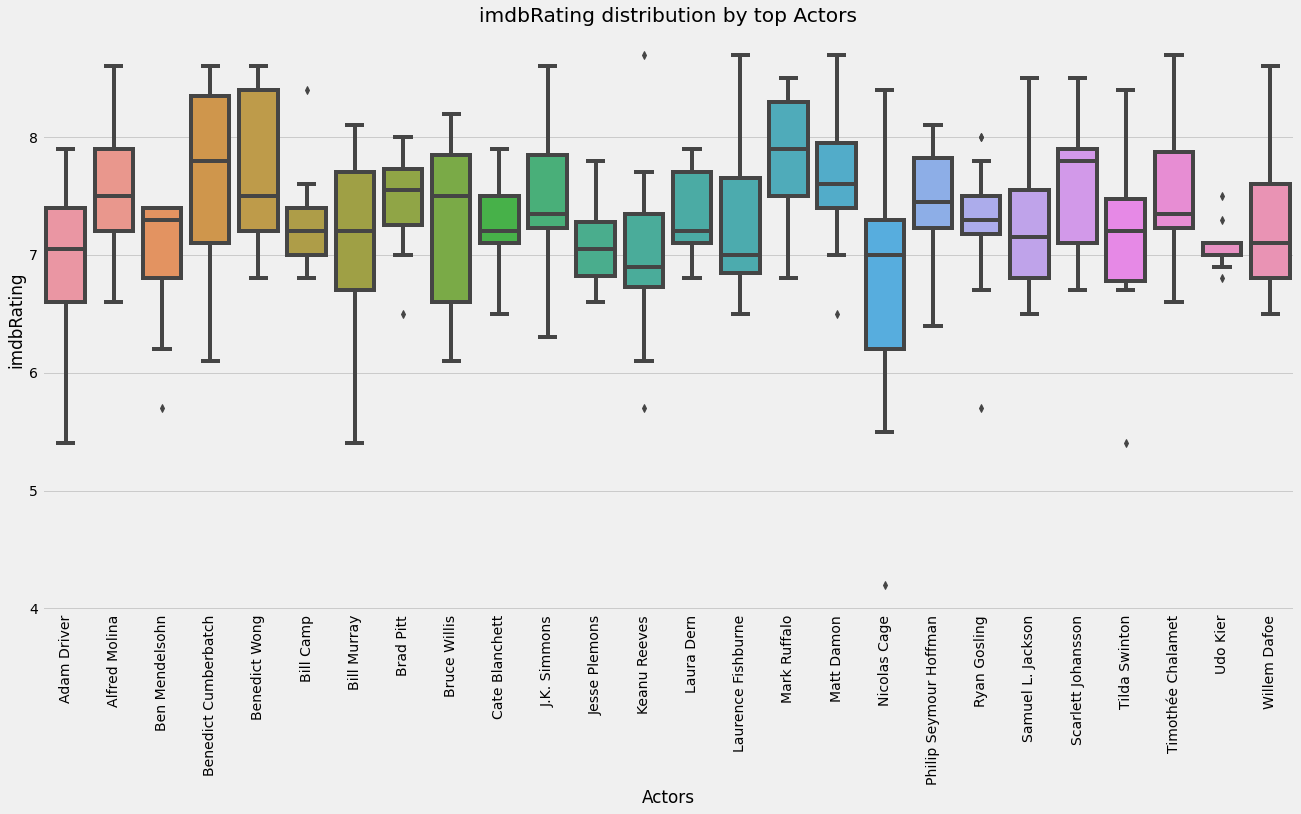

In [351]:
# Movie rating distribution by top Actors
df_dist_top_actor = df_actors.copy()

df_dist_top_actor.Actors = df_dist_top_actor.Actors.str.split(',').apply(lambda x: [e.strip() for e in x])
df_dist_top_actor = explode(df_dist_top_actor, ['Actors'])

df_dist_top_actor = df_dist_top_actor[df_dist_top_actor.Actors.str.contains('|'.join(list_top_actors))]
df_dist_top_actor = df_dist_top_actor[['Actors','imdbRating']].sort_values(by='Actors')

x = df_dist_top_actor.Actors
y = df_dist_top_actor.imdbRating

_, ax = plt.subplots(figsize=(20,10))
sns.boxplot(x, y)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90) 

plt.title('imdbRating distribution by top Actors')
plt.show()

In [352]:
# Actors with most movies watched
show_all(df_actor_rating.nlargest(N, 'Total', keep='all'))

In [353]:
# Highest rating actors
show_all(df_actor_rating[df_actor_rating.Total > 2].nlargest(N, 'imdbRating', keep='all')) # multiple results from The Godfather trilogy

In [354]:
# Lowest rating actors
show_all(df_actor_rating[df_actor_rating.Total > 1].nsmallest(N, 'imdbRating', keep='all'))

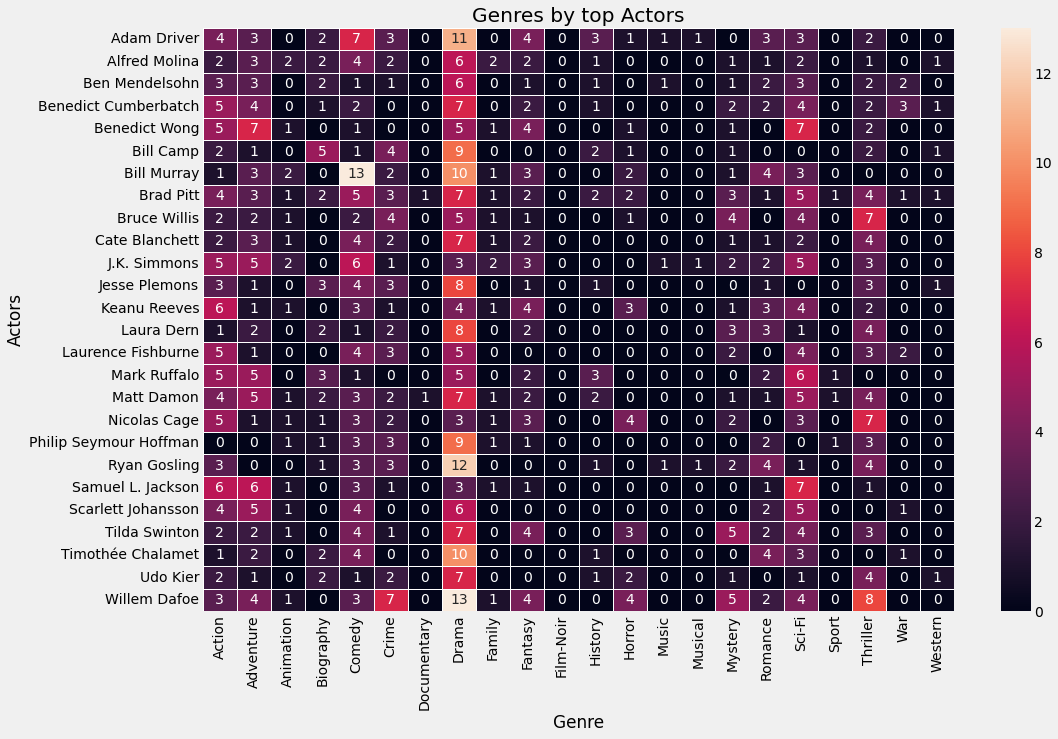

In [355]:
# Genre by Actor
df_genre_actor = df_actors.copy()

df_genre_actor.Genre = df_genre_actor.Genre.str.split(',').apply(lambda x: [e.strip() for e in x])
df_genre_actor = explode(df_genre_actor, ['Genre'])
df_genre_actor.Actors = df_genre_actor.Actors.str.split(',').apply(lambda x: [e.strip() for e in x])
df_genre_actor = explode(df_genre_actor, ['Actors'])

# Top actors
ct_actor_genre = pd.crosstab(df_genre_actor.Actors, df_genre_actor.Genre).loc[list_top_actors]

# Plot
_, ax = plt.subplots(figsize=(15, 10))

plt.title('Genres by top Actors')
ax = sns.heatmap(ct_actor_genre, annot=True, fmt="d", linewidths=.5, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90);

In [356]:
# Top actor in each genre
df_genre_top_actor = df_genre_actor.groupby(['Actors','Genre']).agg({'Title':['nunique','; '.join]}).sort_values(('Title','nunique'), ascending=False).reset_index()
df_genre_top_actor = df_genre_top_actor.groupby('Genre').apply(lambda x: x.nlargest(1, ('Title','nunique'), keep='first'))
df_genre_top_actor = df_genre_top_actor.droplevel(1).drop('Genre', axis=1)

show_all(df_genre_top_actor)

In [357]:
## search by specific actor
#df[df.Actors.str.contains('Tom Holland')] # Tom Holland != Tom Hollander

## Country

In [358]:
# Set country dataframe
cols = ['Title','Year','Country','imdbRating','Date']

df_country = df[cols].copy()

In [359]:
# Number of different countries
df_country_counter = counter_display(df_country, 'Country', 'Title', None)

len(df_country_counter.index)

65

In [360]:
# Country of last watched movies
N = 10

df_country.tail(N)

Title  Year         Country  imdbRating  \
885                             Elephant  2003   United States         7.1   
886                                House  1977           Japan         7.3   
887  The Last Black Man in San Francisco  2019   United States         7.3   
888            The Many Saints of Newark  2021   United States         6.3   
889              Spider-Man: No Way Home  2021   United States         8.6   
890                          Turning Red  2022   United States         7.1   
891                   Lawrence of Arabia  1962  United Kingdom         8.3   
892                     Save Yourselves!  2020   United States         5.7   
893                                Comet  2014   United States         6.7   
894                             Plus One  2019   United States         6.6   

          Date  
885 2022-03-08  
886 2022-03-09  
887 2022-03-10  
888 2022-03-11  
889 2022-03-12  
890 2022-03-12  
891 2022-03-13  
892 2022-03-14  
893 2022-03-15  
894 2022-03-16

In [361]:
# Top countries
TOP = 30

# Simple solution without filtering by year 
#df_country_counter.nlargest(N, 'Title', keep='all')

# create dataframe
for year in years:
    if year == years[0]:
        df_country_counter_year = counter_display(df_country[df_country.Date.dt.year == year], 'Country', 'Title', None).copy()
        df_country_counter_year = df_country_counter_year.reset_index()
        df_country_counter_year.columns = ['index', year]
    else:
        add_country = counter_display(df_country[df_country.Date.dt.year == year], 'Country', 'Title', None).reset_index()
        add_country.columns = ['index',year]
        # merge new year counter
        df_country_counter_year = df_country_counter_year.merge(add_country, how='outer', on='index')

df_country_counter_year.rename(columns={'index':'Country'}, inplace=True)
df_country_counter_year.set_index('Country', inplace=True)
df_country_counter_year = df_country_counter_year.fillna(0).astype(int)

# add 'All' column with sum by country
df_country_counter_year.loc[:,'All'] = df_country_counter_year.sum(axis=1)
# show TOP countries
df_country_counter_year = df_country_counter_year.nlargest(TOP, 'All', keep='all')

df_country_counter_year.style.background_gradient(subset=df_country_counter_year.columns[:-1], axis=1) # evaluate by country

# Top 2 countries always US and UK
# 2021 holds most top results per country since it was the year with clearly most movies watched

In [362]:
# Country average rating
df_country_rat = get_mean_value(df_country, 'Country', 'imdbRating')

# List top countries
top_countries = df_country_counter.index[:3] # to drop top 3 countries

df_country_filter = df_country_rat.reset_index() 
df_country_filter = df_country_filter[~df_country_filter.Country.isin(top_countries)].set_index('Country')

## 50% quantile
#qtl05 = df_country_counter.quantile(0.5)[0]
df_top_country_rat = df_country_filter[df_country_filter.Total > 3].nlargest(N, 'imdbRating', keep='all')

show_all(df_top_country_rat)

## Language

In [363]:
# Set language dataframe
cols = ['Title','Year','imdbRating','Language','Date']

df_language = df[cols].copy()

In [364]:
# Number of different languages
df_language_counter = counter_display(df, 'Language', 'Title', None)

len(df_language_counter.index)

98

In [365]:
# Language of last watched movies
N = 10

df_language.tail(N)

Title  Year  imdbRating  \
885                             Elephant  2003         7.1   
886                                House  1977         7.3   
887  The Last Black Man in San Francisco  2019         7.3   
888            The Many Saints of Newark  2021         6.3   
889              Spider-Man: No Way Home  2021         8.6   
890                          Turning Red  2022         7.1   
891                   Lawrence of Arabia  1962         8.3   
892                     Save Yourselves!  2020         5.7   
893                                Comet  2014         6.7   
894                             Plus One  2019         6.6   

                     Language       Date  
885           English, German 2022-03-08  
886                  Japanese 2022-03-09  
887                   English 2022-03-10  
888   English, Italian, Latin 2022-03-11  
889                   English 2022-03-12  
890                   English 2022-03-12  
891  English, Arabic, Turkish 2022-03-13  
892                   English 2022-03-14  
893                   English 2022-03-15  
894                   English 2022-03-16

In [366]:
# Top languages
TOP = 30

# Simple solution without filtering by year 
#df_language_counter.nlargest(N, 'Title', keep='all')

# create dataframe
for year in years:
    if year == years[0]:
        df_language_counter_year = counter_display(df_language[df_language.Date.dt.year == year], 'Language', 'Title', None).copy()
        df_language_counter_year = df_language_counter_year.reset_index()
        df_language_counter_year.columns = ['index', year]
    else:
        add_language = counter_display(df_language[df_language.Date.dt.year == year], 'Language', 'Title', None).reset_index()
        add_language.columns = ['index',year]
        # merge new year counter
        df_language_counter_year = df_language_counter_year.merge(add_language, how='outer', on='index')

df_language_counter_year.rename(columns={'index':'Language'}, inplace=True)
df_language_counter_year.set_index('Language', inplace=True)
df_language_counter_year = df_language_counter_year.fillna(0).astype(int)

# add 'All' column with sum by language
df_language_counter_year.loc[:,'All'] = df_language_counter_year.sum(axis=1)
# show TOP languages
df_language_counter_year = df_language_counter_year.nlargest(TOP, 'All', keep='all')

df_language_counter_year.style.background_gradient(subset=df_language_counter_year.columns[:-1], axis=1) # evaluate by languange

In [367]:
# Language average rating
df_language_rat = get_mean_value(df_language, 'Language', 'imdbRating')

# List top languages
top_countries = df_language_counter.index[:3] # drop top 3 languages (english, french, spanish)

df_language_filter = df_language_rat.reset_index() 
df_language_filter = df_language_filter[~df_language_filter.Language.isin(top_countries)].set_index('Language')

## 50% quantile
#qtl05 = df_language_counter.quantile(0.5)[0]
df_top_language_rat = df_language_filter[df_language_filter.Total > 3].nlargest(N, 'imdbRating', keep='all')

show_all(df_top_language_rat)

## Rating

In [368]:
# Example
# https://codingnomads.co/blog/data-analysis-example-analyzing-movie-ratings-with-python/

In [369]:
# Set rating dataframe
cols = ['Title','Year','Runtime','Genre','Metascore','imdbRating','imdbVotes','Date']

df_rating = df[cols].copy()

In [370]:
# imdbRating and Metascore stats
df_rating[['imdbRating', 'Metascore']][df.Metascore != 0].describe().round(2)

imdbRating  Metascore
count      787.00     787.00
mean         7.15      71.50
std          0.66      12.62
min          3.60       9.00
25%          6.70      64.00
50%          7.10      72.00
75%          7.60      81.00
max          9.20     100.00

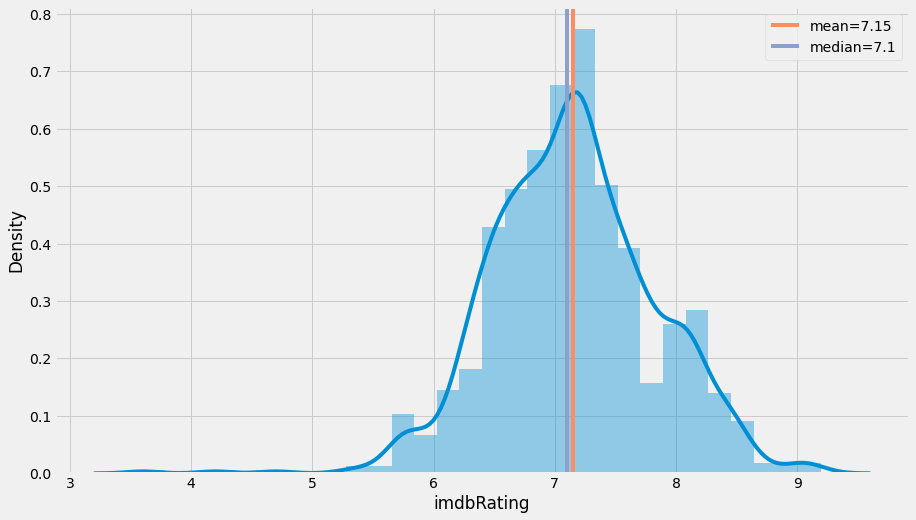

In [371]:
# Plot imdbRating
plt.figure(figsize=(30,8))
plt.subplot(1,2,1)

plot_rating = df_rating['imdbRating']

ax1 = sns.distplot(plot_rating, kde_kws=dict(bw=0.2))
ax1.axvline(x=plot_rating.mean(), c=sns.color_palette("Set2")[1], label=f"mean={round(plot_rating.mean(), 2)}")
ax1.axvline(x=plot_rating.median(), c=sns.color_palette("Set2")[2], label=f"median={round(plot_rating.median(), 2)}")
plt.legend();

In [372]:
## https://en.wikipedia.org/wiki/Kurtosis
# Like skewness, kurtosis describes the shape of a probability distribution and there are different ways of quantifying it for a theoretical distribution 
# and corresponding ways of estimating it from a sample from a population
plot_rating.kurtosis()

1.0670528097757037

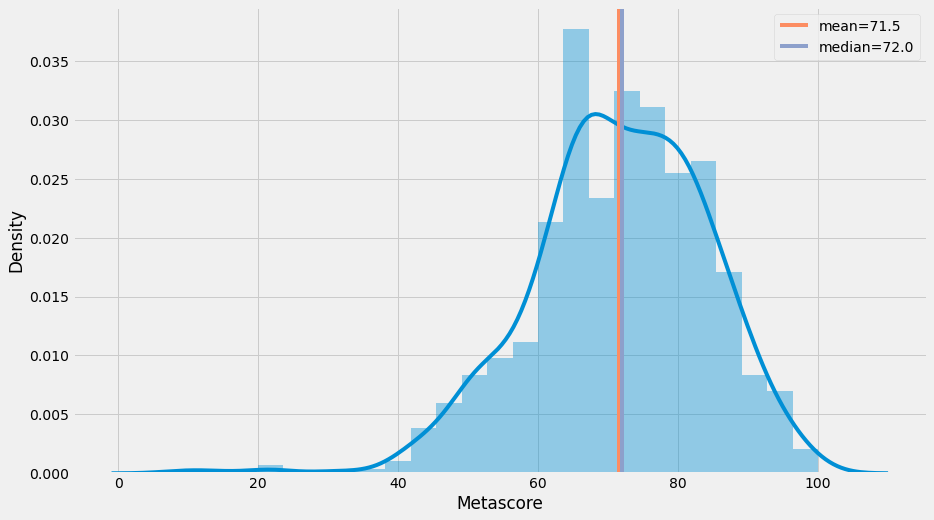

In [373]:
# Plot Metascore
plot_meta = df_rating[df_rating.Metascore != 0].Metascore

plt.figure(figsize=(30,8))
plt.subplot(1,2,1)

ax1 = sns.distplot(plot_meta) #, kde_kws=dict(bw=0.2))
ax1.axvline(x=plot_meta.mean(), c=sns.color_palette("Set2")[1], label=f"mean={round(plot_meta.mean(), 2)}")
ax1.axvline(x=plot_meta.median(), c=sns.color_palette("Set2")[2], label=f"median={round(plot_meta.median(), 2)}")
plt.legend();

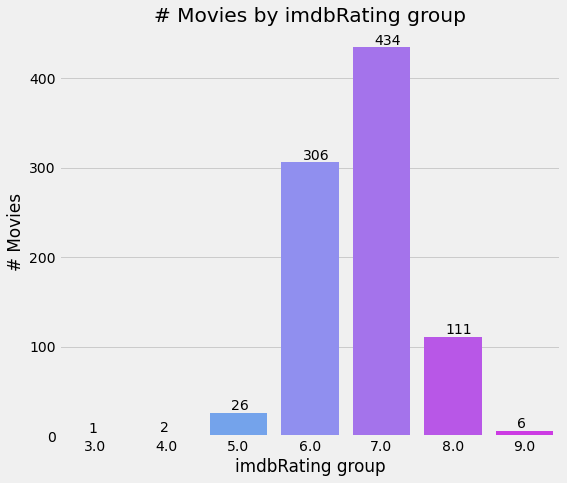

In [374]:
# Number of movies by imdbRating group
df_rating_group = df_rating[['Title', 'imdbRating']].groupby((df_rating.imdbRating//1)).agg({'Title': 'count'})

x = df_rating_group.index
y = df_rating_group.Title

plt.figure(figsize=(8,7))
sns.barplot(x=x, y=y, palette="cool");

for i, rate in enumerate(y):
    plt.text(i-0.1, rate+3, rate)

plt.title('# Movies by imdbRating group')
plt.xlabel('imdbRating group')
plt.ylabel('# Movies')
plt.show()

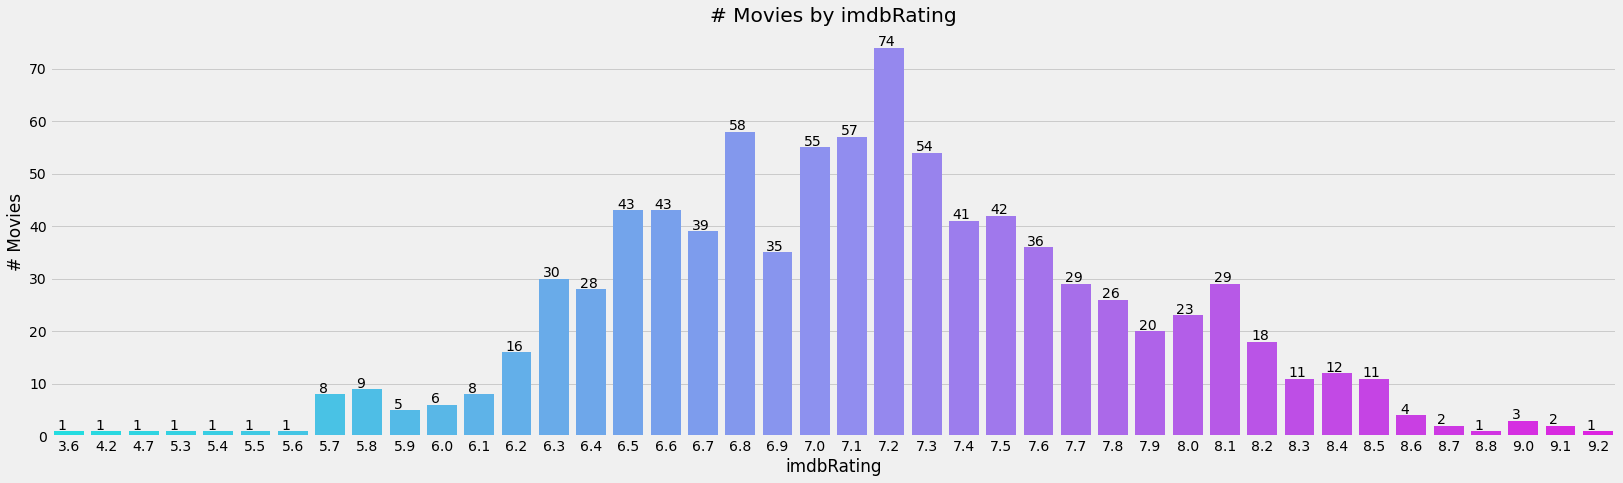

In [375]:
# Number of movies by imdbRating value
df_rating_float = df_rating[['Title', 'imdbRating']].groupby((df_rating.imdbRating)).agg({'Title': 'count'})

x = np.round(df_rating_float.index, 1)
y = df_rating_float.Title

plt.figure(figsize=(25,7))
sns.barplot(x=x, y=y, palette="cool");

for i, rate in enumerate(y):
    plt.text(i-0.3, rate+0.3, rate)

plt.title('# Movies by imdbRating')
plt.ylabel('# Movies')
plt.show()

In [376]:
# search by rating
rating = 6

df_rating[df_rating.imdbRating < rating][['Title','Runtime','imdbRating']].sort_values(by='imdbRating')

Title  Runtime  imdbRating
193                           The Room       99         3.6
841         Prisoners of the Ghostland      103         4.2
204     The First Temptation of Christ       46         4.7
169                           Geostorm      109         5.3
205                 The Dead Don't Die      104         5.4
455                 Willy's Wonderland       88         5.5
690                        Fried Barry       99         5.6
840               The Greasy Strangler       93         5.7
814                         Lost River       95         5.7
789           The Matrix Resurrections      148         5.7
767                  Only God Forgives       90         5.7
685   Cicliste per Caso - Grizzly Tour       67         5.7
658             A Classic Horror Story       95         5.7
892                   Save Yourselves!       93         5.7
550                   Army of the Dead      148         5.7
530       The Babysitter: Killer Queen      101         5.8
675                         Underwater       95         5.8
516                          Hagazussa      102         5.8
487                          High Life      113         5.8
761                           PVT CHAT       86         5.8
460                           Vivarium       97         5.8
333  An Evening with Beverly Luff Linn      108         5.8
202                   The Little Hours       90         5.8
640                           The Void       90         5.8
870                                Cam       94         5.9
648           The Blackcoat's Daughter       93         5.9
469               Expedition Happiness       95         5.9
187                         Horse Girl      103         5.9
864                   Uncle Peckerhead       97         5.9

In [377]:
# Movies watched this year below rating (see above)
this_year = now.year 

df_rating[df_rating.Date.dt.year == this_year][df_rating.imdbRating < rating][['Title','Runtime','imdbRating']].sort_values(by='imdbRating')

Title  Runtime  imdbRating
841  Prisoners of the Ghostland      103         4.2
814                  Lost River       95         5.7
840        The Greasy Strangler       93         5.7
892            Save Yourselves!       93         5.7
864            Uncle Peckerhead       97         5.9
870                         Cam       94         5.9

In [378]:
# Movies with highest rating watched this year
df_this_year = df_rating[df_rating.Date.dt.year == this_year]

# no documentaries, no duplicated
df_this_year = df_this_year[~df_this_year.Genre.str.contains('Documentary')][~df.duplicated(['Title','Year'], keep='last')]
df_this_year.nlargest(N, 'imdbRating', keep='all')

Title  Year  Runtime  \
795             Interstellar  2014      169   
889  Spider-Man: No Way Home  2021      148   
806              City Lights  1931       87   
810             Modern Times  1936       87   
853                  Amadeus  1984      160   
873       The Great Dictator  1940      125   
801                  The Kid  1921       68   
891       Lawrence of Arabia  1962      218   
797             Sherlock Jr.  1924       45   
798              The General  1926       67   

                                     Genre  Metascore  imdbRating  imdbVotes  \
795               Adventure, Drama, Sci-Fi         74         8.7    1697870   
889     Action, Adventure, Fantasy, Sci-Fi         71         8.6     510006   
806                 Comedy, Drama, Romance         99         8.5     180139   
810                 Comedy, Drama, Romance         96         8.5     234974   
853                Biography, Drama, Music         88         8.4     390445   
873                     Comedy, Drama, War          0         8.4     218243   
801                  Comedy, Drama, Family          0         8.3     123400   
891       Adventure, Biography, Drama, War        100         8.3     285927   
797                Action, Comedy, Romance          0         8.2      47795   
798  Action, Adventure, Comedy, Drama, War          0         8.2      89042   

          Date  
795 2022-01-01  
889 2022-03-12  
806 2022-01-05  
810 2022-01-09  
853 2022-02-06  
873 2022-02-24  
801 2022-01-03  
891 2022-03-13  
797 2022-01-01  
798 2022-01-01

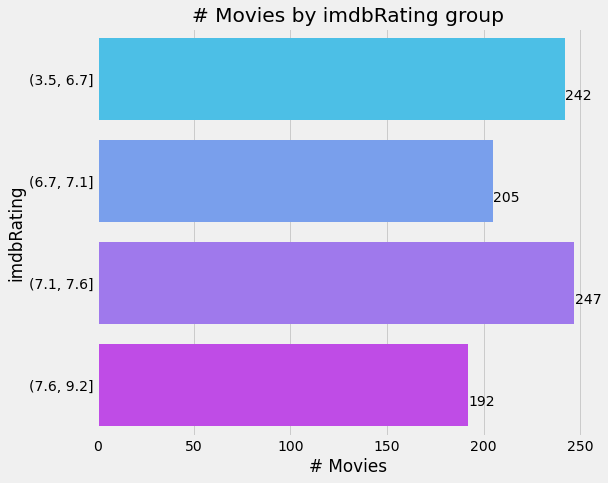

In [379]:
# Number of movies by imdbRating group

# https://medium.com/analytics-vidhya/exploratory-data-analysis-imdb-dataset-cff0c3991ad5
[groups, edges] = pd.qcut(df_rating.imdbRating, q=4, precision=1, retbins=True) # 4 for quartiles
ratings_avg = df_rating.groupby(groups).agg({"Title": 'count'})

plt.figure(figsize=(8,7))
sns.barplot(y=ratings_avg.index, x=ratings_avg.Title, palette='cool')
plt.title('# Movies by imdbRating group')
plt.xlabel('# Movies')

for i, rate in enumerate(ratings_avg["Title"]):
    plt.text(rate+0.1, i+0.2, rate)

plt.show()

### Hidden Gems

In [380]:
# Select columns and data
df_hidden_gems = df_rating.copy()

# General filter
df_hidden_gems = df_hidden_gems[df_hidden_gems.Year < now.year-1]
df_hidden_gems = df_hidden_gems[~df_hidden_gems.Genre.str.contains('Documentary')]

df_hidden_gems['Metascore'].replace('N/A', 0, regex=True, inplace=True)
df_hidden_gems['Metascore'] = df_hidden_gems['Metascore'].astype(int)

# Sum imdbRating with normalized metascore to create a global rating
df_hidden_gems['Rate20'] = df_hidden_gems['imdbRating'] + (df_hidden_gems['Metascore'] / 10)
df_hidden_gems_stats = df_hidden_gems.describe().round(1)

# Select columns to show statistics
cols = df_hidden_gems_stats.columns.values
cols = np.delete(cols, [3,5])

# Stats
df_hidden_gems_stats[cols] = df_hidden_gems_stats[cols].astype(int)
df_hidden_gems_stats

Year  Runtime  Metascore  imdbRating  imdbVotes  Rate20
count   741      741        741       741.0        741   741.0
mean   2009      111         64         7.1     163420    13.6
std      14       21         24         0.7     254594     2.7
min    1921       41          0         3.6        671     4.5
25%    2006       96         61         6.7      21084    12.9
50%    2016      108         70         7.1      73439    14.1
75%    2018      123         80         7.6     194675    15.3
max    2020      218        100         9.2    2505046    19.2

In [381]:
# Filter by number of votes and rating
vote_qtl = df_hidden_gems.imdbVotes.quantile(0.25) # less than 25% quantile of votes
rate20_qtl = df_hidden_gems.Rate20.quantile(0.5) # more than 50% quantile of rate20 (imdbRating + Metascore*)

df_hidden_gems = df_hidden_gems[df_hidden_gems.imdbVotes < vote_qtl][df_hidden_gems.Rate20 > rate20_qtl]

In [382]:
# Hidden gems watched by Year
[
    [
        print(str(year)),
        show_all(df_hidden_gems[df_hidden_gems.Date.dt.year == year].nlargest(20, 'Rate20', keep='all')),
        print('\n')
    ] for year in years
];

2018




2019




2020




2021




2022


### Runtime / imdbRating

In [383]:
# Correlation?
df_rating[['Runtime','imdbRating']].corr(method='pearson').round(2)

Runtime  imdbRating
Runtime        1.00        0.27
imdbRating     0.27        1.00

In [384]:
# Stats
df_runtime_rating = df_rating[['Runtime','imdbRating']].copy()
df_runtime_rating.describe().round(1)

Runtime  imdbRating
count    886.0       886.0
mean     110.3         7.1
std       21.8         0.7
min       40.0         3.6
25%       95.0         6.7
50%      107.0         7.1
75%      123.0         7.6
max      218.0         9.2

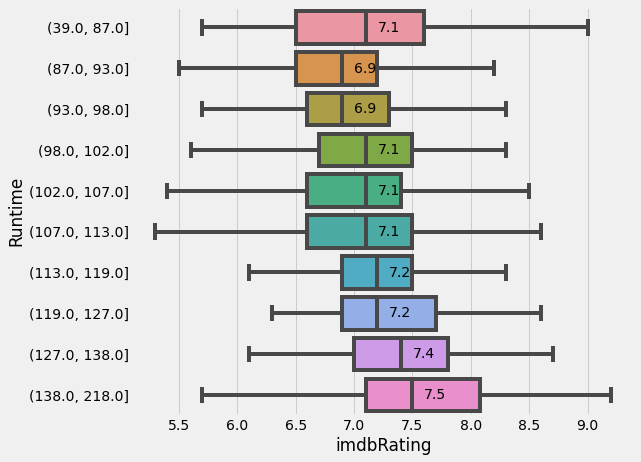

In [385]:
# https://medium.com/analytics-vidhya/exploratory-data-analysis-imdb-dataset-cff0c3991ad5
[groups, edges] = pd.qcut(df_runtime_rating.Runtime, 10, precision=0, retbins=True)
ratings_avg = df_runtime_rating.groupby(groups).agg({"imdbRating": np.median})

plt.figure(figsize=(8,7))
sns.boxplot(y=groups, x="imdbRating", data=df_runtime_rating, orient="h", showfliers=False)

for i, rate in enumerate(ratings_avg["imdbRating"]):
    plt.text(rate+0.1, i+0.1, round(rate,1))

plt.show()

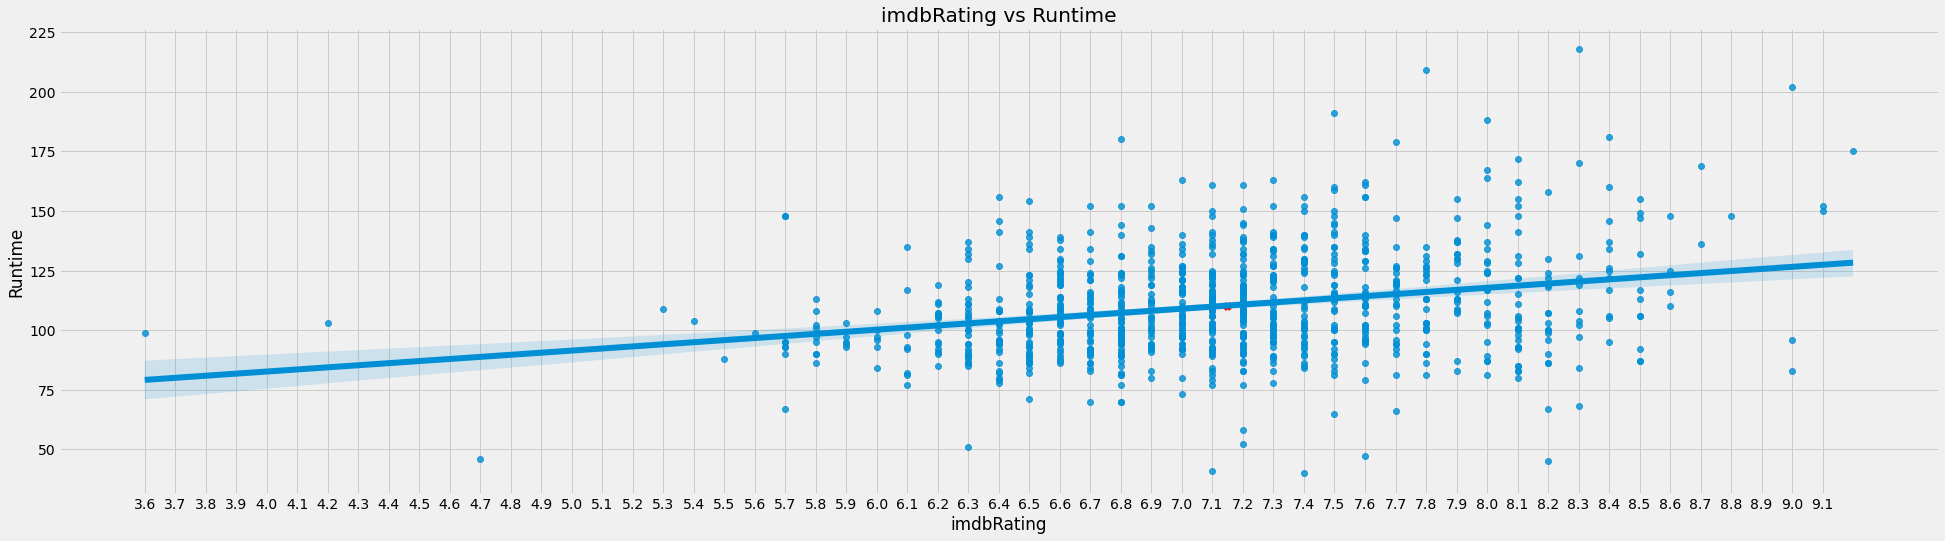

In [386]:
# Movie centroid based on runtime and imdbRating
x = df_runtime_rating.imdbRating
y = df_runtime_rating.Runtime
centroid = df_runtime_rating.mean(axis=0) # centroid

plt.figure(figsize=(30, 8))  
sns.regplot(x=x, y=y); 
plt.scatter(centroid[1], centroid[0], color='r', marker='x');

plt.xticks(np.arange(x.min(), x.max(), step=0.1))
plt.title('imdbRating vs Runtime')
plt.show()

In [387]:
# https://stackoverflow.com/questions/45418353/get-nearest-coordinates-from-pandas-df-from-centroid-of-coordinates

# The center will just be the average x and y 
# plotme.sub(plotme.mean()).pow(2).sum(1).idxmin()
#df.loc[plotme.loc[[plotme.sub(plotme.mean()).pow(2).sum(1).idxmin()]].index]

centroid

Runtime       110.294582
imdbRating      7.149210
dtype: float64

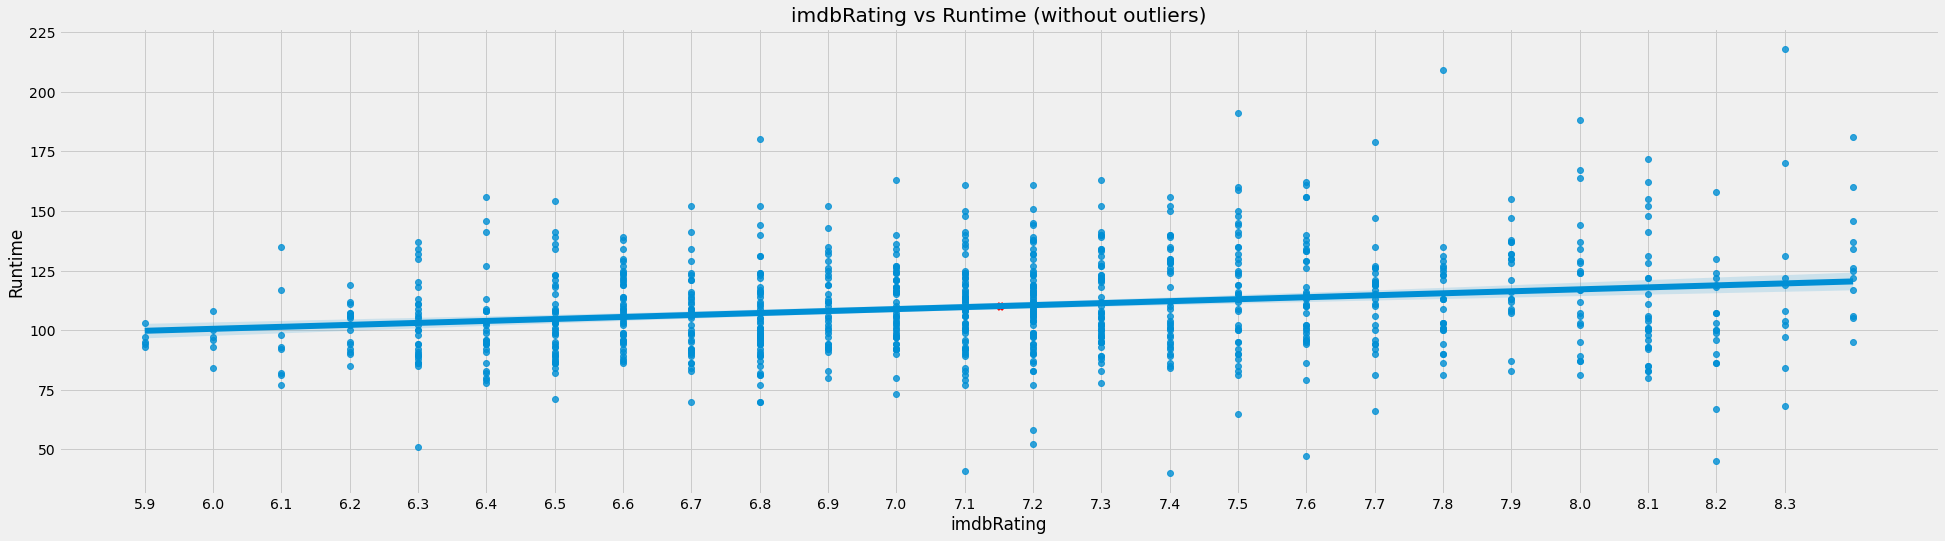

In [388]:
# https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
# Movie centroid based on runtime and imdbRating
# without outliers
df_runtime_rating = df_runtime_rating[np.abs(df_runtime_rating.imdbRating - df_runtime_rating.imdbRating.mean())
                                      <= (2*df_runtime_rating.imdbRating.std())] # 2 std

x = df_runtime_rating.imdbRating
y = df_runtime_rating.Runtime
centroid = df_runtime_rating.mean(axis=0) # centroid

plt.figure(figsize=(30, 8))
sns.regplot(x=x, y=y); 
plt.scatter(centroid[1], centroid[0], color='r', marker='x');

plt.xticks(np.arange(x.min(), x.max(), step=0.1))
plt.title('imdbRating vs Runtime (without outliers)')
plt.show()

In [389]:
# There's no big difference without outliers
centroid

Runtime       110.096659
imdbRating      7.152267
dtype: float64

In [390]:
# Movie closer to centroid, based on runtime and imdbRating
# sub - subtract mean runtime and rating values
# pow - exponential power
# sum - sum both columns (runtime, imdbRating)
# idxmin - get id of min value
id_min_diff = df_runtime_rating.sub(df_runtime_rating.mean()).pow(2).sum(1).idxmin()
df.loc[df_runtime_rating.loc[[id_min_diff]].index].iloc[:,:-6]

Title  Year   imdbID Rated  Runtime  Genre        Director  \
462  Palmer  2021  6857376     R      110  Drama  Fisher Stevens   

               Writer Cinematographers  \
462  Cheryl Guerriero              N/A   

                                                Actors  \
462  Justin Timberlake, Ryder Allen, Alisha Wainwri...   

                                                  Plot Language  \
462  An ex-convict strikes up a friendship with a b...  English   

           Country  Metascore  imdbRating  imdbVotes  \
462  United States         53         7.2      32542   

                                            Production           Timestamp  \
462  Sidney Kimmel Entertainment, Hercules Film Fun... 2021-02-28 23:31:37   

          Date      Time  
462 2021-02-28  23:31:37

In [391]:
# Three closest movies to centroid (runtime / rating)
id_min_3diff = df_runtime_rating.sub(df_runtime_rating.mean()).pow(2).sum(1).nsmallest(3).index
df.loc[df_runtime_rating.loc[id_min_3diff].index].iloc[:,:-6]

Title  Year   imdbID      Rated  Runtime  \
462  Palmer  2021  6857376          R      110   
518  Pusher  1996  0117407  Not Rated      110   
77   Border  2018  5501104          R      110   

                                                 Genre              Director  \
462                                              Drama        Fisher Stevens   
518                                    Crime, Thriller  Nicolas Winding Refn   
77   Crime, Drama, Fantasy, Mystery, Romance, Thriller            Ali Abbasi   

                                                Writer Cinematographers  \
462                                   Cheryl Guerriero              N/A   
518                    Jens Dahl, Nicolas Winding Refn              N/A   
77   Isabella Eklöf, Ali Abbasi, John Ajvide Lindqvist              N/A   

                                                Actors  \
462  Justin Timberlake, Ryder Allen, Alisha Wainwri...   
518  Kim Bodnia, Zlatko Buric, Laura Drasbæk, Slavk...   
77   Eva Melander, Eero Milonoff, Jörgen Thorsson, ...   

                                                  Plot  \
462  An ex-convict strikes up a friendship with a b...   
518  A drug pusher grows increasingly desperate aft...   
77   A customs officer who can smell fear develops ...   

                              Language          Country  Metascore  \
462                            English    United States         53   
518  Danish, Swedish, Serbian, English          Denmark         72   
77                    Swedish, English  Sweden, Denmark         75   

     imdbRating  imdbVotes                                         Production  \
462         7.2      32542  Sidney Kimmel Entertainment, Hercules Film Fun...   
518         7.3      38803                               Balboa Entertainment   
77          7.0      28427  Meta Film Stockholm, Black Spark Film & TV, Kä...   

              Timestamp       Date      Time  
462 2021-02-28 23:31:37 2021-02-28  23:31:37  
518 2021-04-19 23:40:57 2021-04-19  23:40:57  
77  2019-03-16 00:32:00 2019-03-16  00:32:00

### Metascore / imdbRating

In [392]:
df_metaimdb = df_rating[~df_rating.Metascore.isnull()]
df_metaimdb = df_metaimdb[df_metaimdb.Metascore != 0]
df_metaimdb['Metascore'] = df_metaimdb['Metascore'].fillna(0).astype(int)

# Correlation?
df_metaimdb[['Metascore','imdbRating']].corr(method='pearson').round(2)

Metascore  imdbRating
Metascore         1.0         0.5
imdbRating        0.5         1.0

In [393]:
# Convert Metascore to range 0-10
df_metaimdb['Meta10'] = df_metaimdb['Metascore'] / 10
# Difference between imdbRating and normalized Metascore
df_metaimdb['imdbMeta'] = df_metaimdb['imdbRating'] - df_metaimdb['Meta10']

# Reorder and select
cols = ['Title','Year','Genre','imdbRating','Meta10','imdbMeta']
df_metaimdb = df_metaimdb[cols]
df_metaimdb['Year'] = df_metaimdb.Year.astype(int)

# Stats
df_metaimdb[['imdbRating','Meta10','imdbMeta']].describe().round(1)

imdbRating  Meta10  imdbMeta
count       787.0   787.0     787.0
mean          7.2     7.2       0.0
std           0.7     1.3       1.1
min           3.6     0.9      -2.4
25%           6.7     6.4      -0.8
50%           7.1     7.2      -0.1
75%           7.6     8.1       0.7
max           9.2    10.0       5.1

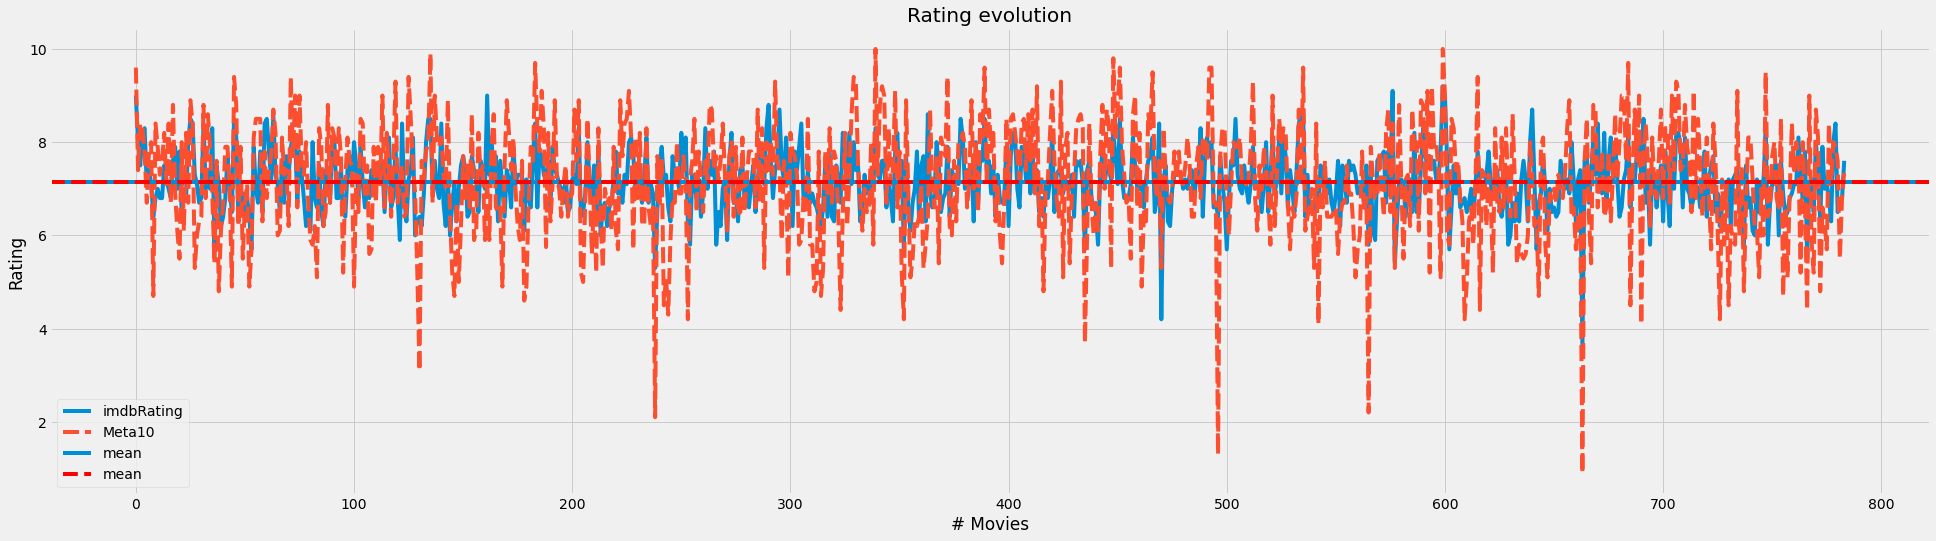

In [444]:
# imdbRating vs Meta10 variance
cols = ['Title','imdbRating','Meta10']
plot_imdbVSmeta = df_metaimdb[cols].groupby('Title').mean()
plot_imdbVSmeta = plot_imdbVSmeta.reset_index(drop=True)

x = plot_imdbVSmeta.imdbRating
y = plot_imdbVSmeta.Meta10

plt.figure(figsize=(30,8))
sns.lineplot(data=plot_imdbVSmeta)

plt.axhline(y=x.mean(), label='mean')
plt.axhline(y=y.mean(), color='red', ls='--', label='mean')

plt.title('Rating evolution')
plt.xlabel('# Movies')
plt.ylabel('Rating')

plt.legend()
plt.show()

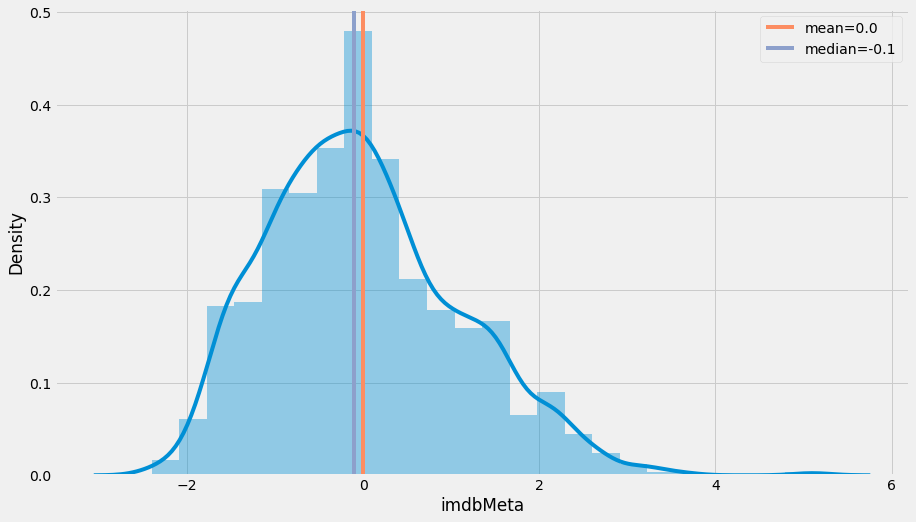

In [442]:
# imdbMeta - difference between imdbRating and Metascore (converted to 0 to 10)
plt.figure(figsize=(30,8))

plot_metaimdb = df_metaimdb['imdbMeta']

plt.subplot(1,2,1)
ax1 = sns.distplot(plot_metaimdb, kde_kws=dict(bw=0.2))
ax1.axvline(x=plot_metaimdb.mean(), c=sns.color_palette("Set2")[1], label=f"mean={round(plot_metaimdb.mean(), 2)}")
ax1.axvline(x=plot_metaimdb.median(), c=sns.color_palette("Set2")[2], label=f"median={round(plot_metaimdb.median(), 2)}")

plt.legend()
plt.show()

In [396]:
# Top differences between ratings
df_metaimdb.loc[abs(df_metaimdb.imdbMeta).sort_values(ascending=False).index].nlargest(N, 'imdbMeta', keep='all')

Title  Year  \
612                 Run Hide Fight  2020   
530   The Babysitter: Killer Queen  2020   
312             Charlie Countryman  2013   
169                       Geostorm  2017   
788               The Unforgivable  2021   
490              Bohemian Rhapsody  2018   
250  Twin Peaks: Fire Walk with Me  1992   
829        Ghostbusters: Afterlife  2021   
193                       The Room  2003   
317                  The Gentlemen  2019   

                                        Genre  imdbRating  Meta10  imdbMeta  
612                    Crime, Drama, Thriller         6.4     1.3       5.1  
530                            Comedy, Horror         5.8     2.2       3.6  
312  Action, Comedy, Drama, Romance, Thriller         6.4     3.1       3.3  
169                  Action, Sci-Fi, Thriller         5.3     2.1       3.2  
788                              Crime, Drama         7.2     4.1       3.1  
490                   Biography, Drama, Music         8.0     4.9       3.1  
250          Drama, Horror, Mystery, Thriller         7.2     4.5       2.7  
829        Adventure, Comedy, Fantasy, Sci-Fi         7.2     4.5       2.7  
193                                     Drama         3.6     0.9       2.7  
317                     Action, Comedy, Crime         7.8     5.1       2.7

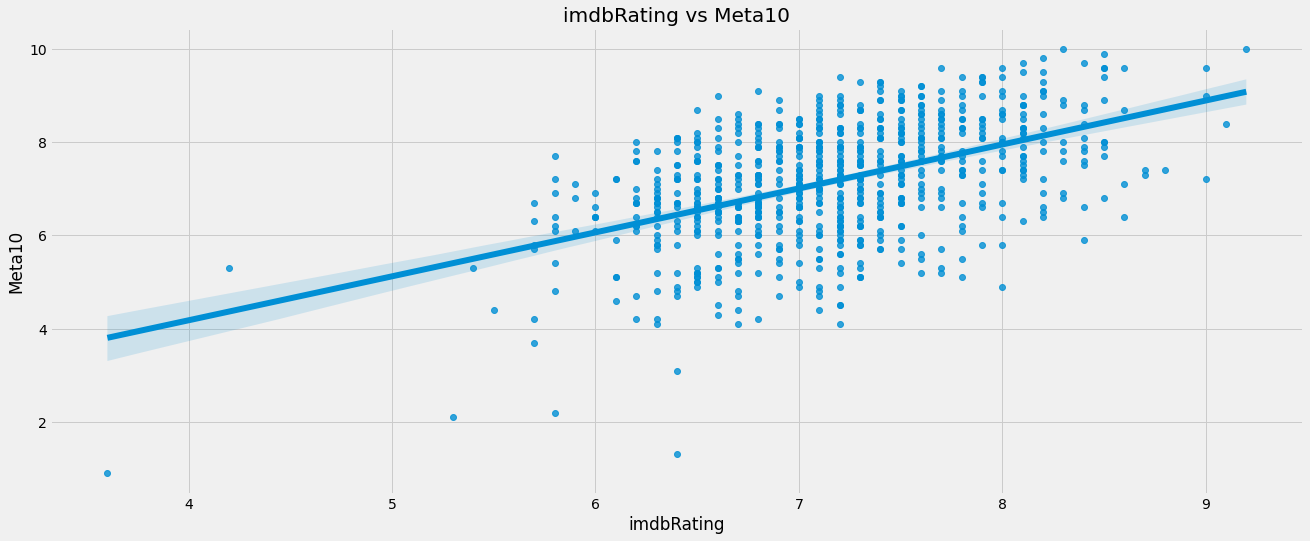

In [397]:
# Relationship between variables (all data)
xx = df_metaimdb.imdbRating
yy = df_metaimdb.Meta10

# https://stackoverflow.com/questions/19068862/how-to-overplot-a-line-on-a-scatter-plot-in-python
plt.figure(figsize=(20, 8))
sns.regplot(x=xx, y=yy)

plt.title('imdbRating vs Meta10'); 

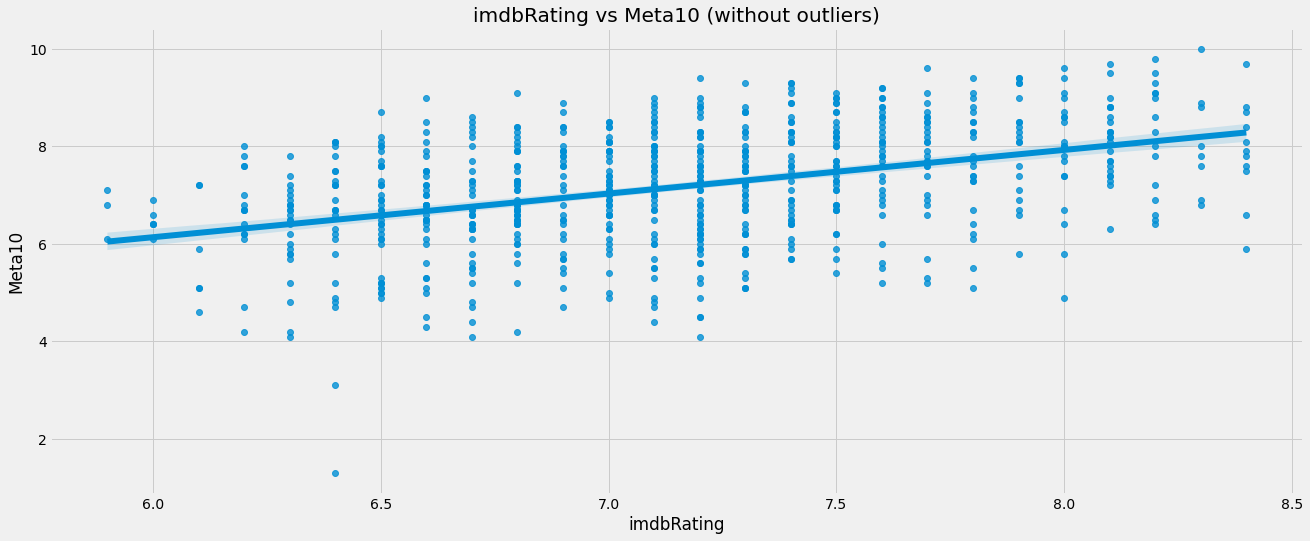

In [398]:
# Without outliers
df_metaimdb_noout = df_metaimdb[np.abs(df_metaimdb.imdbRating - df_metaimdb.imdbRating.mean()) 
                                <= (2*df_metaimdb.imdbRating.std())] # 2 std

xx = df_metaimdb_noout.imdbRating
yy = df_metaimdb_noout.Meta10

# https://stackoverflow.com/questions/19068862/how-to-overplot-a-line-on-a-scatter-plot-in-python
plt.figure(figsize=(20, 8))
sns.regplot(x=xx, y=yy)

plt.title('imdbRating vs Meta10 (without outliers)'); 

In [399]:
# better Metascore than imdbRating
print('Movies with better Metascore than imdbRating: ' + str(len(df_metaimdb[df_metaimdb.imdbMeta < 0])))

Movies with better Metascore than imdbRating: 411


In [400]:
# Movies with better Metascore than imdbRating
df_metaimdb[df_metaimdb.imdbMeta < 0].nsmallest(N, 'imdbMeta', keep='all')

Title  Year  \
573            The Swerve  2018   
457                  Time  2020   
358                 Carol  2015   
369  The Duke of Burgundy  2014   
421             Nomadland  2020   
790  The Power of the Dog  2021   
8               Lady Bird  2017   
487             High Life  2018   
505   Inside Llewyn Davis  2013   
629      The Green Knight  2021   
689         Winter's Bone  2010   

                                                 Genre  imdbRating  Meta10  \
573                                              Drama         6.6     9.0   
457                             Documentary, Biography         6.8     9.1   
358                                     Drama, Romance         7.2     9.4   
369                                     Drama, Romance         6.5     8.7   
421                                              Drama         7.3     9.3   
790                            Drama, Romance, Western         6.9     8.9   
8                                        Comedy, Drama         7.4     9.3   
487  Adventure, Drama, Horror, Mystery, Sci-Fi, Thr...         5.8     7.7   
505                               Comedy, Drama, Music         7.4     9.3   
629                          Adventure, Drama, Fantasy         6.6     8.5   
689                                     Drama, Mystery         7.1     9.0   

     imdbMeta  
573      -2.4  
457      -2.3  
358      -2.2  
369      -2.2  
421      -2.0  
790      -2.0  
8        -1.9  
487      -1.9  
505      -1.9  
629      -1.9  
689      -1.9

In [401]:
# negative imdbRating and positive Metascore 
print('Movies with negative imdbRating and positive Metascore: ' + str(len(df_metaimdb[df_metaimdb.imdbRating < 5][df_metaimdb.Meta10 > 5])))

Movies with negative imdbRating and positive Metascore: 1


In [402]:
# better imdbRating than Metascore
print('Movies with better imdbRating than Metascore: ' + str(len(df_metaimdb[df_metaimdb.imdbMeta > 0])))

Movies with better imdbRating than Metascore: 348


In [403]:
# Movies with better imdbRating than Metascore
df_metaimdb[df_metaimdb.imdbMeta > 0].nlargest(N, 'imdbMeta', keep='all')

Title  Year  \
612                 Run Hide Fight  2020   
530   The Babysitter: Killer Queen  2020   
312             Charlie Countryman  2013   
169                       Geostorm  2017   
788               The Unforgivable  2021   
490              Bohemian Rhapsody  2018   
193                       The Room  2003   
250  Twin Peaks: Fire Walk with Me  1992   
317                  The Gentlemen  2019   
829        Ghostbusters: Afterlife  2021   

                                        Genre  imdbRating  Meta10  imdbMeta  
612                    Crime, Drama, Thriller         6.4     1.3       5.1  
530                            Comedy, Horror         5.8     2.2       3.6  
312  Action, Comedy, Drama, Romance, Thriller         6.4     3.1       3.3  
169                  Action, Sci-Fi, Thriller         5.3     2.1       3.2  
788                              Crime, Drama         7.2     4.1       3.1  
490                   Biography, Drama, Music         8.0     4.9       3.1  
193                                     Drama         3.6     0.9       2.7  
250          Drama, Horror, Mystery, Thriller         7.2     4.5       2.7  
317                     Action, Comedy, Crime         7.8     5.1       2.7  
829        Adventure, Comedy, Fantasy, Sci-Fi         7.2     4.5       2.7

In [404]:
# positive imdbRating and negative Metascore 
print('Movies with positive imdbRating and negative Metascore: ' + str(len(df_metaimdb[df_metaimdb.imdbRating > 5][df_metaimdb.Meta10 < 5])))

Movies with positive imdbRating and negative Metascore: 36


In [405]:
# Movies with positive imdbRating and negative Metascore
df_metaimdb[df_metaimdb.imdbRating > 5][df_metaimdb.Meta10 < 5].nlargest(N, 'imdbMeta', keep='all')

Title  Year  \
612                 Run Hide Fight  2020   
530   The Babysitter: Killer Queen  2020   
312             Charlie Countryman  2013   
169                       Geostorm  2017   
788               The Unforgivable  2021   
490              Bohemian Rhapsody  2018   
250  Twin Peaks: Fire Walk with Me  1992   
829        Ghostbusters: Afterlife  2021   
140                     The Jacket  2005   
445                           Stay  2005   

                                         Genre  imdbRating  Meta10  imdbMeta  
612                     Crime, Drama, Thriller         6.4     1.3       5.1  
530                             Comedy, Horror         5.8     2.2       3.6  
312   Action, Comedy, Drama, Romance, Thriller         6.4     3.1       3.3  
169                   Action, Sci-Fi, Thriller         5.3     2.1       3.2  
788                               Crime, Drama         7.2     4.1       3.1  
490                    Biography, Drama, Music         8.0     4.9       3.1  
250           Drama, Horror, Mystery, Thriller         7.2     4.5       2.7  
829         Adventure, Comedy, Fantasy, Sci-Fi         7.2     4.5       2.7  
140  Drama, Fantasy, Mystery, Sci-Fi, Thriller         7.1     4.4       2.7  
445                   Drama, Mystery, Thriller         6.7     4.1       2.6

In [406]:
# Matching rating
print('Movies with matching rating: ' + str(len(df_metaimdb[df_metaimdb.imdbMeta == 0])))

Movies with matching rating: 28


In [407]:
# Movies with matching rating (imdbRating = Meta10)
df_metaimdb[df_metaimdb.imdbMeta == 0]

Title  Year  \
56     Ant-Man and the Wasp  2018   
123            Run Lola Run  1998   
124              Layer Cake  2004   
133                  Primer  2004   
170                 Bronson  2008   
210                  Aliens  1986   
228          Ford v Ferrari  2019   
325                 Swallow  2019   
359                     Una  2016   
367    The Snowtown Murders  2011   
368     Journey to the West  2013   
398               Black Box  2020   
418          Corpus Christi  2019   
440                     Run  2020   
550        Army of the Dead  2021   
557  The Godfather: Part II  1974   
566          Public Enemies  2009   
579          Lady Vengeance  2005   
596              Inside Man  2006   
597             Black Widow  2021   
601    People Places Things  2015   
617       The Suicide Squad  2021   
635      Young Frankenstein  1974   
684    The Royal Tenenbaums  2001   
708                  Mirror  1975   
773                eXistenZ  1999   
777                   Drive  2011   
824             The Martian  2015   

                                           Genre  imdbRating  Meta10  imdbMeta  
56             Action, Adventure, Comedy, Sci-Fi         7.0     7.0       0.0  
123                       Crime, Drama, Thriller         7.7     7.7       0.0  
124               Action, Crime, Drama, Thriller         7.3     7.3       0.0  
133                      Drama, Sci-Fi, Thriller         6.8     6.8       0.0  
170              Action, Biography, Crime, Drama         7.1     7.1       0.0  
210          Action, Adventure, Sci-Fi, Thriller         8.4     8.4       0.0  
228              Action, Biography, Drama, Sport         8.1     8.1       0.0  
325                                        Drama         6.5     6.5       0.0  
359                                        Drama         6.2     6.2       0.0  
367                      Biography, Crime, Drama         6.6     6.6       0.0  
368  Action, Adventure, Comedy, Fantasy, Romance         6.8     6.8       0.0  
398            Horror, Mystery, Sci-Fi, Thriller         6.2     6.2       0.0  
418                                        Drama         7.7     7.7       0.0  
440                            Mystery, Thriller         6.7     6.7       0.0  
550      Action, Crime, Horror, Sci-Fi, Thriller         5.7     5.7       0.0  
557                                 Crime, Drama         9.0     9.0       0.0  
566     Action, Biography, Crime, Drama, History         7.0     7.0       0.0  
579                       Crime, Drama, Thriller         7.5     7.5       0.0  
596              Crime, Drama, Mystery, Thriller         7.6     7.6       0.0  
597                    Action, Adventure, Sci-Fi         6.7     6.7       0.0  
601                              Comedy, Romance         6.8     6.8       0.0  
617            Action, Adventure, Comedy, Sci-Fi         7.2     7.2       0.0  
635                                       Comedy         8.0     8.0       0.0  
684                                Comedy, Drama         7.6     7.6       0.0  
708                             Biography, Drama         8.0     8.0       0.0  
773            Horror, Mystery, Sci-Fi, Thriller         6.8     6.8       0.0  
777                                Action, Drama         7.8     7.8       0.0  
824                     Adventure, Drama, Sci-Fi         8.0     8.0       0.0

In [408]:
# Movies with most balanced reviews (minor difference between imdb and metascore rating, considering movies with a rating over the 75th quantile)
df_best_movies = df_metaimdb[abs(df_metaimdb.imdbMeta) < 1][df_metaimdb.imdbRating > df_metaimdb.imdbRating.quantile(0.75)]
df_best_movies.imdbMeta = abs(df_best_movies.imdbMeta).round(1)

show_all(df_best_movies.nsmallest(N, 'imdbMeta', keep='all').sort_values(['imdbRating','imdbMeta'], ascending=False))

In [409]:
# Top movies by total rating (imdbRating + Metascore*)
df_metaimdb['Rate20'] = df_metaimdb['imdbRating'] + df_metaimdb['Meta10']

df_metaimdb[df_metaimdb.Rate20 > df_metaimdb.Rate20.quantile(0.75)].nlargest(30, 'Rate20', keep='all')

Title  Year  \
249                                      The Godfather  1972   
743                                       12 Angry Men  1957   
806                                        City Lights  1931   
891                                 Lawrence of Arabia  1962   
62                                       Spirited Away  2001   
107                                           Parasite  2019   
673  Dr. Strangelove or: How I Learned to Stop Worr...  1964   
810                                       Modern Times  1936   
18                                     Pan's Labyrinth  2006   
557                             The Godfather: Part II  1974   
711                                     Apocalypse Now  1979   
811                                      The Third Man  1949   
480                                            Virunga  2014   
417                         Portrait of a Lady on Fire  2019   
622                                    Rosemary's Baby  1968   
34                                     The Dark Knight  2008   
722                                There Will Be Blood  2007   
192                                              Alien  1979   
714                                         La La Land  2016   
59                                                Roma  2018   
128                                     Marriage Story  2019   
760                                    Before Midnight  2013   
315                            They Shall Not Grow Old  2018   
377                             No Country for Old Men  2007   
787                                 Back to the Future  1985   
70                                         Shoplifters  2018   
182              Eternal Sunshine of the Spotless Mind  2004   
416                               Call Me by Your Name  2017   
853                                            Amadeus  1984   
58                                     The Truman Show  1998   
132                                       The Irishman  2019   

                                              Genre  imdbRating  Meta10  \
249                                    Crime, Drama         9.2    10.0   
743                                    Crime, Drama         9.0     9.6   
806                          Comedy, Drama, Romance         8.5     9.9   
891                Adventure, Biography, Drama, War         8.3    10.0   
62   Animation, Adventure, Family, Fantasy, Mystery         8.6     9.6   
107                         Comedy, Drama, Thriller         8.5     9.6   
673                                     Comedy, War         8.4     9.7   
810                          Comedy, Drama, Romance         8.5     9.6   
18                              Drama, Fantasy, War         8.2     9.8   
557                                    Crime, Drama         9.0     9.0   
711                             Drama, Mystery, War         8.5     9.4   
811                    Film-Noir, Mystery, Thriller         8.1     9.7   
480                                Documentary, War         8.2     9.5   
417                                  Drama, Romance         8.1     9.5   
622                                   Drama, Horror         8.0     9.6   
34                   Action, Crime, Drama, Thriller         9.1     8.4   
722                                           Drama         8.2     9.3   
192                                  Horror, Sci-Fi         8.5     8.9   
714          Comedy, Drama, Music, Musical, Romance         8.0     9.4   
59                                            Drama         7.7     9.6   
128                                  Drama, Romance         7.9     9.4   
760                                  Drama, Romance         7.9     9.4   
315                       Documentary, History, War         8.2     9.1   
377                          Crime, Drama, Thriller         8.2     9.1   
787                       Adventure, Comedy, Sci-Fi         8.6     8.7   
70                                     Crime, Dram

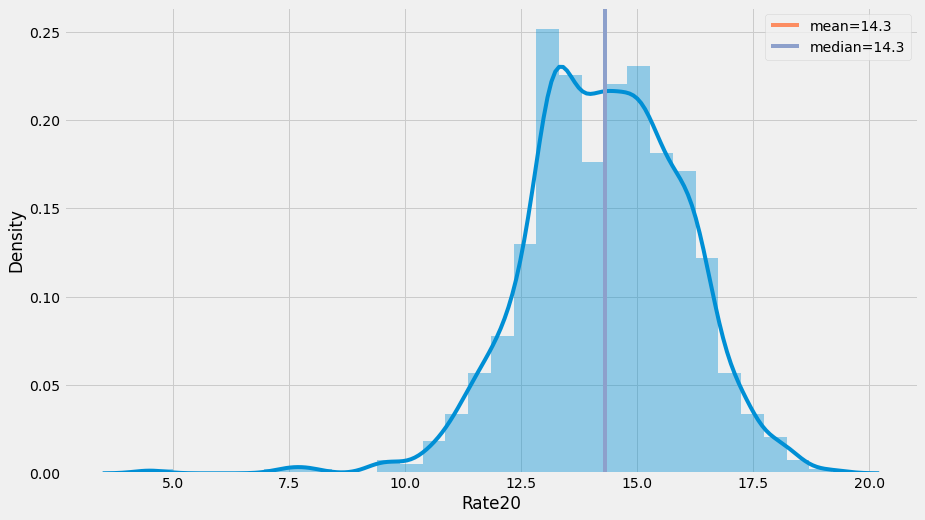

In [410]:
plot_rate20 = df_metaimdb.Rate20

# Plot Rate20
plt.figure(figsize=(30,8))
plt.subplot(1,2,1)
ax1 = sns.distplot(plot_rate20, kde_kws=dict(bw=0.2))

ax1.axvline(x=plot_rate20.mean(), c=sns.color_palette("Set2")[1], label=f"mean={round(plot_rate20.mean(), 2)}")
ax1.axvline(x=plot_rate20.median(), c=sns.color_palette("Set2")[2], label=f"median={round(plot_rate20.median(), 2)}")
plt.legend();

### Weighted average rating

In [411]:
# https://www.datacamp.com/community/tutorials/recommender-systems-python

# WeightedRating (WR) = (v/v+m * R) + (m/v+m * C)

# v is the number of votes for the movie;
# m is the minimum votes required to be listed in the chart;
# R is the average rating of the movie;
# C is the mean vote across the whole report.

In [412]:
df_rating.imdbVotes.describe()

count    8.860000e+02
mean     1.466687e+05
std      2.389759e+05
min      8.700000e+01
25%      1.744100e+04
50%      6.204700e+04
75%      1.779328e+05
max      2.505046e+06
Name: imdbVotes, dtype: float64

In [413]:
# Calculate mean of imdbRating column
C = df_rating.imdbRating.mean()
print(C)

# Calculate the minimum number of votes required to be in the chart, m
m = df_rating.imdbVotes.quantile(0.25).astype(int) # 50th percentile
print(m)

7.149209932279916
17441


In [414]:
# Filter out all qualified movies into a new DataFrame
q_movies = df_rating.copy().loc[df_rating['imdbVotes'] > m]
q_movies.shape

(664, 8)

In [415]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
#q_movies['Score'] = q_movies.apply(weighted_rating(q_movies, m, C), axis=1)
v = q_movies['imdbVotes']
R = q_movies['imdbRating']
q_movies['Score'] = weighted_rating(v, R, m, C)

#Print the top n movies based on score
cols = ['Title', 'Year', 'imdbVotes', 'imdbRating', 'Score']
q_movies[cols].nlargest(N, 'Score', keep='all')

Title  Year  imdbVotes  imdbRating     Score
249           The Godfather  1972    1756962         9.2  9.179571
34          The Dark Knight  2008    2505046         9.1  9.086081
557  The Godfather: Part II  1974    1217464         9.0  8.973890
743            12 Angry Men  1957     754474         9.0  8.958650
289               Inception  2010    2241816         8.8  8.787066
750              The Matrix  1999    1840767         8.7  8.685342
795            Interstellar  2014    1697870         8.7  8.684540
787      Back to the Future  1985    1146994         8.6  8.578189
733  Léon: The Professional  1994    1114583         8.6  8.577501
62            Spirited Away  2001     721175         8.6  8.565927

In [416]:
# Without weighted average
cols = ['Title', 'Year', 'imdbVotes', 'imdbRating']
N = 10

df_rating[cols].nlargest(N, 'imdbRating', keep='all')

Title  Year  imdbVotes  imdbRating
249                             The Godfather  1972    1756962         9.2
27                 Hans Zimmer Live in Prague  2017       2607         9.1
34                            The Dark Knight  2008    2505046         9.1
316  David Attenborough: A Life on Our Planet  2020      30806         9.0
557                    The Godfather: Part II  1974    1217464         9.0
743                              12 Angry Men  1957     754474         9.0
289                                 Inception  2010    2241816         8.8
750                                The Matrix  1999    1840767         8.7
795                              Interstellar  2014    1697870         8.7
62                              Spirited Away  2001     721175         8.6
733                    Léon: The Professional  1994    1114583         8.6
787                        Back to the Future  1985    1146994         8.6
889                   Spider-Man: No Way Home  2021     510006         8.6

## Votes

In [417]:
# Set votes dataframe
df_votes = df.copy()

In [418]:
# imdbVotes statistics
df_votes.imdbVotes.describe()

count    8.860000e+02
mean     1.466687e+05
std      2.389759e+05
min      8.700000e+01
25%      1.744100e+04
50%      6.204700e+04
75%      1.779328e+05
max      2.505046e+06
Name: imdbVotes, dtype: float64

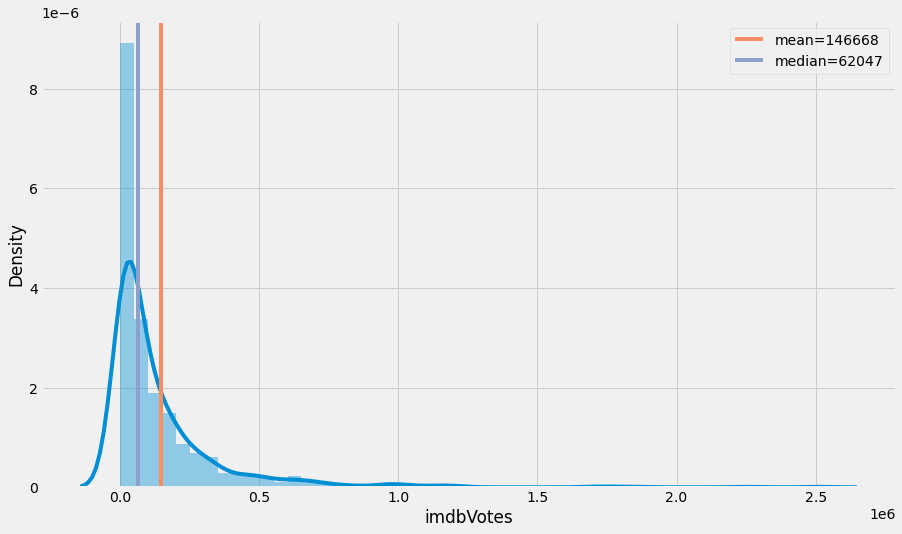

In [419]:
plot_votes = df_votes.imdbVotes

# Plot imdbVotes
plt.figure(figsize=(30,8))
plt.subplot(1,2,1)
ax1 = sns.distplot(plot_votes, kde_kws=dict(bw=0.2))

ax1.axvline(x=plot_votes.mean(), c=sns.color_palette("Set2")[1], label=f"mean={int(plot_votes.mean())}")
ax1.axvline(x=plot_votes.median(), c=sns.color_palette("Set2")[2], label=f"median={int(plot_votes.median())}")
plt.legend();

In [420]:
# https://en.wikipedia.org/wiki/Kurtosis
# Kurtosis is a measure of the "tailedness" of the probability distribution of a real-valued random variable. 
df_rating.imdbVotes.kurtosis()

26.234244663844752

## Production

In [421]:
# Set production dataframe
df_production = df.copy()

In [422]:
# Number of production companies
len(counter_display(df_production, 'Production', 'Title', None).index)

2481

In [423]:
# List of production companies with most movies
counter_display(df_production, 'Production', 'Title', N)

Title
Warner Bros.                                           45
Canal+                                                 41
Netflix                                                35
Film4                                                  27
TSG Entertainment                                      27
Walt Disney Pictures                                   25
Paramount Pictures                                     25
Columbia Pictures                                      25
Centre national du cinéma et de l'image animée ...     19
Film i Väst                                            19
Arte France Cinéma                                     19
Twentieth Century Fox                                  19

In [424]:
# Production / ratings
df_production_rating = get_mean_value(df_production, 'Production', 'imdbRating')

In [425]:
# Top producton companies 
show_all(df_production_rating.nlargest(N, 'Total', keep='all'))

In [426]:
# Production compnaies with highest imdbRating average
show_all(df_production_rating[df_production_rating.Total > 2].nlargest(N, 'imdbRating', keep='all'))

In [427]:
# Search by production company
prod_company = 'A24'
show_all(pd.DataFrame(df_production_rating.loc[prod_company]).T)

In [445]:
#